In [1]:
!pip install m3_learning


In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import time
import math

from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn
from m3_learning.viz.layout import layout_fig
from m3_learning.viz.nn import embeddings, latent_generator
from m3_learning.util.rand_util import rand_tensor
from m3_learning.viz.style import set_style
from m3_learning.nn.random import random_seed
from m3_learning.viz.nn import embeddings, latent_generator
set_style("printing")
random_seed(seed=42)

%matplotlib inline


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42


tensorflow seed was set to 42


In [3]:
class Sin_func:

    """
    Class that computes the Sin function
    """

    def __init__(
        self,
        x_vector,
        amp=[0, 1],
        phase=[0, 1],
        frequency=[0, 1],
        size=(1, 1),
        batch_size=1000,
        verbose=False,
    ):
        """

        Args:
            x_vector:
            sd (array, float): range for the standard deviation
            mean (array, float): range for the mean
            amp (array, float): range for the amplitude
            size (tuple): Size of the array first index is number of channels, second is number of functions
            verbose (bool): shows outputs
        """

        self.x_vector = x_vector
        self.batch_size = batch_size

        self.amp = amp
        self.amp_mean = torch.tensor(amp[0] + amp[1]) / 2
        self.amp_sd = torch.sqrt(
            torch.pow(torch.tensor(amp[1]) - torch.tensor(amp[0]), 2) / 12
        )

        self.phase = phase
        self.phase_mean = torch.tensor(phase[0] + phase[1]) / 2
        self.phase_sd = torch.sqrt(
            torch.pow(torch.tensor(phase[1]) - torch.tensor(phase[0]), 2) / 12
        )

        self.frequency = frequency
        self.frequency_mean = torch.tensor(frequency[0] + frequency[1]) / 2
        self.frequency_sd = torch.sqrt(
            torch.pow(torch.tensor(frequency[1]) -
                      torch.tensor(frequency[0]), 2) / 12
        )

        self.size = size
        self.verbose = verbose

    def compute(self, params, device="cpu"):
        """

        Args:
            self (object): Returns the instance itself.
            device (string, optional) : Sets the device to do the computation. Default `cpu`, common option `cuda`

        Returns: out (Tensor): spectra.

        """

        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros(
            (params.shape[0], self.x_vector.shape[0],
             self.size[0], self.size[1])
        )

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _amp = params[:, 0, 0, i]
                _phase = params[:, 0, 1, i]
                _frequency = params[:, 0, 2, i]

            if params.ndim == 3:
                _amp = params[:, 0, i]
                _phase = params[:, 1, i]
                _frequency = params[:, 2, i]

            x_vector = (
                torch.cat(params.shape[0] * [self.x_vector])
                .reshape(params.shape[0], -1)
                .to(device)
            )
            x_vector = torch.transpose(x_vector, 0, 1)  # .to(device)

            _out = _amp * torch.sin(
                2 * torch.tensor(np.pi) * _frequency * x_vector + _phase
            )

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)

    def sampler(self, device="cpu"):
        """

        Args:
            device (str): device where computation happens

        Returns:
            out (Tensor) : Generated spectra
            params (Tensor) : parameters used for generation

        """

        phase = rand_tensor(
            min=self.phase[0],
            max=self.phase[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        frequency = rand_tensor(
            min=self.frequency[0],
            max=self.frequency[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        amp = rand_tensor(
            min=self.amp[0],
            max=self.amp[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        _params = torch.torch.stack((amp, phase, frequency))

        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)

        return (self.compute(_params, device=device), _params)


In [4]:
constructor = Sin_func(
    amp=[0.2, 1],  # Sets the amplitude
    phase=[0, 2 * np.pi],  # Sets the phase
    frequency=[0.1, 0.5],  # Sets the frequency
    x_vector=torch.linspace(0, np.pi, 100),  # Sets the x_vector
    batch_size=10000,
)  # number of samples to generate


In [5]:
# initializes the constructor
output = constructor.sampler()

# grabs the parameters and the spectra
spectra, params = output

# This grabs the sum of all spectral and the individual spectra if they exist
spectra_full, spectras = spectra


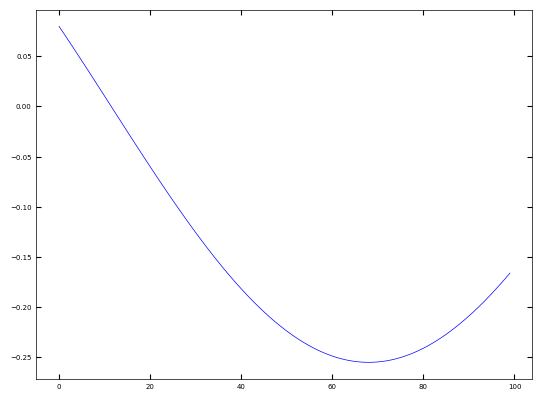

In [6]:
rand = np.random.randint(0, 10000)
plt.plot(spectras[rand, :, 0].cpu(), "b")


In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 100, 1])
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [8]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        # encode

        embedding = self.encoder(x)

        # decode

        predicted = self.decoder(embedding)

        return predicted


In [9]:
device = "cuda"
latent_dim = 3

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [10]:
# views the model

model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [11]:
# constructs a dataloader for training

dataloader = DataLoader(spectra_full, batch_size=512,
                        shuffle=True, num_workers=0)


In [12]:
# trains the model

random_seed(seed=42)

Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:10,  1.88it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 26.54it/s]

100%|██████████| 20/20 [00:00<00:00, 28.66it/s]

Epoch 0, Train Loss: 0.2216
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.17it/s]

100%|██████████| 20/20 [00:00<00:00, 124.17it/s]

Epoch 1, Train Loss: 0.2196
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 120.33it/s]

100%|██████████| 20/20 [00:00<00:00, 117.05it/s]

Epoch 2, Train Loss: 0.2179
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 125.52it/s]

100%|██████████| 20/20 [00:00<00:00, 123.69it/s]

Epoch 3, Train Loss: 0.2167
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.46it/s]

100%|██████████| 20/20 [00:00<00:00, 116.32it/s]

Epoch 4, Train Loss: 0.2155
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 125.46it/s]

100%|██████████| 20/20 [00:00<00:00, 120.83it/s]

Epoch 5, Train Loss: 0.2139
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.57it/s]

100%|██████████| 20/20 [00:00<00:00, 118.43it/s]

Epoch 6, Train Loss: 0.2130
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.96it/s]

100%|██████████| 20/20 [00:00<00:00, 120.66it/s]

Epoch 7, Train Loss: 0.2124
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.35it/s]

100%|██████████| 20/20 [00:00<00:00, 119.64it/s]

Epoch 8, Train Loss: 0.2115
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.80it/s]

100%|██████████| 20/20 [00:00<00:00, 120.72it/s]

Epoch 9, Train Loss: 0.2111
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.87it/s]

100%|██████████| 20/20 [00:00<00:00, 118.21it/s]

Epoch 10, Train Loss: 0.2103
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.98it/s]

100%|██████████| 20/20 [00:00<00:00, 119.71it/s]

Epoch 11, Train Loss: 0.2098
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.10it/s]

100%|██████████| 20/20 [00:00<00:00, 121.99it/s]

Epoch 12, Train Loss: 0.2097
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 105.65it/s]

100%|██████████| 20/20 [00:00<00:00, 109.81it/s]

Epoch 13, Train Loss: 0.2091
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.80it/s]

100%|██████████| 20/20 [00:00<00:00, 115.03it/s]

Epoch 14, Train Loss: 0.2087
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.51it/s]

100%|██████████| 20/20 [00:00<00:00, 122.56it/s]

Epoch 15, Train Loss: 0.2087
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.15it/s]

100%|██████████| 20/20 [00:00<00:00, 115.48it/s]

Epoch 16, Train Loss: 0.2086
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 125.68it/s]

100%|██████████| 20/20 [00:00<00:00, 125.77it/s]

Epoch 17, Train Loss: 0.2084
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.63it/s]

100%|██████████| 20/20 [00:00<00:00, 113.50it/s]

Epoch 18, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 126.88it/s]

100%|██████████| 20/20 [00:00<00:00, 120.67it/s]

Epoch 19, Train Loss: 0.2084
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.57it/s]

100%|██████████| 20/20 [00:00<00:00, 113.50it/s]

Epoch 20, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.58it/s]

100%|██████████| 20/20 [00:00<00:00, 118.16it/s]

Epoch 21, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.84it/s]

100%|██████████| 20/20 [00:00<00:00, 123.34it/s]

Epoch 22, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.49it/s]

100%|██████████| 20/20 [00:00<00:00, 118.39it/s]

Epoch 23, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.68it/s]

100%|██████████| 20/20 [00:00<00:00, 118.28it/s]

Epoch 24, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.14it/s]

100%|██████████| 20/20 [00:00<00:00, 123.21it/s]

Epoch 25, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.17it/s]

100%|██████████| 20/20 [00:00<00:00, 117.75it/s]

Epoch 26, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 93.13it/s]

100%|██████████| 20/20 [00:00<00:00, 93.75it/s]

100%|██████████| 20/20 [00:00<00:00, 93.37it/s]

Epoch 27, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.49it/s]

 90%|█████████ | 18/20 [00:00<00:00, 89.08it/s]

100%|██████████| 20/20 [00:00<00:00, 87.86it/s]

Epoch 28, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 90.57it/s]

100%|██████████| 20/20 [00:00<00:00, 94.98it/s]

100%|██████████| 20/20 [00:00<00:00, 94.02it/s]

Epoch 29, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.11it/s]

100%|██████████| 20/20 [00:00<00:00, 99.78it/s] 

Epoch 30, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.80it/s]

100%|██████████| 20/20 [00:00<00:00, 99.36it/s]

100%|██████████| 20/20 [00:00<00:00, 99.00it/s]

Epoch 31, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.11it/s]

100%|██████████| 20/20 [00:00<00:00, 98.72it/s] 

Epoch 32, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.19it/s]

100%|██████████| 20/20 [00:00<00:00, 97.55it/s]

Epoch 33, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.13it/s]

100%|██████████| 20/20 [00:00<00:00, 99.79it/s] 

Epoch 34, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.15it/s]

100%|██████████| 20/20 [00:00<00:00, 98.84it/s] 

Epoch 35, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.61it/s]

100%|██████████| 20/20 [00:00<00:00, 99.98it/s] 

Epoch 36, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.45it/s]

100%|██████████| 20/20 [00:00<00:00, 99.34it/s]

100%|██████████| 20/20 [00:00<00:00, 99.08it/s]

Epoch 37, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.94it/s]

100%|██████████| 20/20 [00:00<00:00, 100.13it/s]

Epoch 38, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.15it/s]

100%|██████████| 20/20 [00:00<00:00, 99.37it/s]

Epoch 39, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.35it/s]

100%|██████████| 20/20 [00:00<00:00, 98.60it/s]

100%|██████████| 20/20 [00:00<00:00, 98.32it/s]

Epoch 40, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.65it/s]

100%|██████████| 20/20 [00:00<00:00, 97.10it/s]

100%|██████████| 20/20 [00:00<00:00, 97.03it/s]

Epoch 41, Train Loss: 0.2074
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.04it/s]

100%|██████████| 20/20 [00:00<00:00, 93.16it/s]

100%|██████████| 20/20 [00:00<00:00, 93.75it/s]

Epoch 42, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.29it/s]

100%|██████████| 20/20 [00:00<00:00, 98.55it/s]

100%|██████████| 20/20 [00:00<00:00, 98.19it/s]

Epoch 43, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.22it/s]

100%|██████████| 20/20 [00:00<00:00, 100.08it/s]

Epoch 44, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.12it/s]

100%|██████████| 20/20 [00:00<00:00, 97.76it/s]

100%|██████████| 20/20 [00:00<00:00, 97.06it/s]

Epoch 45, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.26it/s]

100%|██████████| 20/20 [00:00<00:00, 98.05it/s]

100%|██████████| 20/20 [00:00<00:00, 97.70it/s]

Epoch 46, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.59it/s]

100%|██████████| 20/20 [00:00<00:00, 99.25it/s]

100%|██████████| 20/20 [00:00<00:00, 98.80it/s]

Epoch 47, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.76it/s]

100%|██████████| 20/20 [00:00<00:00, 99.27it/s]

Epoch 48, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.83it/s]

100%|██████████| 20/20 [00:00<00:00, 100.36it/s]

Epoch 49, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.45it/s]

100%|██████████| 20/20 [00:00<00:00, 98.76it/s]

100%|██████████| 20/20 [00:00<00:00, 98.17it/s]

Epoch 50, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.25it/s]

100%|██████████| 20/20 [00:00<00:00, 99.74it/s]

Epoch 51, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.70it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

Epoch 52, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.29it/s]

100%|██████████| 20/20 [00:00<00:00, 98.74it/s]

Epoch 53, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.68it/s]

100%|██████████| 20/20 [00:00<00:00, 98.89it/s] 

Epoch 54, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.13it/s]

100%|██████████| 20/20 [00:00<00:00, 99.77it/s] 

Epoch 55, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.33it/s]

100%|██████████| 20/20 [00:00<00:00, 97.39it/s]

100%|██████████| 20/20 [00:00<00:00, 97.15it/s]

Epoch 56, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.82it/s]

100%|██████████| 20/20 [00:00<00:00, 99.03it/s]

Epoch 57, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.43it/s]

100%|██████████| 20/20 [00:00<00:00, 97.61it/s]

Epoch 58, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.26it/s]

100%|██████████| 20/20 [00:00<00:00, 98.47it/s]

100%|██████████| 20/20 [00:00<00:00, 98.32it/s]

Epoch 59, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.21it/s]

100%|██████████| 20/20 [00:00<00:00, 98.36it/s] 

Epoch 60, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.76it/s]

100%|██████████| 20/20 [00:00<00:00, 99.47it/s]

100%|██████████| 20/20 [00:00<00:00, 99.04it/s]

Epoch 61, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.46it/s]

100%|██████████| 20/20 [00:00<00:00, 99.76it/s]

100%|██████████| 20/20 [00:00<00:00, 99.33it/s]

Epoch 62, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.42it/s]

100%|██████████| 20/20 [00:00<00:00, 99.93it/s]

Epoch 63, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.66it/s]

100%|██████████| 20/20 [00:00<00:00, 99.06it/s]

100%|██████████| 20/20 [00:00<00:00, 98.76it/s]

Epoch 64, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.86it/s]

100%|██████████| 20/20 [00:00<00:00, 100.67it/s]

Epoch 65, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.58it/s]

100%|██████████| 20/20 [00:00<00:00, 96.70it/s]

100%|██████████| 20/20 [00:00<00:00, 96.68it/s]

Epoch 66, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.60it/s]

100%|██████████| 20/20 [00:00<00:00, 98.87it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

Epoch 67, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.16it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

Epoch 68, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.04it/s]

100%|██████████| 20/20 [00:00<00:00, 99.09it/s] 

Epoch 69, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.82it/s]

100%|██████████| 20/20 [00:00<00:00, 98.96it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

Epoch 70, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.57it/s]

100%|██████████| 20/20 [00:00<00:00, 98.41it/s]

100%|██████████| 20/20 [00:00<00:00, 98.13it/s]

Epoch 71, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.53it/s]

100%|██████████| 20/20 [00:00<00:00, 100.13it/s]

Epoch 72, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 103.47it/s]

100%|██████████| 20/20 [00:00<00:00, 101.00it/s]

Epoch 73, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.60it/s]

100%|██████████| 20/20 [00:00<00:00, 98.87it/s] 

Epoch 74, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.71it/s]

100%|██████████| 20/20 [00:00<00:00, 99.23it/s] 

Epoch 75, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.22it/s]

100%|██████████| 20/20 [00:00<00:00, 100.58it/s]

Epoch 76, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.15it/s]

100%|██████████| 20/20 [00:00<00:00, 99.86it/s] 

Epoch 77, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 98.77it/s]

100%|██████████| 20/20 [00:00<00:00, 100.28it/s]

Epoch 78, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████| 20/20 [00:00<00:00, 99.63it/s]

Epoch 79, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.40it/s]

100%|██████████| 20/20 [00:00<00:00, 97.01it/s]

100%|██████████| 20/20 [00:00<00:00, 96.93it/s]

Epoch 80, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.98it/s]

100%|██████████| 20/20 [00:00<00:00, 97.67it/s]

100%|██████████| 20/20 [00:00<00:00, 96.85it/s]

Epoch 81, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.97it/s]

100%|██████████| 20/20 [00:00<00:00, 98.25it/s]

100%|██████████| 20/20 [00:00<00:00, 98.08it/s]

Epoch 82, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 103.61it/s]

100%|██████████| 20/20 [00:00<00:00, 101.14it/s]

Epoch 83, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.45it/s]

100%|██████████| 20/20 [00:00<00:00, 98.69it/s]

100%|██████████| 20/20 [00:00<00:00, 98.14it/s]

Epoch 84, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.89it/s]

100%|██████████| 20/20 [00:00<00:00, 99.23it/s]

100%|██████████| 20/20 [00:00<00:00, 98.86it/s]

Epoch 85, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.90it/s]

100%|██████████| 20/20 [00:00<00:00, 96.55it/s]

100%|██████████| 20/20 [00:00<00:00, 96.46it/s]

Epoch 86, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.83it/s]

100%|██████████| 20/20 [00:00<00:00, 98.57it/s]

Epoch 87, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.27it/s]

100%|██████████| 20/20 [00:00<00:00, 99.12it/s]

Epoch 88, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.47it/s]

100%|██████████| 20/20 [00:00<00:00, 99.37it/s]

Epoch 89, Train Loss: 0.2074
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.58it/s]

100%|██████████| 20/20 [00:00<00:00, 100.08it/s]

Epoch 90, Train Loss: 0.2072
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.80it/s]

100%|██████████| 20/20 [00:00<00:00, 101.18it/s]

Epoch 91, Train Loss: 0.2070
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.90it/s]

100%|██████████| 20/20 [00:00<00:00, 99.42it/s]

Epoch 92, Train Loss: 0.2072
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.90it/s]

100%|██████████| 20/20 [00:00<00:00, 100.10it/s]

Epoch 93, Train Loss: 0.2068
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.19it/s]

100%|██████████| 20/20 [00:00<00:00, 99.79it/s]

Epoch 94, Train Loss: 0.2068
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.98it/s]

100%|██████████| 20/20 [00:00<00:00, 101.12it/s]

Epoch 95, Train Loss: 0.2069
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.68it/s]

100%|██████████| 20/20 [00:00<00:00, 100.70it/s]

Epoch 96, Train Loss: 0.2068
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.82it/s]

100%|██████████| 20/20 [00:00<00:00, 100.20it/s]

Epoch 97, Train Loss: 0.2069
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.35it/s]

100%|██████████| 20/20 [00:00<00:00, 98.78it/s]

100%|██████████| 20/20 [00:00<00:00, 98.55it/s]

Epoch 98, Train Loss: 0.2062
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.41it/s]

100%|██████████| 20/20 [00:00<00:00, 99.68it/s]

100%|██████████| 20/20 [00:00<00:00, 99.25it/s]

Epoch 99, Train Loss: 0.2060
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.74it/s]

100%|██████████| 20/20 [00:00<00:00, 99.75it/s]

Epoch 100, Train Loss: 0.2055
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.17it/s]

100%|██████████| 20/20 [00:00<00:00, 100.00it/s]

Epoch 101, Train Loss: 0.2061
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.62it/s]

100%|██████████| 20/20 [00:00<00:00, 100.10it/s]

Epoch 102, Train Loss: 0.2053
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.02it/s]

100%|██████████| 20/20 [00:00<00:00, 98.15it/s]

100%|██████████| 20/20 [00:00<00:00, 97.87it/s]

Epoch 103, Train Loss: 0.2055
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.35it/s]

100%|██████████| 20/20 [00:00<00:00, 99.28it/s] 

Epoch 104, Train Loss: 0.2050
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.03it/s]

100%|██████████| 20/20 [00:00<00:00, 99.80it/s] 

Epoch 105, Train Loss: 0.2044
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.04it/s]

100%|██████████| 20/20 [00:00<00:00, 94.48it/s]

100%|██████████| 20/20 [00:00<00:00, 94.22it/s]

Epoch 106, Train Loss: 0.2043
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.16it/s]

100%|██████████| 20/20 [00:00<00:00, 99.33it/s]

Epoch 107, Train Loss: 0.2039
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.30it/s]

100%|██████████| 20/20 [00:00<00:00, 99.35it/s]

Epoch 108, Train Loss: 0.2031
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.69it/s]

100%|██████████| 20/20 [00:00<00:00, 95.50it/s]

100%|██████████| 20/20 [00:00<00:00, 95.39it/s]

Epoch 109, Train Loss: 0.2027
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.31it/s]

100%|██████████| 20/20 [00:00<00:00, 95.34it/s]

100%|██████████| 20/20 [00:00<00:00, 94.93it/s]

Epoch 110, Train Loss: 0.2025
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.94it/s]

100%|██████████| 20/20 [00:00<00:00, 99.13it/s]

Epoch 111, Train Loss: 0.2021
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.29it/s]

100%|██████████| 20/20 [00:00<00:00, 101.58it/s]

Epoch 112, Train Loss: 0.2018
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.88it/s]

100%|██████████| 20/20 [00:00<00:00, 98.23it/s]

100%|██████████| 20/20 [00:00<00:00, 97.77it/s]

Epoch 113, Train Loss: 0.2012
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.17it/s]

100%|██████████| 20/20 [00:00<00:00, 99.21it/s]

Epoch 114, Train Loss: 0.2009
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.07it/s]

100%|██████████| 20/20 [00:00<00:00, 100.04it/s]

Epoch 115, Train Loss: 0.2003
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.79it/s]

100%|██████████| 20/20 [00:00<00:00, 99.21it/s]

Epoch 116, Train Loss: 0.2002
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.65it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

100%|██████████| 20/20 [00:00<00:00, 98.43it/s]

Epoch 117, Train Loss: 0.2000
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 103.15it/s]

100%|██████████| 20/20 [00:00<00:00, 100.73it/s]

Epoch 118, Train Loss: 0.1991
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.18it/s]

100%|██████████| 20/20 [00:00<00:00, 100.05it/s]

Epoch 119, Train Loss: 0.1990
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.19it/s]

100%|██████████| 20/20 [00:00<00:00, 101.52it/s]

Epoch 120, Train Loss: 0.1984
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.57it/s]

100%|██████████| 20/20 [00:00<00:00, 100.09it/s]

Epoch 121, Train Loss: 0.1984
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.17it/s]

100%|██████████| 20/20 [00:00<00:00, 100.03it/s]

Epoch 122, Train Loss: 0.1978
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.43it/s]

100%|██████████| 20/20 [00:00<00:00, 100.09it/s]

Epoch 123, Train Loss: 0.1979
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.15it/s]

100%|██████████| 20/20 [00:00<00:00, 99.93it/s] 

Epoch 124, Train Loss: 0.1981
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.36it/s]

100%|██████████| 20/20 [00:00<00:00, 100.20it/s]

Epoch 125, Train Loss: 0.1976
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.80it/s]

100%|██████████| 20/20 [00:00<00:00, 99.62it/s]

100%|██████████| 20/20 [00:00<00:00, 99.33it/s]

Epoch 126, Train Loss: 0.1968
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.74it/s]

100%|██████████| 20/20 [00:00<00:00, 99.58it/s]

100%|██████████| 20/20 [00:00<00:00, 99.29it/s]

Epoch 127, Train Loss: 0.1947
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.11it/s]

100%|██████████| 20/20 [00:00<00:00, 99.77it/s]

Epoch 128, Train Loss: 0.1929
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.98it/s]

100%|██████████| 20/20 [00:00<00:00, 98.25it/s]

100%|██████████| 20/20 [00:00<00:00, 97.59it/s]

Epoch 129, Train Loss: 0.1916
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.72it/s]

100%|██████████| 20/20 [00:00<00:00, 100.03it/s]

Epoch 130, Train Loss: 0.1907
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.53it/s]

100%|██████████| 20/20 [00:00<00:00, 99.94it/s]

Epoch 131, Train Loss: 0.1899
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.63it/s]

100%|██████████| 20/20 [00:00<00:00, 101.53it/s]

Epoch 132, Train Loss: 0.1897
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.72it/s]

100%|██████████| 20/20 [00:00<00:00, 100.49it/s]

Epoch 133, Train Loss: 0.1897
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.33it/s]

100%|██████████| 20/20 [00:00<00:00, 96.15it/s]

100%|██████████| 20/20 [00:00<00:00, 96.03it/s]

Epoch 134, Train Loss: 0.1890
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.60it/s]

 90%|█████████ | 18/20 [00:00<00:00, 88.63it/s]

100%|██████████| 20/20 [00:00<00:00, 88.46it/s]

Epoch 135, Train Loss: 0.1890
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 90.23it/s]

100%|██████████| 20/20 [00:00<00:00, 90.91it/s]

100%|██████████| 20/20 [00:00<00:00, 90.54it/s]

Epoch 136, Train Loss: 0.1887
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.60it/s]

 90%|█████████ | 18/20 [00:00<00:00, 88.29it/s]

100%|██████████| 20/20 [00:00<00:00, 87.94it/s]

Epoch 137, Train Loss: 0.1892
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.79it/s]

100%|██████████| 20/20 [00:00<00:00, 92.86it/s]

100%|██████████| 20/20 [00:00<00:00, 93.28it/s]

Epoch 138, Train Loss: 0.1882
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.84it/s]

100%|██████████| 20/20 [00:00<00:00, 95.11it/s]

100%|██████████| 20/20 [00:00<00:00, 95.10it/s]

Epoch 139, Train Loss: 0.1888
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.79it/s]

100%|██████████| 20/20 [00:00<00:00, 123.42it/s]

Epoch 140, Train Loss: 0.1883
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.77it/s]

100%|██████████| 20/20 [00:00<00:00, 119.61it/s]

Epoch 141, Train Loss: 0.1882
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.24it/s]

100%|██████████| 20/20 [00:00<00:00, 118.50it/s]

Epoch 142, Train Loss: 0.1883
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.31it/s]

100%|██████████| 20/20 [00:00<00:00, 116.41it/s]

Epoch 143, Train Loss: 0.1878
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 117.46it/s]

100%|██████████| 20/20 [00:00<00:00, 116.49it/s]

Epoch 144, Train Loss: 0.1880
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.64it/s]

100%|██████████| 20/20 [00:00<00:00, 114.87it/s]

Epoch 145, Train Loss: 0.1873
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.05it/s]

100%|██████████| 20/20 [00:00<00:00, 117.65it/s]

Epoch 146, Train Loss: 0.1872
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.10it/s]

100%|██████████| 20/20 [00:00<00:00, 118.05it/s]

Epoch 147, Train Loss: 0.1870
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.64it/s]

100%|██████████| 20/20 [00:00<00:00, 111.74it/s]

Epoch 148, Train Loss: 0.1865
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.50it/s]

100%|██████████| 20/20 [00:00<00:00, 97.93it/s]

100%|██████████| 20/20 [00:00<00:00, 97.84it/s]

Epoch 149, Train Loss: 0.1863
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.22it/s]

100%|██████████| 20/20 [00:00<00:00, 99.00it/s]

100%|██████████| 20/20 [00:00<00:00, 98.62it/s]

Epoch 150, Train Loss: 0.1863
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.75it/s]

100%|██████████| 20/20 [00:00<00:00, 100.63it/s]

Epoch 151, Train Loss: 0.1861
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.15it/s]

100%|██████████| 20/20 [00:00<00:00, 101.41it/s]

Epoch 152, Train Loss: 0.1860
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.67it/s]

100%|██████████| 20/20 [00:00<00:00, 98.90it/s] 

Epoch 153, Train Loss: 0.1860
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.23it/s]

100%|██████████| 20/20 [00:00<00:00, 100.08it/s]

Epoch 154, Train Loss: 0.1853
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.88it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

Epoch 155, Train Loss: 0.1852
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.93it/s]

100%|██████████| 20/20 [00:00<00:00, 98.23it/s]

100%|██████████| 20/20 [00:00<00:00, 97.88it/s]

Epoch 156, Train Loss: 0.1848
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.61it/s]

100%|██████████| 20/20 [00:00<00:00, 95.74it/s]

100%|██████████| 20/20 [00:00<00:00, 95.81it/s]

Epoch 157, Train Loss: 0.1843
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.53it/s]

100%|██████████| 20/20 [00:00<00:00, 99.97it/s] 

Epoch 158, Train Loss: 0.1842
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.75it/s]

100%|██████████| 20/20 [00:00<00:00, 99.21it/s]

100%|██████████| 20/20 [00:00<00:00, 99.02it/s]

Epoch 159, Train Loss: 0.1844
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.38it/s]

100%|██████████| 20/20 [00:00<00:00, 98.32it/s]

Epoch 160, Train Loss: 0.1843
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.91it/s]

100%|██████████| 20/20 [00:00<00:00, 99.89it/s]

100%|██████████| 20/20 [00:00<00:00, 99.51it/s]

Epoch 161, Train Loss: 0.1839
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.09it/s]

100%|██████████| 20/20 [00:00<00:00, 98.75it/s] 

Epoch 162, Train Loss: 0.1836
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.79it/s]

100%|██████████| 20/20 [00:00<00:00, 114.00it/s]

Epoch 163, Train Loss: 0.1832
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 119.80it/s]

100%|██████████| 20/20 [00:00<00:00, 121.78it/s]

Epoch 164, Train Loss: 0.1838
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.15it/s]

100%|██████████| 20/20 [00:00<00:00, 121.40it/s]

Epoch 165, Train Loss: 0.1834
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 109.73it/s]

100%|██████████| 20/20 [00:00<00:00, 105.10it/s]

Epoch 166, Train Loss: 0.1833
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.47it/s]

100%|██████████| 20/20 [00:00<00:00, 99.47it/s]

100%|██████████| 20/20 [00:00<00:00, 99.06it/s]

Epoch 167, Train Loss: 0.1828
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.67it/s]

100%|██████████| 20/20 [00:00<00:00, 99.89it/s]

Epoch 168, Train Loss: 0.1824
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.91it/s]

100%|██████████| 20/20 [00:00<00:00, 99.26it/s]

Epoch 169, Train Loss: 0.1827
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.86it/s]

100%|██████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████| 20/20 [00:00<00:00, 97.72it/s]

Epoch 170, Train Loss: 0.1819
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.60it/s]

100%|██████████| 20/20 [00:00<00:00, 97.37it/s]

100%|██████████| 20/20 [00:00<00:00, 97.10it/s]

Epoch 171, Train Loss: 0.1823
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.32it/s]

100%|██████████| 20/20 [00:00<00:00, 100.87it/s]

Epoch 172, Train Loss: 0.1820
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.48it/s]

100%|██████████| 20/20 [00:00<00:00, 98.45it/s] 

Epoch 173, Train Loss: 0.1818
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.36it/s]

100%|██████████| 20/20 [00:00<00:00, 97.83it/s]

100%|██████████| 20/20 [00:00<00:00, 97.39it/s]

Epoch 174, Train Loss: 0.1818
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.89it/s]

100%|██████████| 20/20 [00:00<00:00, 98.91it/s]

Epoch 175, Train Loss: 0.1820
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.61it/s]

100%|██████████| 20/20 [00:00<00:00, 96.28it/s]

100%|██████████| 20/20 [00:00<00:00, 96.27it/s]

Epoch 176, Train Loss: 0.1814
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.88it/s]

100%|██████████| 20/20 [00:00<00:00, 100.56it/s]

Epoch 177, Train Loss: 0.1813
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.87it/s]

100%|██████████| 20/20 [00:00<00:00, 96.61it/s]

100%|██████████| 20/20 [00:00<00:00, 96.23it/s]

Epoch 178, Train Loss: 0.1814
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.58it/s]

100%|██████████| 20/20 [00:00<00:00, 98.36it/s]

Epoch 179, Train Loss: 0.1812
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.41it/s]

100%|██████████| 20/20 [00:00<00:00, 99.29it/s]

Epoch 180, Train Loss: 0.1809
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.95it/s]

100%|██████████| 20/20 [00:00<00:00, 99.13it/s]

100%|██████████| 20/20 [00:00<00:00, 98.80it/s]

Epoch 181, Train Loss: 0.1810
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.37it/s]

100%|██████████| 20/20 [00:00<00:00, 99.05it/s]

Epoch 182, Train Loss: 0.1811
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.58it/s]

100%|██████████| 20/20 [00:00<00:00, 98.11it/s]

100%|██████████| 20/20 [00:00<00:00, 97.76it/s]

Epoch 183, Train Loss: 0.1807
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.55it/s]

100%|██████████| 20/20 [00:00<00:00, 96.91it/s]

100%|██████████| 20/20 [00:00<00:00, 96.45it/s]

Epoch 184, Train Loss: 0.1808
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.87it/s]

100%|██████████| 20/20 [00:00<00:00, 99.86it/s] 

Epoch 185, Train Loss: 0.1806
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.51it/s]

100%|██████████| 20/20 [00:00<00:00, 97.90it/s]

100%|██████████| 20/20 [00:00<00:00, 97.87it/s]

Epoch 186, Train Loss: 0.1801
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.06it/s]

100%|██████████| 20/20 [00:00<00:00, 92.72it/s]

100%|██████████| 20/20 [00:00<00:00, 93.06it/s]

Epoch 187, Train Loss: 0.1801
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 91.59it/s]

100%|██████████| 20/20 [00:00<00:00, 91.08it/s]

100%|██████████| 20/20 [00:00<00:00, 90.88it/s]

Epoch 188, Train Loss: 0.1805
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 89.81it/s]

 90%|█████████ | 18/20 [00:00<00:00, 89.10it/s]

100%|██████████| 20/20 [00:00<00:00, 88.03it/s]

Epoch 189, Train Loss: 0.1798
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.13it/s]

100%|██████████| 20/20 [00:00<00:00, 101.54it/s]

Epoch 190, Train Loss: 0.1795
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.61it/s]

100%|██████████| 20/20 [00:00<00:00, 115.27it/s]

Epoch 191, Train Loss: 0.1797
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.90it/s]

100%|██████████| 20/20 [00:00<00:00, 112.94it/s]

Epoch 192, Train Loss: 0.1796
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.49it/s]

100%|██████████| 20/20 [00:00<00:00, 97.90it/s]

100%|██████████| 20/20 [00:00<00:00, 97.54it/s]

Epoch 193, Train Loss: 0.1798
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.33it/s]

100%|██████████| 20/20 [00:00<00:00, 99.32it/s]

100%|██████████| 20/20 [00:00<00:00, 99.01it/s]

Epoch 194, Train Loss: 0.1794
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.66it/s]

100%|██████████| 20/20 [00:00<00:00, 98.34it/s]

100%|██████████| 20/20 [00:00<00:00, 97.91it/s]

Epoch 195, Train Loss: 0.1791
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.42it/s]

100%|██████████| 20/20 [00:00<00:00, 96.59it/s]

100%|██████████| 20/20 [00:00<00:00, 96.45it/s]

Epoch 196, Train Loss: 0.1795
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.86it/s]

100%|██████████| 20/20 [00:00<00:00, 98.56it/s] 

Epoch 197, Train Loss: 0.1790
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.94it/s]

100%|██████████| 20/20 [00:00<00:00, 99.38it/s] 

Epoch 198, Train Loss: 0.1792
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.65it/s]

100%|██████████| 20/20 [00:00<00:00, 100.22it/s]

Epoch 199, Train Loss: 0.1786
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 98.81it/s]

100%|██████████| 20/20 [00:00<00:00, 96.96it/s]

Epoch 200, Train Loss: 0.1789
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.09it/s]

100%|██████████| 20/20 [00:00<00:00, 97.81it/s]

Epoch 201, Train Loss: 0.1787
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 93.41it/s]

100%|██████████| 20/20 [00:00<00:00, 91.36it/s]

100%|██████████| 20/20 [00:00<00:00, 91.39it/s]

Epoch 202, Train Loss: 0.1787
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 89.17it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 93.17it/s]

100%|██████████| 20/20 [00:00<00:00, 93.22it/s]

Epoch 203, Train Loss: 0.1786
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.57it/s]

100%|██████████| 20/20 [00:00<00:00, 115.47it/s]

Epoch 204, Train Loss: 0.1785
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.41it/s]

100%|██████████| 20/20 [00:00<00:00, 117.81it/s]

Epoch 205, Train Loss: 0.1784
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.96it/s]

100%|██████████| 20/20 [00:00<00:00, 116.83it/s]

Epoch 206, Train Loss: 0.1785
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.87it/s]

100%|██████████| 20/20 [00:00<00:00, 120.88it/s]

Epoch 207, Train Loss: 0.1782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.64it/s]

100%|██████████| 20/20 [00:00<00:00, 122.45it/s]

Epoch 208, Train Loss: 0.1782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.17it/s]

100%|██████████| 20/20 [00:00<00:00, 120.47it/s]

Epoch 209, Train Loss: 0.1783
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.51it/s]

100%|██████████| 20/20 [00:00<00:00, 121.22it/s]

Epoch 210, Train Loss: 0.1781
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.36it/s]

100%|██████████| 20/20 [00:00<00:00, 117.80it/s]

Epoch 211, Train Loss: 0.1782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.68it/s]

100%|██████████| 20/20 [00:00<00:00, 121.48it/s]

Epoch 212, Train Loss: 0.1783
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.64it/s]

100%|██████████| 20/20 [00:00<00:00, 105.79it/s]

Epoch 213, Train Loss: 0.1780
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.18it/s]

100%|██████████| 20/20 [00:00<00:00, 96.59it/s]

100%|██████████| 20/20 [00:00<00:00, 96.56it/s]

Epoch 214, Train Loss: 0.1780
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.87it/s]

100%|██████████| 20/20 [00:00<00:00, 98.52it/s]

Epoch 215, Train Loss: 0.1778
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.83it/s]

100%|██████████| 20/20 [00:00<00:00, 98.89it/s]

100%|██████████| 20/20 [00:00<00:00, 98.58it/s]

Epoch 216, Train Loss: 0.1776
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.26it/s]

100%|██████████| 20/20 [00:00<00:00, 100.08it/s]

Epoch 217, Train Loss: 0.1773
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.39it/s]

100%|██████████| 20/20 [00:00<00:00, 100.45it/s]

Epoch 218, Train Loss: 0.1772
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.33it/s]

100%|██████████| 20/20 [00:00<00:00, 99.41it/s]

Epoch 219, Train Loss: 0.1777
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.18it/s]

100%|██████████| 20/20 [00:00<00:00, 99.57it/s]

100%|██████████| 20/20 [00:00<00:00, 99.12it/s]

Epoch 220, Train Loss: 0.1775
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.37it/s]

100%|██████████| 20/20 [00:00<00:00, 98.75it/s]

100%|██████████| 20/20 [00:00<00:00, 98.17it/s]

Epoch 221, Train Loss: 0.1775
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.94it/s]

100%|██████████| 20/20 [00:00<00:00, 98.64it/s]

100%|██████████| 20/20 [00:00<00:00, 98.27it/s]

Epoch 222, Train Loss: 0.1771
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.09it/s]

100%|██████████| 20/20 [00:00<00:00, 99.56it/s] 

Epoch 223, Train Loss: 0.1774
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████| 20/20 [00:00<00:00, 98.43it/s]

100%|██████████| 20/20 [00:00<00:00, 98.24it/s]

Epoch 224, Train Loss: 0.1774
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.06it/s]

100%|██████████| 20/20 [00:00<00:00, 100.07it/s]

Epoch 225, Train Loss: 0.1773
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.84it/s]

100%|██████████| 20/20 [00:00<00:00, 98.99it/s]

100%|██████████| 20/20 [00:00<00:00, 98.73it/s]

Epoch 226, Train Loss: 0.1770
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.83it/s]

100%|██████████| 20/20 [00:00<00:00, 99.52it/s]

100%|██████████| 20/20 [00:00<00:00, 99.28it/s]

Epoch 227, Train Loss: 0.1769
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.75it/s]

100%|██████████| 20/20 [00:00<00:00, 97.77it/s]

100%|██████████| 20/20 [00:00<00:00, 97.39it/s]

Epoch 228, Train Loss: 0.1769
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.70it/s]

100%|██████████| 20/20 [00:00<00:00, 97.90it/s]

Epoch 229, Train Loss: 0.1766
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.59it/s]

100%|██████████| 20/20 [00:00<00:00, 99.04it/s]

Epoch 230, Train Loss: 0.1764
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.15it/s]

100%|██████████| 20/20 [00:00<00:00, 100.37it/s]

Epoch 231, Train Loss: 0.1763
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.78it/s]

100%|██████████| 20/20 [00:00<00:00, 100.16it/s]

Epoch 232, Train Loss: 0.1761
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.77it/s]

100%|██████████| 20/20 [00:00<00:00, 99.23it/s]

Epoch 233, Train Loss: 0.1763
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.26it/s]

100%|██████████| 20/20 [00:00<00:00, 97.69it/s]

100%|██████████| 20/20 [00:00<00:00, 97.25it/s]

Epoch 234, Train Loss: 0.1761
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.57it/s]

100%|██████████| 20/20 [00:00<00:00, 97.55it/s]

100%|██████████| 20/20 [00:00<00:00, 97.29it/s]

Epoch 235, Train Loss: 0.1761
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.66it/s]

100%|██████████| 20/20 [00:00<00:00, 102.33it/s]

Epoch 236, Train Loss: 0.1756
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.90it/s]

100%|██████████| 20/20 [00:00<00:00, 97.58it/s]

Epoch 237, Train Loss: 0.1758
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.52it/s]

100%|██████████| 20/20 [00:00<00:00, 99.14it/s]

Epoch 238, Train Loss: 0.1755
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.23it/s]

100%|██████████| 20/20 [00:00<00:00, 99.09it/s]

Epoch 239, Train Loss: 0.1750
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.87it/s]

100%|██████████| 20/20 [00:00<00:00, 100.40it/s]

Epoch 240, Train Loss: 0.1752
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.27it/s]

100%|██████████| 20/20 [00:00<00:00, 98.53it/s]

100%|██████████| 20/20 [00:00<00:00, 98.37it/s]

Epoch 241, Train Loss: 0.1746
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.38it/s]

100%|██████████| 20/20 [00:00<00:00, 98.49it/s]

100%|██████████| 20/20 [00:00<00:00, 98.31it/s]

Epoch 242, Train Loss: 0.1742
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.04it/s]

100%|██████████| 20/20 [00:00<00:00, 99.42it/s] 

Epoch 243, Train Loss: 0.1743
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.28it/s]

100%|██████████| 20/20 [00:00<00:00, 98.40it/s]

100%|██████████| 20/20 [00:00<00:00, 97.97it/s]

Epoch 244, Train Loss: 0.1733
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.28it/s]

100%|██████████| 20/20 [00:00<00:00, 98.84it/s]

100%|██████████| 20/20 [00:00<00:00, 98.60it/s]

Epoch 245, Train Loss: 0.1731
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.59it/s]

100%|██████████| 20/20 [00:00<00:00, 98.94it/s]

Epoch 246, Train Loss: 0.1721
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.76it/s]

100%|██████████| 20/20 [00:00<00:00, 98.72it/s]

100%|██████████| 20/20 [00:00<00:00, 98.46it/s]

Epoch 247, Train Loss: 0.1715
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.65it/s]

100%|██████████| 20/20 [00:00<00:00, 99.78it/s]

Epoch 248, Train Loss: 0.1707
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.38it/s]

100%|██████████| 20/20 [00:00<00:00, 99.99it/s] 

Epoch 249, Train Loss: 0.1698
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.73it/s]

100%|██████████| 20/20 [00:00<00:00, 100.97it/s]

Epoch 250, Train Loss: 0.1685
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.30it/s]

100%|██████████| 20/20 [00:00<00:00, 99.72it/s]

Epoch 251, Train Loss: 0.1664
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.25it/s]

100%|██████████| 20/20 [00:00<00:00, 97.99it/s]

100%|██████████| 20/20 [00:00<00:00, 97.61it/s]

Epoch 252, Train Loss: 0.1650
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.23it/s]

100%|██████████| 20/20 [00:00<00:00, 100.48it/s]

Epoch 253, Train Loss: 0.1633
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.80it/s]

100%|██████████| 20/20 [00:00<00:00, 99.93it/s]

Epoch 254, Train Loss: 0.1620
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.04it/s]

100%|██████████| 20/20 [00:00<00:00, 100.17it/s]

Epoch 255, Train Loss: 0.1609
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.40it/s]

100%|██████████| 20/20 [00:00<00:00, 99.60it/s] 

Epoch 256, Train Loss: 0.1599
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.94it/s]

100%|██████████| 20/20 [00:00<00:00, 100.03it/s]

Epoch 257, Train Loss: 0.1592
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.75it/s]

100%|██████████| 20/20 [00:00<00:00, 96.11it/s]

100%|██████████| 20/20 [00:00<00:00, 95.55it/s]

Epoch 258, Train Loss: 0.1586
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.99it/s]

100%|██████████| 20/20 [00:00<00:00, 101.42it/s]

Epoch 259, Train Loss: 0.1585
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.99it/s]

100%|██████████| 20/20 [00:00<00:00, 99.32it/s]

100%|██████████| 20/20 [00:00<00:00, 98.95it/s]

Epoch 260, Train Loss: 0.1576
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.90it/s]

100%|██████████| 20/20 [00:00<00:00, 98.98it/s]

Epoch 261, Train Loss: 0.1575
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.16it/s]

100%|██████████| 20/20 [00:00<00:00, 99.58it/s]

Epoch 262, Train Loss: 0.1571
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.43it/s]

100%|██████████| 20/20 [00:00<00:00, 101.48it/s]

Epoch 263, Train Loss: 0.1568
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.84it/s]

100%|██████████| 20/20 [00:00<00:00, 99.66it/s] 

Epoch 264, Train Loss: 0.1561
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.88it/s]

100%|██████████| 20/20 [00:00<00:00, 100.00it/s]

Epoch 265, Train Loss: 0.1560
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.85it/s]

100%|██████████| 20/20 [00:00<00:00, 98.61it/s]

100%|██████████| 20/20 [00:00<00:00, 98.41it/s]

Epoch 266, Train Loss: 0.1558
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.90it/s]

100%|██████████| 20/20 [00:00<00:00, 97.44it/s]

100%|██████████| 20/20 [00:00<00:00, 97.50it/s]

Epoch 267, Train Loss: 0.1553
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.61it/s]

100%|██████████| 20/20 [00:00<00:00, 99.65it/s] 

Epoch 268, Train Loss: 0.1552
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.77it/s]

100%|██████████| 20/20 [00:00<00:00, 100.03it/s]

Epoch 269, Train Loss: 0.1549
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.06it/s]

100%|██████████| 20/20 [00:00<00:00, 100.95it/s]

Epoch 270, Train Loss: 0.1545
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.88it/s]

100%|██████████| 20/20 [00:00<00:00, 98.30it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

Epoch 271, Train Loss: 0.1542
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.60it/s]

100%|██████████| 20/20 [00:00<00:00, 99.62it/s]

Epoch 272, Train Loss: 0.1539
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.58it/s]

100%|██████████| 20/20 [00:00<00:00, 99.00it/s]

Epoch 273, Train Loss: 0.1534
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.43it/s]

100%|██████████| 20/20 [00:00<00:00, 100.04it/s]

Epoch 274, Train Loss: 0.1536
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

100%|██████████| 20/20 [00:00<00:00, 97.69it/s]

Epoch 275, Train Loss: 0.1537
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.45it/s]

100%|██████████| 20/20 [00:00<00:00, 97.46it/s] 

Epoch 276, Train Loss: 0.1527
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.59it/s]

100%|██████████| 20/20 [00:00<00:00, 97.51it/s]

100%|██████████| 20/20 [00:00<00:00, 97.10it/s]

Epoch 277, Train Loss: 0.1524
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.64it/s]

100%|██████████| 20/20 [00:00<00:00, 99.20it/s]

100%|██████████| 20/20 [00:00<00:00, 98.80it/s]

Epoch 278, Train Loss: 0.1524
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.21it/s]

100%|██████████| 20/20 [00:00<00:00, 99.55it/s]

Epoch 279, Train Loss: 0.1518
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.71it/s]

100%|██████████| 20/20 [00:00<00:00, 99.70it/s]

100%|██████████| 20/20 [00:00<00:00, 99.32it/s]

Epoch 280, Train Loss: 0.1515
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.74it/s]

100%|██████████| 20/20 [00:00<00:00, 99.44it/s]

Epoch 281, Train Loss: 0.1516
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.65it/s]

100%|██████████| 20/20 [00:00<00:00, 98.56it/s]

100%|██████████| 20/20 [00:00<00:00, 97.97it/s]

Epoch 282, Train Loss: 0.1508
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.77it/s]

100%|██████████| 20/20 [00:00<00:00, 99.33it/s]

100%|██████████| 20/20 [00:00<00:00, 98.98it/s]

Epoch 283, Train Loss: 0.1508
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.65it/s]

100%|██████████| 20/20 [00:00<00:00, 99.46it/s] 

Epoch 284, Train Loss: 0.1507
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.45it/s]

100%|██████████| 20/20 [00:00<00:00, 99.08it/s] 

Epoch 285, Train Loss: 0.1504
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.58it/s]

100%|██████████| 20/20 [00:00<00:00, 98.86it/s]

100%|██████████| 20/20 [00:00<00:00, 98.54it/s]

Epoch 286, Train Loss: 0.1501
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.35it/s]

100%|██████████| 20/20 [00:00<00:00, 99.73it/s]

100%|██████████| 20/20 [00:00<00:00, 99.24it/s]

Epoch 287, Train Loss: 0.1503
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.18it/s]

100%|██████████| 20/20 [00:00<00:00, 98.73it/s]

100%|██████████| 20/20 [00:00<00:00, 98.42it/s]

Epoch 288, Train Loss: 0.1495
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.85it/s]

100%|██████████| 20/20 [00:00<00:00, 100.27it/s]

Epoch 289, Train Loss: 0.1494
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.38it/s]

100%|██████████| 20/20 [00:00<00:00, 99.49it/s] 

Epoch 290, Train Loss: 0.1489
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.42it/s]

100%|██████████| 20/20 [00:00<00:00, 99.26it/s]

Epoch 291, Train Loss: 0.1487
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.82it/s]

100%|██████████| 20/20 [00:00<00:00, 98.30it/s]

100%|██████████| 20/20 [00:00<00:00, 98.08it/s]

Epoch 292, Train Loss: 0.1484
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.81it/s]

100%|██████████| 20/20 [00:00<00:00, 99.02it/s]

100%|██████████| 20/20 [00:00<00:00, 98.53it/s]

Epoch 293, Train Loss: 0.1482
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.19it/s]

100%|██████████| 20/20 [00:00<00:00, 98.99it/s]

100%|██████████| 20/20 [00:00<00:00, 98.57it/s]

Epoch 294, Train Loss: 0.1479
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.69it/s]

100%|██████████| 20/20 [00:00<00:00, 99.57it/s]

Epoch 295, Train Loss: 0.1470
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.93it/s]

100%|██████████| 20/20 [00:00<00:00, 97.43it/s]

100%|██████████| 20/20 [00:00<00:00, 97.54it/s]

Epoch 296, Train Loss: 0.1474
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.96it/s]

100%|██████████| 20/20 [00:00<00:00, 96.71it/s]

100%|██████████| 20/20 [00:00<00:00, 96.64it/s]

Epoch 297, Train Loss: 0.1467
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.92it/s]

100%|██████████| 20/20 [00:00<00:00, 98.88it/s] 

Epoch 298, Train Loss: 0.1468
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 104.41it/s]

100%|██████████| 20/20 [00:00<00:00, 103.88it/s]

Epoch 299, Train Loss: 0.1462
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.82it/s]

100%|██████████| 20/20 [00:00<00:00, 98.42it/s]

100%|██████████| 20/20 [00:00<00:00, 98.21it/s]

Epoch 300, Train Loss: 0.1460
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.31it/s]

100%|██████████| 20/20 [00:00<00:00, 100.03it/s]

Epoch 301, Train Loss: 0.1457
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.29it/s]

100%|██████████| 20/20 [00:00<00:00, 98.47it/s]

100%|██████████| 20/20 [00:00<00:00, 98.33it/s]

Epoch 302, Train Loss: 0.1458
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.56it/s]

100%|██████████| 20/20 [00:00<00:00, 98.71it/s]

100%|██████████| 20/20 [00:00<00:00, 98.17it/s]

Epoch 303, Train Loss: 0.1452
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.99it/s]

100%|██████████| 20/20 [00:00<00:00, 98.76it/s]

100%|██████████| 20/20 [00:00<00:00, 98.57it/s]

Epoch 304, Train Loss: 0.1450
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.49it/s]

100%|██████████| 20/20 [00:00<00:00, 98.21it/s]

100%|██████████| 20/20 [00:00<00:00, 98.06it/s]

Epoch 305, Train Loss: 0.1448
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.80it/s]

100%|██████████| 20/20 [00:00<00:00, 98.57it/s]

100%|██████████| 20/20 [00:00<00:00, 98.20it/s]

Epoch 306, Train Loss: 0.1443
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.46it/s]

100%|██████████| 20/20 [00:00<00:00, 98.54it/s]

100%|██████████| 20/20 [00:00<00:00, 98.17it/s]

Epoch 307, Train Loss: 0.1441
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.70it/s]

100%|██████████| 20/20 [00:00<00:00, 97.93it/s]

100%|██████████| 20/20 [00:00<00:00, 97.59it/s]

Epoch 308, Train Loss: 0.1437
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.19it/s]

100%|██████████| 20/20 [00:00<00:00, 100.29it/s]

Epoch 309, Train Loss: 0.1430
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.22it/s]

100%|██████████| 20/20 [00:00<00:00, 99.37it/s] 

Epoch 310, Train Loss: 0.1430
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.78it/s]

100%|██████████| 20/20 [00:00<00:00, 100.98it/s]

Epoch 311, Train Loss: 0.1430
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.59it/s]

100%|██████████| 20/20 [00:00<00:00, 99.72it/s] 

Epoch 312, Train Loss: 0.1427
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.14it/s]

100%|██████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████| 20/20 [00:00<00:00, 96.85it/s]

Epoch 313, Train Loss: 0.1424
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.84it/s]

100%|██████████| 20/20 [00:00<00:00, 100.56it/s]

Epoch 314, Train Loss: 0.1419
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.01it/s]

100%|██████████| 20/20 [00:00<00:00, 99.24it/s] 

Epoch 315, Train Loss: 0.1416
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.07it/s]

100%|██████████| 20/20 [00:00<00:00, 99.51it/s]

100%|██████████| 20/20 [00:00<00:00, 99.13it/s]

Epoch 316, Train Loss: 0.1412
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.03it/s]

100%|██████████| 20/20 [00:00<00:00, 97.82it/s]

100%|██████████| 20/20 [00:00<00:00, 97.39it/s]

Epoch 317, Train Loss: 0.1407
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.95it/s]

100%|██████████| 20/20 [00:00<00:00, 98.92it/s]

Epoch 318, Train Loss: 0.1406
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.84it/s]

100%|██████████| 20/20 [00:00<00:00, 99.35it/s] 

Epoch 319, Train Loss: 0.1404
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.78it/s]

100%|██████████| 20/20 [00:00<00:00, 98.91it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

Epoch 320, Train Loss: 0.1397
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.89it/s]

100%|██████████| 20/20 [00:00<00:00, 101.04it/s]

Epoch 321, Train Loss: 0.1395
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.74it/s]

100%|██████████| 20/20 [00:00<00:00, 99.32it/s] 

Epoch 322, Train Loss: 0.1391
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.71it/s]

100%|██████████| 20/20 [00:00<00:00, 100.45it/s]

Epoch 323, Train Loss: 0.1391
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 89.16it/s]

 90%|█████████ | 18/20 [00:00<00:00, 88.68it/s]

100%|██████████| 20/20 [00:00<00:00, 88.57it/s]

Epoch 324, Train Loss: 0.1385
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 90.23it/s]

100%|██████████| 20/20 [00:00<00:00, 89.13it/s]

100%|██████████| 20/20 [00:00<00:00, 89.07it/s]

Epoch 325, Train Loss: 0.1383
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 85.56it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 88.93it/s]

100%|██████████| 20/20 [00:00<00:00, 87.78it/s]

Epoch 326, Train Loss: 0.1377
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 91.90it/s]

100%|██████████| 20/20 [00:00<00:00, 89.76it/s]

100%|██████████| 20/20 [00:00<00:00, 89.80it/s]

Epoch 327, Train Loss: 0.1379
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 107.05it/s]

100%|██████████| 20/20 [00:00<00:00, 112.16it/s]

Epoch 328, Train Loss: 0.1370
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 117.86it/s]

100%|██████████| 20/20 [00:00<00:00, 118.49it/s]

Epoch 329, Train Loss: 0.1369
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 120.61it/s]

100%|██████████| 20/20 [00:00<00:00, 118.17it/s]

Epoch 330, Train Loss: 0.1365
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.06it/s]

100%|██████████| 20/20 [00:00<00:00, 116.38it/s]

Epoch 331, Train Loss: 0.1360
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.22it/s]

100%|██████████| 20/20 [00:00<00:00, 116.93it/s]

Epoch 332, Train Loss: 0.1354
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 87.81it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 89.73it/s]

100%|██████████| 20/20 [00:00<00:00, 89.32it/s]

Epoch 333, Train Loss: 0.1351
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.47it/s]

 90%|█████████ | 18/20 [00:00<00:00, 88.21it/s]

100%|██████████| 20/20 [00:00<00:00, 88.71it/s]

Epoch 334, Train Loss: 0.1347
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 87.95it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 89.24it/s]

100%|██████████| 20/20 [00:00<00:00, 88.32it/s]

Epoch 335, Train Loss: 0.1343
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 91.11it/s]

100%|██████████| 20/20 [00:00<00:00, 88.87it/s]

100%|██████████| 20/20 [00:00<00:00, 88.98it/s]

Epoch 336, Train Loss: 0.1339
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 89.21it/s]

 90%|█████████ | 18/20 [00:00<00:00, 88.97it/s]

100%|██████████| 20/20 [00:00<00:00, 88.31it/s]

Epoch 337, Train Loss: 0.1332
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 87.58it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 89.15it/s]

100%|██████████| 20/20 [00:00<00:00, 89.06it/s]

Epoch 338, Train Loss: 0.1330
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 90.60it/s]

100%|██████████| 20/20 [00:00<00:00, 90.48it/s]

100%|██████████| 20/20 [00:00<00:00, 90.23it/s]

Epoch 339, Train Loss: 0.1322
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 86.33it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 93.02it/s]

100%|██████████| 20/20 [00:00<00:00, 91.93it/s]

Epoch 340, Train Loss: 0.1320
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.16it/s]

100%|██████████| 20/20 [00:00<00:00, 100.39it/s]

Epoch 341, Train Loss: 0.1311
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.72it/s]

100%|██████████| 20/20 [00:00<00:00, 96.21it/s]

100%|██████████| 20/20 [00:00<00:00, 96.46it/s]

Epoch 342, Train Loss: 0.1309
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.98it/s]

100%|██████████| 20/20 [00:00<00:00, 98.88it/s]

Epoch 343, Train Loss: 0.1303
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.47it/s]

100%|██████████| 20/20 [00:00<00:00, 100.18it/s]

Epoch 344, Train Loss: 0.1302
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.24it/s]

100%|██████████| 20/20 [00:00<00:00, 99.56it/s]

Epoch 345, Train Loss: 0.1294
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.19it/s]

100%|██████████| 20/20 [00:00<00:00, 98.04it/s]

100%|██████████| 20/20 [00:00<00:00, 97.69it/s]

Epoch 346, Train Loss: 0.1292
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.65it/s]

100%|██████████| 20/20 [00:00<00:00, 99.89it/s] 

Epoch 347, Train Loss: 0.1288
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.10it/s]

100%|██████████| 20/20 [00:00<00:00, 97.69it/s]

100%|██████████| 20/20 [00:00<00:00, 97.59it/s]

Epoch 348, Train Loss: 0.1282
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.98it/s]

100%|██████████| 20/20 [00:00<00:00, 99.06it/s]

100%|██████████| 20/20 [00:00<00:00, 98.93it/s]

Epoch 349, Train Loss: 0.1278
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.81it/s]

100%|██████████| 20/20 [00:00<00:00, 99.82it/s] 

Epoch 350, Train Loss: 0.1277
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.81it/s]

100%|██████████| 20/20 [00:00<00:00, 101.48it/s]

Epoch 351, Train Loss: 0.1275
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.78it/s]

100%|██████████| 20/20 [00:00<00:00, 98.19it/s]

100%|██████████| 20/20 [00:00<00:00, 98.02it/s]

Epoch 352, Train Loss: 0.1274
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.72it/s]

100%|██████████| 20/20 [00:00<00:00, 99.81it/s] 

Epoch 353, Train Loss: 0.1266
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.14it/s]

100%|██████████| 20/20 [00:00<00:00, 99.58it/s]

Epoch 354, Train Loss: 0.1268
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.55it/s]

100%|██████████| 20/20 [00:00<00:00, 98.95it/s] 

Epoch 355, Train Loss: 0.1263
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.10it/s]

100%|██████████| 20/20 [00:00<00:00, 99.77it/s]

Epoch 356, Train Loss: 0.1257
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.52it/s]

100%|██████████| 20/20 [00:00<00:00, 99.20it/s]

Epoch 357, Train Loss: 0.1257
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.49it/s]

100%|██████████| 20/20 [00:00<00:00, 98.71it/s]

100%|██████████| 20/20 [00:00<00:00, 98.10it/s]

Epoch 358, Train Loss: 0.1255
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.84it/s]

100%|██████████| 20/20 [00:00<00:00, 99.38it/s]

100%|██████████| 20/20 [00:00<00:00, 98.93it/s]

Epoch 359, Train Loss: 0.1255
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.78it/s]

100%|██████████| 20/20 [00:00<00:00, 98.32it/s]

100%|██████████| 20/20 [00:00<00:00, 97.97it/s]

Epoch 360, Train Loss: 0.1251
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.07it/s]

100%|██████████| 20/20 [00:00<00:00, 99.63it/s]

Epoch 361, Train Loss: 0.1246
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.90it/s]

100%|██████████| 20/20 [00:00<00:00, 99.93it/s]

100%|██████████| 20/20 [00:00<00:00, 99.61it/s]

Epoch 362, Train Loss: 0.1242
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.87it/s]

100%|██████████| 20/20 [00:00<00:00, 99.15it/s]

Epoch 363, Train Loss: 0.1240
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.82it/s]

100%|██████████| 20/20 [00:00<00:00, 99.29it/s]

100%|██████████| 20/20 [00:00<00:00, 98.95it/s]

Epoch 364, Train Loss: 0.1242
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.33it/s]

100%|██████████| 20/20 [00:00<00:00, 100.11it/s]

Epoch 365, Train Loss: 0.1238
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.58it/s]

100%|██████████| 20/20 [00:00<00:00, 99.44it/s]

Epoch 366, Train Loss: 0.1233
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.64it/s]

100%|██████████| 20/20 [00:00<00:00, 99.01it/s]

100%|██████████| 20/20 [00:00<00:00, 98.68it/s]

Epoch 367, Train Loss: 0.1229
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.05it/s]

100%|██████████| 20/20 [00:00<00:00, 99.81it/s] 

Epoch 368, Train Loss: 0.1234
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.25it/s]

100%|██████████| 20/20 [00:00<00:00, 99.24it/s]

Epoch 369, Train Loss: 0.1229
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.48it/s]

100%|██████████| 20/20 [00:00<00:00, 98.56it/s]

100%|██████████| 20/20 [00:00<00:00, 98.24it/s]

Epoch 370, Train Loss: 0.1224
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.79it/s]

100%|██████████| 20/20 [00:00<00:00, 92.49it/s]

100%|██████████| 20/20 [00:00<00:00, 92.97it/s]

Epoch 371, Train Loss: 0.1226
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 89.12it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 88.58it/s]

100%|██████████| 20/20 [00:00<00:00, 88.85it/s]

Epoch 372, Train Loss: 0.1224
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 85.24it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 89.72it/s]

100%|██████████| 20/20 [00:00<00:00, 88.32it/s]

Epoch 373, Train Loss: 0.1220
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.77it/s]

 90%|█████████ | 18/20 [00:00<00:00, 88.40it/s]

100%|██████████| 20/20 [00:00<00:00, 88.32it/s]

Epoch 374, Train Loss: 0.1222
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 93.88it/s]

100%|██████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████| 20/20 [00:00<00:00, 96.10it/s]

Epoch 375, Train Loss: 0.1218
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.65it/s]

100%|██████████| 20/20 [00:00<00:00, 98.86it/s]

Epoch 376, Train Loss: 0.1216
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.61it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

100%|██████████| 20/20 [00:00<00:00, 98.26it/s]

Epoch 377, Train Loss: 0.1208
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.45it/s]

100%|██████████| 20/20 [00:00<00:00, 98.91it/s] 

Epoch 378, Train Loss: 0.1209
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.44it/s]

100%|██████████| 20/20 [00:00<00:00, 95.27it/s]

100%|██████████| 20/20 [00:00<00:00, 94.86it/s]

Epoch 379, Train Loss: 0.1210
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.91it/s]

100%|██████████| 20/20 [00:00<00:00, 97.15it/s]

100%|██████████| 20/20 [00:00<00:00, 96.71it/s]

Epoch 380, Train Loss: 0.1209
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.50it/s]

100%|██████████| 20/20 [00:00<00:00, 97.13it/s]

100%|██████████| 20/20 [00:00<00:00, 96.78it/s]

Epoch 381, Train Loss: 0.1204
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.21it/s]

100%|██████████| 20/20 [00:00<00:00, 101.14it/s]

Epoch 382, Train Loss: 0.1203
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.76it/s]

100%|██████████| 20/20 [00:00<00:00, 96.40it/s]

100%|██████████| 20/20 [00:00<00:00, 96.45it/s]

Epoch 383, Train Loss: 0.1203
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.03it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.31it/s]

Epoch 384, Train Loss: 0.1200
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.43it/s]

100%|██████████| 20/20 [00:00<00:00, 99.22it/s]

100%|██████████| 20/20 [00:00<00:00, 98.72it/s]

Epoch 385, Train Loss: 0.1199
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.60it/s]

100%|██████████| 20/20 [00:00<00:00, 97.77it/s]

100%|██████████| 20/20 [00:00<00:00, 97.78it/s]

Epoch 386, Train Loss: 0.1198
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.70it/s]

100%|██████████| 20/20 [00:00<00:00, 99.48it/s]

Epoch 387, Train Loss: 0.1196
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.68it/s]

100%|██████████| 20/20 [00:00<00:00, 99.08it/s]

100%|██████████| 20/20 [00:00<00:00, 98.64it/s]

Epoch 388, Train Loss: 0.1192
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.56it/s]

100%|██████████| 20/20 [00:00<00:00, 99.79it/s]

Epoch 389, Train Loss: 0.1192
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.33it/s]

100%|██████████| 20/20 [00:00<00:00, 100.79it/s]

Epoch 390, Train Loss: 0.1189
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.72it/s]

100%|██████████| 20/20 [00:00<00:00, 97.72it/s]

100%|██████████| 20/20 [00:00<00:00, 97.58it/s]

Epoch 391, Train Loss: 0.1188
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.28it/s]

100%|██████████| 20/20 [00:00<00:00, 98.94it/s]

Epoch 392, Train Loss: 0.1185
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.82it/s]

100%|██████████| 20/20 [00:00<00:00, 98.52it/s]

Epoch 393, Train Loss: 0.1185
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.99it/s]

100%|██████████| 20/20 [00:00<00:00, 99.95it/s]

Epoch 394, Train Loss: 0.1183
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.78it/s]

100%|██████████| 20/20 [00:00<00:00, 98.17it/s]

100%|██████████| 20/20 [00:00<00:00, 98.03it/s]

Epoch 395, Train Loss: 0.1180
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.50it/s]

100%|██████████| 20/20 [00:00<00:00, 100.01it/s]

Epoch 396, Train Loss: 0.1183
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.06it/s]

100%|██████████| 20/20 [00:00<00:00, 98.03it/s]

100%|██████████| 20/20 [00:00<00:00, 97.43it/s]

Epoch 397, Train Loss: 0.1179
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.69it/s]

100%|██████████| 20/20 [00:00<00:00, 99.82it/s]

Epoch 398, Train Loss: 0.1179
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.90it/s]

100%|██████████| 20/20 [00:00<00:00, 100.34it/s]

Epoch 399, Train Loss: 0.1178
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.88it/s]

100%|██████████| 20/20 [00:00<00:00, 98.82it/s]

100%|██████████| 20/20 [00:00<00:00, 98.46it/s]

Epoch 400, Train Loss: 0.1188
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.34it/s]

100%|██████████| 20/20 [00:00<00:00, 100.86it/s]

Epoch 401, Train Loss: 0.1172
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.50it/s]

100%|██████████| 20/20 [00:00<00:00, 97.56it/s]

100%|██████████| 20/20 [00:00<00:00, 96.94it/s]

Epoch 402, Train Loss: 0.1172
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.35it/s]

100%|██████████| 20/20 [00:00<00:00, 97.88it/s]

100%|██████████| 20/20 [00:00<00:00, 97.65it/s]

Epoch 403, Train Loss: 0.1171
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.49it/s]

100%|██████████| 20/20 [00:00<00:00, 99.12it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

Epoch 404, Train Loss: 0.1176
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.64it/s]

100%|██████████| 20/20 [00:00<00:00, 99.26it/s]

100%|██████████| 20/20 [00:00<00:00, 98.90it/s]

Epoch 405, Train Loss: 0.1172
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.91it/s]

100%|██████████| 20/20 [00:00<00:00, 95.59it/s]

100%|██████████| 20/20 [00:00<00:00, 95.85it/s]

Epoch 406, Train Loss: 0.1168
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.79it/s]

100%|██████████| 20/20 [00:00<00:00, 91.77it/s]

100%|██████████| 20/20 [00:00<00:00, 92.34it/s]

Epoch 407, Train Loss: 0.1164
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 109.05it/s]

100%|██████████| 20/20 [00:00<00:00, 111.48it/s]

Epoch 408, Train Loss: 0.1162
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.45it/s]

100%|██████████| 20/20 [00:00<00:00, 118.57it/s]

Epoch 409, Train Loss: 0.1161
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.45it/s]

100%|██████████| 20/20 [00:00<00:00, 117.46it/s]

Epoch 410, Train Loss: 0.1158
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.60it/s]

100%|██████████| 20/20 [00:00<00:00, 115.57it/s]

Epoch 411, Train Loss: 0.1157
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.74it/s]

100%|██████████| 20/20 [00:00<00:00, 113.42it/s]

Epoch 412, Train Loss: 0.1156
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.39it/s]

100%|██████████| 20/20 [00:00<00:00, 120.44it/s]

Epoch 413, Train Loss: 0.1155
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.45it/s]

100%|██████████| 20/20 [00:00<00:00, 113.21it/s]

Epoch 414, Train Loss: 0.1151
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.86it/s]

100%|██████████| 20/20 [00:00<00:00, 118.55it/s]

Epoch 415, Train Loss: 0.1149
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.68it/s]

100%|██████████| 20/20 [00:00<00:00, 99.09it/s] 

Epoch 416, Train Loss: 0.1146
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.03it/s]

100%|██████████| 20/20 [00:00<00:00, 100.00it/s]

Epoch 417, Train Loss: 0.1146
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 103.49it/s]

100%|██████████| 20/20 [00:00<00:00, 101.04it/s]

Epoch 418, Train Loss: 0.1149
.............................

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.34it/s]

100%|██████████| 20/20 [00:00<00:00, 98.36it/s]

100%|██████████| 20/20 [00:00<00:00, 97.99it/s]

Epoch 419, Train Loss: 0.1141
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.41it/s]

100%|██████████| 20/20 [00:00<00:00, 100.47it/s]

Epoch 420, Train Loss: 0.1143
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.83it/s]

100%|██████████| 20/20 [00:00<00:00, 98.87it/s]

100%|██████████| 20/20 [00:00<00:00, 98.60it/s]

Epoch 421, Train Loss: 0.1140
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.81it/s]

100%|██████████| 20/20 [00:00<00:00, 99.07it/s]

Epoch 422, Train Loss: 0.1140
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████| 20/20 [00:00<00:00, 94.42it/s]

100%|██████████| 20/20 [00:00<00:00, 94.47it/s]

Epoch 423, Train Loss: 0.1136
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.74it/s]

100%|██████████| 20/20 [00:00<00:00, 99.54it/s]

Epoch 424, Train Loss: 0.1138
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.51it/s]

100%|██████████| 20/20 [00:00<00:00, 98.45it/s]

100%|██████████| 20/20 [00:00<00:00, 98.20it/s]

Epoch 425, Train Loss: 0.1136
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.71it/s]

100%|██████████| 20/20 [00:00<00:00, 99.27it/s]

100%|██████████| 20/20 [00:00<00:00, 99.02it/s]

Epoch 426, Train Loss: 0.1134
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.12it/s]

100%|██████████| 20/20 [00:00<00:00, 98.38it/s]

100%|██████████| 20/20 [00:00<00:00, 97.81it/s]

Epoch 427, Train Loss: 0.1129
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.75it/s]

100%|██████████| 20/20 [00:00<00:00, 103.05it/s]

Epoch 428, Train Loss: 0.1130
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.19it/s]

100%|██████████| 20/20 [00:00<00:00, 97.32it/s]

100%|██████████| 20/20 [00:00<00:00, 97.22it/s]

Epoch 429, Train Loss: 0.1131
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.50it/s]

100%|██████████| 20/20 [00:00<00:00, 99.75it/s]

Epoch 430, Train Loss: 0.1134
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.73it/s]

100%|██████████| 20/20 [00:00<00:00, 99.46it/s]

100%|██████████| 20/20 [00:00<00:00, 99.19it/s]

Epoch 431, Train Loss: 0.1130
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.25it/s]

100%|██████████| 20/20 [00:00<00:00, 98.28it/s]

100%|██████████| 20/20 [00:00<00:00, 97.91it/s]

Epoch 432, Train Loss: 0.1124
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.66it/s]

100%|██████████| 20/20 [00:00<00:00, 99.71it/s]

100%|██████████| 20/20 [00:00<00:00, 99.38it/s]

Epoch 433, Train Loss: 0.1122
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.01it/s]

100%|██████████| 20/20 [00:00<00:00, 97.47it/s]

100%|██████████| 20/20 [00:00<00:00, 97.26it/s]

Epoch 434, Train Loss: 0.1116
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.52it/s]

100%|██████████| 20/20 [00:00<00:00, 99.74it/s] 

Epoch 435, Train Loss: 0.1117
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.25it/s]

100%|██████████| 20/20 [00:00<00:00, 98.83it/s]

100%|██████████| 20/20 [00:00<00:00, 98.58it/s]

Epoch 436, Train Loss: 0.1117
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.88it/s]

100%|██████████| 20/20 [00:00<00:00, 97.67it/s]

100%|██████████| 20/20 [00:00<00:00, 97.47it/s]

Epoch 437, Train Loss: 0.1112
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.15it/s]

100%|██████████| 20/20 [00:00<00:00, 100.78it/s]

Epoch 438, Train Loss: 0.1107
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.34it/s]

100%|██████████| 20/20 [00:00<00:00, 100.66it/s]

Epoch 439, Train Loss: 0.1112
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.80it/s]

100%|██████████| 20/20 [00:00<00:00, 100.15it/s]

Epoch 440, Train Loss: 0.1109
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.40it/s]

100%|██████████| 20/20 [00:00<00:00, 100.33it/s]

Epoch 441, Train Loss: 0.1104
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.12it/s]

100%|██████████| 20/20 [00:00<00:00, 99.29it/s]

Epoch 442, Train Loss: 0.1105
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.61it/s]

100%|██████████| 20/20 [00:00<00:00, 97.22it/s]

100%|██████████| 20/20 [00:00<00:00, 96.99it/s]

Epoch 443, Train Loss: 0.1102
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.27it/s]

100%|██████████| 20/20 [00:00<00:00, 101.59it/s]

Epoch 444, Train Loss: 0.1103
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.72it/s]

100%|██████████| 20/20 [00:00<00:00, 99.50it/s]

Epoch 445, Train Loss: 0.1099
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.06it/s]

100%|██████████| 20/20 [00:00<00:00, 99.52it/s]

Epoch 446, Train Loss: 0.1095
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.66it/s]

100%|██████████| 20/20 [00:00<00:00, 99.41it/s] 

Epoch 447, Train Loss: 0.1095
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.14it/s]

100%|██████████| 20/20 [00:00<00:00, 101.25it/s]

Epoch 448, Train Loss: 0.1094
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.67it/s]

100%|██████████| 20/20 [00:00<00:00, 98.73it/s]

100%|██████████| 20/20 [00:00<00:00, 98.44it/s]

Epoch 449, Train Loss: 0.1087
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.51it/s]

100%|██████████| 20/20 [00:00<00:00, 98.24it/s] 

Epoch 450, Train Loss: 0.1085
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.18it/s]

100%|██████████| 20/20 [00:00<00:00, 98.53it/s]

100%|██████████| 20/20 [00:00<00:00, 98.10it/s]

Epoch 451, Train Loss: 0.1082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.64it/s]

100%|██████████| 20/20 [00:00<00:00, 100.51it/s]

Epoch 452, Train Loss: 0.1082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.33it/s]

100%|██████████| 20/20 [00:00<00:00, 98.95it/s]

100%|██████████| 20/20 [00:00<00:00, 98.48it/s]

Epoch 453, Train Loss: 0.1084
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.57it/s]

100%|██████████| 20/20 [00:00<00:00, 99.59it/s]

100%|██████████| 20/20 [00:00<00:00, 99.27it/s]

Epoch 454, Train Loss: 0.1080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.78it/s]

100%|██████████| 20/20 [00:00<00:00, 96.19it/s]

100%|██████████| 20/20 [00:00<00:00, 96.13it/s]

Epoch 455, Train Loss: 0.1075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████| 20/20 [00:00<00:00, 99.07it/s]

100%|██████████| 20/20 [00:00<00:00, 98.64it/s]

Epoch 456, Train Loss: 0.1071
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.41it/s]

100%|██████████| 20/20 [00:00<00:00, 99.62it/s] 

Epoch 457, Train Loss: 0.1072
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.56it/s]

100%|██████████| 20/20 [00:00<00:00, 99.66it/s]

100%|██████████| 20/20 [00:00<00:00, 99.33it/s]

Epoch 458, Train Loss: 0.1066
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.90it/s]

100%|██████████| 20/20 [00:00<00:00, 99.54it/s]

100%|██████████| 20/20 [00:00<00:00, 99.17it/s]

Epoch 459, Train Loss: 0.1060
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.66it/s]

100%|██████████| 20/20 [00:00<00:00, 98.06it/s]

100%|██████████| 20/20 [00:00<00:00, 97.48it/s]

Epoch 460, Train Loss: 0.1060
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.90it/s]

100%|██████████| 20/20 [00:00<00:00, 99.78it/s]

100%|██████████| 20/20 [00:00<00:00, 99.41it/s]

Epoch 461, Train Loss: 0.1059
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.31it/s]

100%|██████████| 20/20 [00:00<00:00, 97.32it/s]

Epoch 462, Train Loss: 0.1055
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.76it/s]

100%|██████████| 20/20 [00:00<00:00, 97.99it/s]

100%|██████████| 20/20 [00:00<00:00, 97.92it/s]

Epoch 463, Train Loss: 0.1047
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.91it/s]

100%|██████████| 20/20 [00:00<00:00, 100.40it/s]

Epoch 464, Train Loss: 0.1051
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.34it/s]

100%|██████████| 20/20 [00:00<00:00, 99.99it/s]

Epoch 465, Train Loss: 0.1045
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.40it/s]

100%|██████████| 20/20 [00:00<00:00, 98.51it/s]

100%|██████████| 20/20 [00:00<00:00, 98.17it/s]

Epoch 466, Train Loss: 0.1043
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.77it/s]

100%|██████████| 20/20 [00:00<00:00, 99.35it/s] 

Epoch 467, Train Loss: 0.1037
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.78it/s]

100%|██████████| 20/20 [00:00<00:00, 99.47it/s]

Epoch 468, Train Loss: 0.1035
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.73it/s]

100%|██████████| 20/20 [00:00<00:00, 100.34it/s]

Epoch 469, Train Loss: 0.1032
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.41it/s]

100%|██████████| 20/20 [00:00<00:00, 97.72it/s]

100%|██████████| 20/20 [00:00<00:00, 97.30it/s]

Epoch 470, Train Loss: 0.1024
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.56it/s]

100%|██████████| 20/20 [00:00<00:00, 99.74it/s]

100%|██████████| 20/20 [00:00<00:00, 99.34it/s]

Epoch 471, Train Loss: 0.1019
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.64it/s]

100%|██████████| 20/20 [00:00<00:00, 100.51it/s]

Epoch 472, Train Loss: 0.1018
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.16it/s]

100%|██████████| 20/20 [00:00<00:00, 98.79it/s]

100%|██████████| 20/20 [00:00<00:00, 98.23it/s]

Epoch 473, Train Loss: 0.1011
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.59it/s]

100%|██████████| 20/20 [00:00<00:00, 99.12it/s]

100%|██████████| 20/20 [00:00<00:00, 98.91it/s]

Epoch 474, Train Loss: 0.1006
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.39it/s]

100%|██████████| 20/20 [00:00<00:00, 98.65it/s]

100%|██████████| 20/20 [00:00<00:00, 98.43it/s]

Epoch 475, Train Loss: 0.1016
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.74it/s]

100%|██████████| 20/20 [00:00<00:00, 97.10it/s]

100%|██████████| 20/20 [00:00<00:00, 97.04it/s]

Epoch 476, Train Loss: 0.1007
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.36it/s]

100%|██████████| 20/20 [00:00<00:00, 98.97it/s] 

Epoch 477, Train Loss: 0.0994
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.24it/s]

100%|██████████| 20/20 [00:00<00:00, 98.57it/s]

100%|██████████| 20/20 [00:00<00:00, 98.14it/s]

Epoch 478, Train Loss: 0.0987
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.92it/s]

100%|██████████| 20/20 [00:00<00:00, 98.97it/s]

Epoch 479, Train Loss: 0.0982
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.24it/s]

100%|██████████| 20/20 [00:00<00:00, 98.25it/s]

100%|██████████| 20/20 [00:00<00:00, 97.64it/s]

Epoch 480, Train Loss: 0.0980
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.03it/s]

100%|██████████| 20/20 [00:00<00:00, 98.05it/s]

100%|██████████| 20/20 [00:00<00:00, 97.82it/s]

Epoch 481, Train Loss: 0.0973
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.13it/s]

100%|██████████| 20/20 [00:00<00:00, 98.71it/s]

100%|██████████| 20/20 [00:00<00:00, 98.47it/s]

Epoch 482, Train Loss: 0.0967
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.47it/s]

100%|██████████| 20/20 [00:00<00:00, 99.29it/s]

Epoch 483, Train Loss: 0.0964
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.97it/s]

100%|██████████| 20/20 [00:00<00:00, 96.48it/s]

100%|██████████| 20/20 [00:00<00:00, 95.96it/s]

Epoch 484, Train Loss: 0.0958
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.52it/s]

100%|██████████| 20/20 [00:00<00:00, 100.10it/s]

Epoch 485, Train Loss: 0.0954
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.87it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.05it/s]

Epoch 486, Train Loss: 0.0947
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.94it/s]

100%|██████████| 20/20 [00:00<00:00, 101.01it/s]

Epoch 487, Train Loss: 0.0942
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.24it/s]

100%|██████████| 20/20 [00:00<00:00, 99.09it/s]

100%|██████████| 20/20 [00:00<00:00, 98.85it/s]

Epoch 488, Train Loss: 0.0939
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.10it/s]

100%|██████████| 20/20 [00:00<00:00, 98.43it/s]

100%|██████████| 20/20 [00:00<00:00, 98.07it/s]

Epoch 489, Train Loss: 0.0933
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.67it/s]

100%|██████████| 20/20 [00:00<00:00, 100.32it/s]

Epoch 490, Train Loss: 0.0931
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.94it/s]

100%|██████████| 20/20 [00:00<00:00, 99.55it/s]

100%|██████████| 20/20 [00:00<00:00, 99.18it/s]

Epoch 491, Train Loss: 0.0922
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.90it/s]

100%|██████████| 20/20 [00:00<00:00, 100.57it/s]

Epoch 492, Train Loss: 0.0919
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.14it/s]

100%|██████████| 20/20 [00:00<00:00, 98.01it/s]

100%|██████████| 20/20 [00:00<00:00, 97.72it/s]

Epoch 493, Train Loss: 0.0913
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.50it/s]

100%|██████████| 20/20 [00:00<00:00, 99.08it/s]

100%|██████████| 20/20 [00:00<00:00, 98.72it/s]

Epoch 494, Train Loss: 0.0907
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.44it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

100%|██████████| 20/20 [00:00<00:00, 97.73it/s]

Epoch 495, Train Loss: 0.0905
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.24it/s]

100%|██████████| 20/20 [00:00<00:00, 96.48it/s] 

Epoch 496, Train Loss: 0.0900
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.79it/s]

100%|██████████| 20/20 [00:00<00:00, 98.64it/s]

Epoch 497, Train Loss: 0.0895
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.17it/s]

100%|██████████| 20/20 [00:00<00:00, 97.70it/s]

100%|██████████| 20/20 [00:00<00:00, 97.51it/s]

Epoch 498, Train Loss: 0.0897
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.22it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

100%|██████████| 20/20 [00:00<00:00, 98.01it/s]

Epoch 499, Train Loss: 0.0897
.............................


In [13]:
# computes an example reconstruction for a mini batch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/m3_learning/nn/time_series_nn/nn_util.py:298: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_spectra = encoder(torch.tensor(data, dtype=torch.float32).to(device))


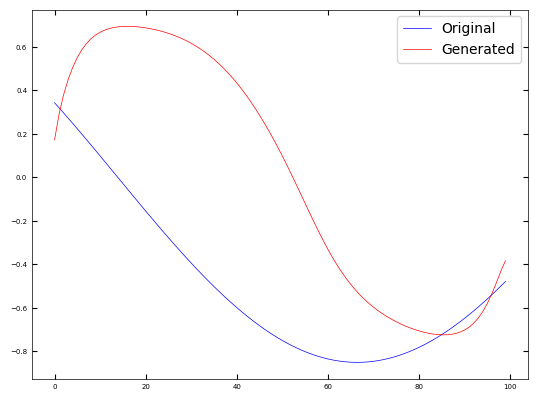

In [14]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


In [15]:
# Loads dog image

image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image

image = image[200:1900:20, 100:1500:20] / 255


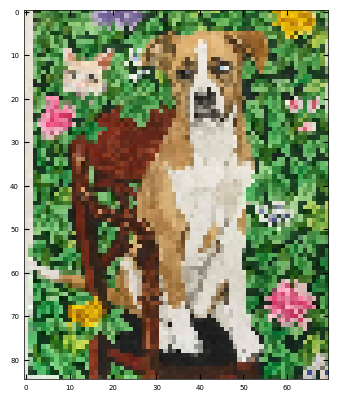

In [16]:
plt.imshow(image)


In [17]:
# Converts the image into parameters within the generated range

nala_params = np.atleast_3d(image.reshape(-1, 3))

nala_amp = torch.tensor(nala_params[:, 0, 0] * 0.8 + 0.2)
nala_phase = torch.tensor(nala_params[:, 1, 0] * 2 * np.pi)
nala_frequency = torch.tensor(nala_params[:, 2, 0] * 0.5 + 0.1)

_nala_params = torch.torch.stack((nala_amp, nala_phase, nala_frequency))

_nala_params = torch.atleast_3d(_nala_params)
_nala_params = torch.transpose(_nala_params, 0, 1)


In [18]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


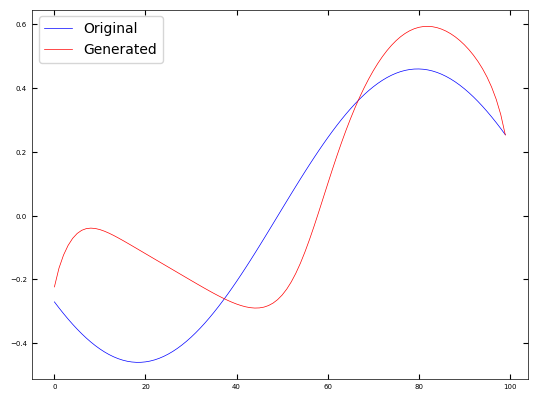

In [19]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


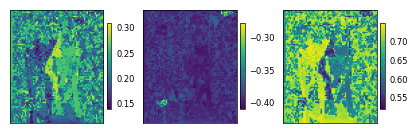

In [20]:
# Visualize the learned embeddings
embeddings(nala_encoded_, shape_=image.shape[0:2], figsize=(5, 1.25))


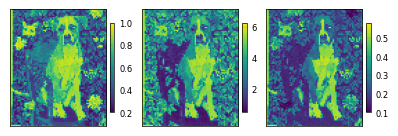

In [21]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(5, 1.25))


In [22]:
device = "cuda"
latent_dim = 12

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [23]:
# views the model

model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [24]:
# trains the model

torch.manual_seed(0)
Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.00it/s]

100%|██████████| 20/20 [00:00<00:00, 118.12it/s]

Epoch 0, Train Loss: 0.2270
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 98.76it/s]

100%|██████████| 20/20 [00:00<00:00, 93.55it/s]

Epoch 1, Train Loss: 0.2245
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.19it/s]

100%|██████████| 20/20 [00:00<00:00, 97.06it/s]

100%|██████████| 20/20 [00:00<00:00, 96.68it/s]

Epoch 2, Train Loss: 0.2225
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.49it/s]

100%|██████████| 20/20 [00:00<00:00, 96.27it/s]

100%|██████████| 20/20 [00:00<00:00, 95.99it/s]

Epoch 3, Train Loss: 0.2203
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████| 20/20 [00:00<00:00, 97.88it/s]

100%|██████████| 20/20 [00:00<00:00, 97.76it/s]

Epoch 4, Train Loss: 0.2191
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.17it/s]

100%|██████████| 20/20 [00:00<00:00, 97.22it/s]

100%|██████████| 20/20 [00:00<00:00, 97.22it/s]

Epoch 5, Train Loss: 0.2170
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.11it/s]

100%|██████████| 20/20 [00:00<00:00, 99.40it/s] 

Epoch 6, Train Loss: 0.2159
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.47it/s]

100%|██████████| 20/20 [00:00<00:00, 99.53it/s]

Epoch 7, Train Loss: 0.2144
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.10it/s]

100%|██████████| 20/20 [00:00<00:00, 96.32it/s]

100%|██████████| 20/20 [00:00<00:00, 95.82it/s]

Epoch 8, Train Loss: 0.2135
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.65it/s]

100%|██████████| 20/20 [00:00<00:00, 99.84it/s] 

Epoch 9, Train Loss: 0.2126
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.18it/s]

100%|██████████| 20/20 [00:00<00:00, 98.46it/s]

100%|██████████| 20/20 [00:00<00:00, 97.92it/s]

Epoch 10, Train Loss: 0.2119
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.76it/s]

100%|██████████| 20/20 [00:00<00:00, 98.03it/s]

100%|██████████| 20/20 [00:00<00:00, 97.61it/s]

Epoch 11, Train Loss: 0.2113
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.88it/s]

100%|██████████| 20/20 [00:00<00:00, 99.04it/s]

100%|██████████| 20/20 [00:00<00:00, 98.49it/s]

Epoch 12, Train Loss: 0.2105
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.26it/s]

100%|██████████| 20/20 [00:00<00:00, 101.89it/s]

Epoch 13, Train Loss: 0.2097
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.39it/s]

100%|██████████| 20/20 [00:00<00:00, 99.66it/s]

100%|██████████| 20/20 [00:00<00:00, 99.30it/s]

Epoch 14, Train Loss: 0.2093
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.69it/s]

100%|██████████| 20/20 [00:00<00:00, 99.45it/s]

100%|██████████| 20/20 [00:00<00:00, 99.10it/s]

Epoch 15, Train Loss: 0.2086
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.82it/s]

100%|██████████| 20/20 [00:00<00:00, 96.42it/s]

100%|██████████| 20/20 [00:00<00:00, 96.22it/s]

Epoch 16, Train Loss: 0.2088
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.46it/s]

100%|██████████| 20/20 [00:00<00:00, 100.30it/s]

Epoch 17, Train Loss: 0.2086
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.09it/s]

100%|██████████| 20/20 [00:00<00:00, 99.33it/s]

100%|██████████| 20/20 [00:00<00:00, 98.97it/s]

Epoch 18, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.68it/s]

100%|██████████| 20/20 [00:00<00:00, 98.11it/s]

100%|██████████| 20/20 [00:00<00:00, 97.63it/s]

Epoch 19, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.44it/s]

100%|██████████| 20/20 [00:00<00:00, 98.84it/s]

100%|██████████| 20/20 [00:00<00:00, 98.47it/s]

Epoch 20, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.59it/s]

100%|██████████| 20/20 [00:00<00:00, 98.47it/s]

100%|██████████| 20/20 [00:00<00:00, 97.97it/s]

Epoch 21, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.55it/s]

100%|██████████| 20/20 [00:00<00:00, 99.95it/s]

Epoch 22, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.50it/s]

100%|██████████| 20/20 [00:00<00:00, 99.75it/s] 

Epoch 23, Train Loss: 0.2085
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.78it/s]

100%|██████████| 20/20 [00:00<00:00, 98.80it/s]

100%|██████████| 20/20 [00:00<00:00, 98.65it/s]

Epoch 24, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.01it/s]

100%|██████████| 20/20 [00:00<00:00, 98.99it/s]

100%|██████████| 20/20 [00:00<00:00, 98.54it/s]

Epoch 25, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.11it/s]

100%|██████████| 20/20 [00:00<00:00, 99.22it/s]

100%|██████████| 20/20 [00:00<00:00, 98.89it/s]

Epoch 26, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.64it/s]

100%|██████████| 20/20 [00:00<00:00, 99.10it/s]

100%|██████████| 20/20 [00:00<00:00, 98.80it/s]

Epoch 27, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.58it/s]

100%|██████████| 20/20 [00:00<00:00, 98.36it/s]

100%|██████████| 20/20 [00:00<00:00, 97.87it/s]

Epoch 28, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.38it/s]

100%|██████████| 20/20 [00:00<00:00, 98.25it/s]

100%|██████████| 20/20 [00:00<00:00, 98.15it/s]

Epoch 29, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.57it/s]

100%|██████████| 20/20 [00:00<00:00, 91.34it/s]

100%|██████████| 20/20 [00:00<00:00, 91.94it/s]

Epoch 30, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 91.33it/s]

100%|██████████| 20/20 [00:00<00:00, 90.12it/s]

100%|██████████| 20/20 [00:00<00:00, 90.08it/s]

Epoch 31, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.47it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 90.31it/s]

100%|██████████| 20/20 [00:00<00:00, 89.23it/s]

Epoch 32, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 90.18it/s]

100%|██████████| 20/20 [00:00<00:00, 90.35it/s]

100%|██████████| 20/20 [00:00<00:00, 90.00it/s]

Epoch 33, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 86.44it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 91.62it/s]

100%|██████████| 20/20 [00:00<00:00, 91.53it/s]

Epoch 34, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.11it/s]

100%|██████████| 20/20 [00:00<00:00, 112.49it/s]

Epoch 35, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.69it/s]

100%|██████████| 20/20 [00:00<00:00, 114.65it/s]

Epoch 36, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.97it/s]

100%|██████████| 20/20 [00:00<00:00, 112.95it/s]

Epoch 37, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.74it/s]

100%|██████████| 20/20 [00:00<00:00, 123.26it/s]

Epoch 38, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.02it/s]

100%|██████████| 20/20 [00:00<00:00, 121.87it/s]

Epoch 39, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.03it/s]

100%|██████████| 20/20 [00:00<00:00, 120.13it/s]

Epoch 40, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 111.56it/s]

100%|██████████| 20/20 [00:00<00:00, 116.02it/s]

Epoch 41, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.18it/s]

100%|██████████| 20/20 [00:00<00:00, 118.67it/s]

Epoch 42, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 120.13it/s]

100%|██████████| 20/20 [00:00<00:00, 116.79it/s]

Epoch 43, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.78it/s]

100%|██████████| 20/20 [00:00<00:00, 115.23it/s]

Epoch 44, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.62it/s]

100%|██████████| 20/20 [00:00<00:00, 124.50it/s]

Epoch 45, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 129.00it/s]

100%|██████████| 20/20 [00:00<00:00, 128.22it/s]

Epoch 46, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.94it/s]

100%|██████████| 20/20 [00:00<00:00, 116.78it/s]

Epoch 47, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.80it/s]

100%|██████████| 20/20 [00:00<00:00, 115.62it/s]

Epoch 48, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.93it/s]

100%|██████████| 20/20 [00:00<00:00, 116.14it/s]

Epoch 49, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.78it/s]

100%|██████████| 20/20 [00:00<00:00, 119.53it/s]

Epoch 50, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.13it/s]

100%|██████████| 20/20 [00:00<00:00, 112.33it/s]

Epoch 51, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 120.41it/s]

100%|██████████| 20/20 [00:00<00:00, 121.31it/s]

Epoch 52, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.73it/s]

100%|██████████| 20/20 [00:00<00:00, 122.82it/s]

Epoch 53, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.28it/s]

100%|██████████| 20/20 [00:00<00:00, 115.92it/s]

Epoch 54, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 118.40it/s]

100%|██████████| 20/20 [00:00<00:00, 116.97it/s]

Epoch 55, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.85it/s]

100%|██████████| 20/20 [00:00<00:00, 120.12it/s]

Epoch 56, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 111.89it/s]

100%|██████████| 20/20 [00:00<00:00, 111.83it/s]

Epoch 57, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 117.07it/s]

100%|██████████| 20/20 [00:00<00:00, 119.48it/s]

Epoch 58, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.22it/s]

100%|██████████| 20/20 [00:00<00:00, 114.27it/s]

Epoch 59, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.58it/s]

100%|██████████| 20/20 [00:00<00:00, 118.00it/s]

Epoch 60, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.69it/s]

100%|██████████| 20/20 [00:00<00:00, 118.52it/s]

Epoch 61, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.61it/s]

100%|██████████| 20/20 [00:00<00:00, 118.93it/s]

Epoch 62, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.67it/s]

100%|██████████| 20/20 [00:00<00:00, 121.01it/s]

Epoch 63, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.69it/s]

100%|██████████| 20/20 [00:00<00:00, 117.80it/s]

Epoch 64, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.97it/s]

100%|██████████| 20/20 [00:00<00:00, 120.36it/s]

Epoch 65, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.24it/s]

100%|██████████| 20/20 [00:00<00:00, 117.19it/s]

Epoch 66, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 117.32it/s]

100%|██████████| 20/20 [00:00<00:00, 121.46it/s]

Epoch 67, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.14it/s]

100%|██████████| 20/20 [00:00<00:00, 117.69it/s]

Epoch 68, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.17it/s]

100%|██████████| 20/20 [00:00<00:00, 117.13it/s]

Epoch 69, Train Loss: 0.2074
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 111.57it/s]

100%|██████████| 20/20 [00:00<00:00, 114.38it/s]

Epoch 70, Train Loss: 0.2073
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.91it/s]

100%|██████████| 20/20 [00:00<00:00, 123.67it/s]

Epoch 71, Train Loss: 0.2071
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.86it/s]

100%|██████████| 20/20 [00:00<00:00, 123.55it/s]

Epoch 72, Train Loss: 0.2073
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.94it/s]

100%|██████████| 20/20 [00:00<00:00, 122.22it/s]

Epoch 73, Train Loss: 0.2067
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.66it/s]

100%|██████████| 20/20 [00:00<00:00, 123.02it/s]

Epoch 74, Train Loss: 0.2066
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.18it/s]

100%|██████████| 20/20 [00:00<00:00, 117.09it/s]

Epoch 75, Train Loss: 0.2066
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.83it/s]

100%|██████████| 20/20 [00:00<00:00, 125.72it/s]

Epoch 76, Train Loss: 0.2065
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.71it/s]

100%|██████████| 20/20 [00:00<00:00, 119.51it/s]

Epoch 77, Train Loss: 0.2061
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 125.33it/s]

100%|██████████| 20/20 [00:00<00:00, 123.46it/s]

Epoch 78, Train Loss: 0.2059
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.63it/s]

100%|██████████| 20/20 [00:00<00:00, 118.95it/s]

Epoch 79, Train Loss: 0.2053
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.54it/s]

100%|██████████| 20/20 [00:00<00:00, 121.01it/s]

Epoch 80, Train Loss: 0.2048
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.80it/s]

100%|██████████| 20/20 [00:00<00:00, 118.35it/s]

Epoch 81, Train Loss: 0.2049
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.73it/s]

100%|██████████| 20/20 [00:00<00:00, 123.47it/s]

Epoch 82, Train Loss: 0.2040
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.43it/s]

100%|██████████| 20/20 [00:00<00:00, 116.23it/s]

Epoch 83, Train Loss: 0.2034
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.33it/s]

100%|██████████| 20/20 [00:00<00:00, 119.11it/s]

Epoch 84, Train Loss: 0.2022
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.95it/s]

100%|██████████| 20/20 [00:00<00:00, 108.51it/s]

Epoch 85, Train Loss: 0.2006
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.85it/s]

100%|██████████| 20/20 [00:00<00:00, 99.87it/s] 

Epoch 86, Train Loss: 0.1996
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.44it/s]

100%|██████████| 20/20 [00:00<00:00, 96.31it/s]

100%|██████████| 20/20 [00:00<00:00, 95.63it/s]

Epoch 87, Train Loss: 0.1987
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.98it/s]

100%|██████████| 20/20 [00:00<00:00, 97.72it/s]

100%|██████████| 20/20 [00:00<00:00, 97.46it/s]

Epoch 88, Train Loss: 0.1977
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.28it/s]

100%|██████████| 20/20 [00:00<00:00, 99.19it/s]

100%|██████████| 20/20 [00:00<00:00, 98.74it/s]

Epoch 89, Train Loss: 0.1968
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.72it/s]

100%|██████████| 20/20 [00:00<00:00, 99.03it/s]

Epoch 90, Train Loss: 0.1962
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.09it/s]

100%|██████████| 20/20 [00:00<00:00, 96.44it/s]

100%|██████████| 20/20 [00:00<00:00, 95.79it/s]

Epoch 91, Train Loss: 0.1958
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.79it/s]

100%|██████████| 20/20 [00:00<00:00, 99.38it/s]

100%|██████████| 20/20 [00:00<00:00, 99.13it/s]

Epoch 92, Train Loss: 0.1942
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.83it/s]

100%|██████████| 20/20 [00:00<00:00, 98.07it/s]

100%|██████████| 20/20 [00:00<00:00, 97.44it/s]

Epoch 93, Train Loss: 0.1933
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.69it/s]

100%|██████████| 20/20 [00:00<00:00, 99.47it/s]

Epoch 94, Train Loss: 0.1919
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████| 20/20 [00:00<00:00, 97.44it/s]

100%|██████████| 20/20 [00:00<00:00, 97.31it/s]

Epoch 95, Train Loss: 0.1914
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.32it/s]

100%|██████████| 20/20 [00:00<00:00, 98.57it/s]

100%|██████████| 20/20 [00:00<00:00, 98.10it/s]

Epoch 96, Train Loss: 0.1907
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.18it/s]

100%|██████████| 20/20 [00:00<00:00, 99.96it/s] 

Epoch 97, Train Loss: 0.1902
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.22it/s]

100%|██████████| 20/20 [00:00<00:00, 97.63it/s]

100%|██████████| 20/20 [00:00<00:00, 97.61it/s]

Epoch 98, Train Loss: 0.1899
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.50it/s]

100%|██████████| 20/20 [00:00<00:00, 97.66it/s]

100%|██████████| 20/20 [00:00<00:00, 97.48it/s]

Epoch 99, Train Loss: 0.1899
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.82it/s]

100%|██████████| 20/20 [00:00<00:00, 100.04it/s]

Epoch 100, Train Loss: 0.1897
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.56it/s]

100%|██████████| 20/20 [00:00<00:00, 99.56it/s] 

Epoch 101, Train Loss: 0.1896
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.19it/s]

100%|██████████| 20/20 [00:00<00:00, 98.94it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

Epoch 102, Train Loss: 0.1891
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.01it/s]

100%|██████████| 20/20 [00:00<00:00, 100.52it/s]

Epoch 103, Train Loss: 0.1893
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.61it/s]

100%|██████████| 20/20 [00:00<00:00, 97.60it/s]

100%|██████████| 20/20 [00:00<00:00, 97.20it/s]

Epoch 104, Train Loss: 0.1880
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.79it/s]

100%|██████████| 20/20 [00:00<00:00, 98.30it/s]

100%|██████████| 20/20 [00:00<00:00, 98.05it/s]

Epoch 105, Train Loss: 0.1883
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.80it/s]

100%|██████████| 20/20 [00:00<00:00, 100.20it/s]

Epoch 106, Train Loss: 0.1880
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.71it/s]

100%|██████████| 20/20 [00:00<00:00, 97.55it/s]

Epoch 107, Train Loss: 0.1876
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.83it/s]

100%|██████████| 20/20 [00:00<00:00, 98.06it/s]

100%|██████████| 20/20 [00:00<00:00, 97.88it/s]

Epoch 108, Train Loss: 0.1870
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.53it/s]

100%|██████████| 20/20 [00:00<00:00, 98.28it/s]

100%|██████████| 20/20 [00:00<00:00, 98.01it/s]

Epoch 109, Train Loss: 0.1870
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.02it/s]

100%|██████████| 20/20 [00:00<00:00, 96.00it/s]

100%|██████████| 20/20 [00:00<00:00, 95.75it/s]

Epoch 110, Train Loss: 0.1865
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.22it/s]

100%|██████████| 20/20 [00:00<00:00, 100.02it/s]

Epoch 111, Train Loss: 0.1859
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.06it/s]

100%|██████████| 20/20 [00:00<00:00, 98.09it/s]

100%|██████████| 20/20 [00:00<00:00, 97.93it/s]

Epoch 112, Train Loss: 0.1856
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.65it/s]

100%|██████████| 20/20 [00:00<00:00, 98.98it/s]

Epoch 113, Train Loss: 0.1857
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.17it/s]

100%|██████████| 20/20 [00:00<00:00, 96.97it/s]

100%|██████████| 20/20 [00:00<00:00, 96.49it/s]

Epoch 114, Train Loss: 0.1849
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.28it/s]

100%|██████████| 20/20 [00:00<00:00, 96.90it/s]

100%|██████████| 20/20 [00:00<00:00, 96.93it/s]

Epoch 115, Train Loss: 0.1840
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.39it/s]

100%|██████████| 20/20 [00:00<00:00, 98.29it/s]

100%|██████████| 20/20 [00:00<00:00, 97.67it/s]

Epoch 116, Train Loss: 0.1835
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.46it/s]

100%|██████████| 20/20 [00:00<00:00, 98.90it/s] 

Epoch 117, Train Loss: 0.1836
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.04it/s]

100%|██████████| 20/20 [00:00<00:00, 95.95it/s]

100%|██████████| 20/20 [00:00<00:00, 95.85it/s]

Epoch 118, Train Loss: 0.1831
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.81it/s]

100%|██████████| 20/20 [00:00<00:00, 99.94it/s] 

Epoch 119, Train Loss: 0.1824
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.51it/s]

100%|██████████| 20/20 [00:00<00:00, 98.05it/s]

100%|██████████| 20/20 [00:00<00:00, 97.45it/s]

Epoch 120, Train Loss: 0.1822
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.91it/s]

100%|██████████| 20/20 [00:00<00:00, 95.28it/s]

100%|██████████| 20/20 [00:00<00:00, 95.35it/s]

Epoch 121, Train Loss: 0.1818
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.22it/s]

100%|██████████| 20/20 [00:00<00:00, 93.74it/s]

100%|██████████| 20/20 [00:00<00:00, 94.23it/s]

Epoch 122, Train Loss: 0.1816
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.88it/s]

100%|██████████| 20/20 [00:00<00:00, 99.96it/s]

Epoch 123, Train Loss: 0.1812
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.36it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.03it/s]

Epoch 124, Train Loss: 0.1813
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.44it/s]

100%|██████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████| 20/20 [00:00<00:00, 96.45it/s]

Epoch 125, Train Loss: 0.1807
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 98.32it/s]

100%|██████████| 20/20 [00:00<00:00, 97.89it/s]

Epoch 126, Train Loss: 0.1803
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.24it/s]

100%|██████████| 20/20 [00:00<00:00, 98.45it/s]

100%|██████████| 20/20 [00:00<00:00, 97.89it/s]

Epoch 127, Train Loss: 0.1802
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.00it/s]

100%|██████████| 20/20 [00:00<00:00, 95.40it/s]

100%|██████████| 20/20 [00:00<00:00, 95.05it/s]

Epoch 128, Train Loss: 0.1801
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.42it/s]

100%|██████████| 20/20 [00:00<00:00, 96.57it/s]

100%|██████████| 20/20 [00:00<00:00, 96.58it/s]

Epoch 129, Train Loss: 0.1797
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.50it/s]

100%|██████████| 20/20 [00:00<00:00, 97.94it/s]

Epoch 130, Train Loss: 0.1794
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.55it/s]

100%|██████████| 20/20 [00:00<00:00, 97.66it/s] 

Epoch 131, Train Loss: 0.1791
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.35it/s]

100%|██████████| 20/20 [00:00<00:00, 98.37it/s] 

Epoch 132, Train Loss: 0.1788
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.43it/s]

100%|██████████| 20/20 [00:00<00:00, 99.84it/s]

Epoch 133, Train Loss: 0.1785
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.42it/s]

100%|██████████| 20/20 [00:00<00:00, 98.04it/s]

100%|██████████| 20/20 [00:00<00:00, 97.93it/s]

Epoch 134, Train Loss: 0.1783
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.52it/s]

100%|██████████| 20/20 [00:00<00:00, 97.38it/s]

Epoch 135, Train Loss: 0.1778
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.03it/s]

100%|██████████| 20/20 [00:00<00:00, 96.50it/s]

100%|██████████| 20/20 [00:00<00:00, 96.05it/s]

Epoch 136, Train Loss: 0.1780
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 89.38it/s]

 90%|█████████ | 18/20 [00:00<00:00, 88.73it/s]

100%|██████████| 20/20 [00:00<00:00, 87.83it/s]

Epoch 137, Train Loss: 0.1776
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 107.27it/s]

100%|██████████| 20/20 [00:00<00:00, 112.81it/s]

Epoch 138, Train Loss: 0.1773
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.61it/s]

100%|██████████| 20/20 [00:00<00:00, 115.62it/s]

Epoch 139, Train Loss: 0.1767
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.36it/s]

100%|██████████| 20/20 [00:00<00:00, 117.22it/s]

Epoch 140, Train Loss: 0.1760
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.00it/s]

100%|██████████| 20/20 [00:00<00:00, 121.24it/s]

Epoch 141, Train Loss: 0.1759
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 128.24it/s]

100%|██████████| 20/20 [00:00<00:00, 128.68it/s]

Epoch 142, Train Loss: 0.1757
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 119.74it/s]

100%|██████████| 20/20 [00:00<00:00, 122.15it/s]

Epoch 143, Train Loss: 0.1741
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 125.38it/s]

100%|██████████| 20/20 [00:00<00:00, 122.82it/s]

Epoch 144, Train Loss: 0.1740
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 119.13it/s]

100%|██████████| 20/20 [00:00<00:00, 120.12it/s]

Epoch 145, Train Loss: 0.1725
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 109.62it/s]

100%|██████████| 20/20 [00:00<00:00, 105.04it/s]

Epoch 146, Train Loss: 0.1714
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.12it/s]

100%|██████████| 20/20 [00:00<00:00, 99.79it/s]

Epoch 147, Train Loss: 0.1699
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.13it/s]

100%|██████████| 20/20 [00:00<00:00, 98.27it/s] 

Epoch 148, Train Loss: 0.1684
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.13it/s]

100%|██████████| 20/20 [00:00<00:00, 95.87it/s]

100%|██████████| 20/20 [00:00<00:00, 95.77it/s]

Epoch 149, Train Loss: 0.1659
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 98.45it/s]

100%|██████████| 20/20 [00:00<00:00, 98.60it/s]

Epoch 150, Train Loss: 0.1635
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.56it/s]

100%|██████████| 20/20 [00:00<00:00, 100.54it/s]

Epoch 151, Train Loss: 0.1618
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.52it/s]

100%|██████████| 20/20 [00:00<00:00, 97.27it/s]

100%|██████████| 20/20 [00:00<00:00, 96.94it/s]

Epoch 152, Train Loss: 0.1597
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 107.45it/s]

100%|██████████| 20/20 [00:00<00:00, 114.32it/s]

Epoch 153, Train Loss: 0.1581
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.92it/s]

100%|██████████| 20/20 [00:00<00:00, 97.33it/s]

100%|██████████| 20/20 [00:00<00:00, 97.01it/s]

Epoch 154, Train Loss: 0.1563
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.77it/s]

100%|██████████| 20/20 [00:00<00:00, 95.86it/s]

100%|██████████| 20/20 [00:00<00:00, 95.70it/s]

Epoch 155, Train Loss: 0.1546
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.03it/s]

100%|██████████| 20/20 [00:00<00:00, 98.10it/s]

100%|██████████| 20/20 [00:00<00:00, 97.53it/s]

Epoch 156, Train Loss: 0.1530
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.96it/s]

100%|██████████| 20/20 [00:00<00:00, 96.56it/s]

100%|██████████| 20/20 [00:00<00:00, 96.02it/s]

Epoch 157, Train Loss: 0.1523
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.75it/s]

100%|██████████| 20/20 [00:00<00:00, 100.22it/s]

Epoch 158, Train Loss: 0.1515
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.91it/s]

100%|██████████| 20/20 [00:00<00:00, 98.45it/s]

Epoch 159, Train Loss: 0.1506
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.50it/s]

100%|██████████| 20/20 [00:00<00:00, 99.35it/s]

Epoch 160, Train Loss: 0.1501
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.34it/s]

100%|██████████| 20/20 [00:00<00:00, 100.07it/s]

Epoch 161, Train Loss: 0.1487
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.16it/s]

100%|██████████| 20/20 [00:00<00:00, 98.30it/s]

100%|██████████| 20/20 [00:00<00:00, 98.01it/s]

Epoch 162, Train Loss: 0.1479
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.71it/s]

100%|██████████| 20/20 [00:00<00:00, 98.78it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

Epoch 163, Train Loss: 0.1472
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.03it/s]

100%|██████████| 20/20 [00:00<00:00, 99.33it/s] 

Epoch 164, Train Loss: 0.1468
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.57it/s]

100%|██████████| 20/20 [00:00<00:00, 99.38it/s]

100%|██████████| 20/20 [00:00<00:00, 99.03it/s]

Epoch 165, Train Loss: 0.1471
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.31it/s]

100%|██████████| 20/20 [00:00<00:00, 98.39it/s]

Epoch 166, Train Loss: 0.1458
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.12it/s]

100%|██████████| 20/20 [00:00<00:00, 100.88it/s]

Epoch 167, Train Loss: 0.1452
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.22it/s]

100%|██████████| 20/20 [00:00<00:00, 98.97it/s]

Epoch 168, Train Loss: 0.1449
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.61it/s]

100%|██████████| 20/20 [00:00<00:00, 100.05it/s]

Epoch 169, Train Loss: 0.1444
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.89it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

100%|██████████| 20/20 [00:00<00:00, 97.82it/s]

Epoch 170, Train Loss: 0.1447
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.73it/s]

100%|██████████| 20/20 [00:00<00:00, 98.82it/s]

100%|██████████| 20/20 [00:00<00:00, 98.39it/s]

Epoch 171, Train Loss: 0.1441
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.06it/s]

100%|██████████| 20/20 [00:00<00:00, 98.67it/s]

100%|██████████| 20/20 [00:00<00:00, 98.09it/s]

Epoch 172, Train Loss: 0.1437
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.94it/s]

100%|██████████| 20/20 [00:00<00:00, 98.44it/s]

Epoch 173, Train Loss: 0.1436
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████| 20/20 [00:00<00:00, 97.67it/s]

100%|██████████| 20/20 [00:00<00:00, 97.49it/s]

Epoch 174, Train Loss: 0.1428
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.88it/s]

100%|██████████| 20/20 [00:00<00:00, 99.93it/s] 

Epoch 175, Train Loss: 0.1432
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.70it/s]

100%|██████████| 20/20 [00:00<00:00, 97.72it/s]

100%|██████████| 20/20 [00:00<00:00, 97.63it/s]

Epoch 176, Train Loss: 0.1432
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.20it/s]

100%|██████████| 20/20 [00:00<00:00, 96.36it/s]

100%|██████████| 20/20 [00:00<00:00, 96.19it/s]

Epoch 177, Train Loss: 0.1428
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.92it/s]

100%|██████████| 20/20 [00:00<00:00, 97.23it/s]

100%|██████████| 20/20 [00:00<00:00, 97.07it/s]

Epoch 178, Train Loss: 0.1423
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.01it/s]

100%|██████████| 20/20 [00:00<00:00, 100.66it/s]

Epoch 179, Train Loss: 0.1422
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.36it/s]

100%|██████████| 20/20 [00:00<00:00, 96.52it/s]

100%|██████████| 20/20 [00:00<00:00, 95.87it/s]

Epoch 180, Train Loss: 0.1418
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.01it/s]

100%|██████████| 20/20 [00:00<00:00, 97.26it/s]

100%|██████████| 20/20 [00:00<00:00, 96.47it/s]

Epoch 181, Train Loss: 0.1422
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.73it/s]

100%|██████████| 20/20 [00:00<00:00, 101.52it/s]

Epoch 182, Train Loss: 0.1423
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.44it/s]

100%|██████████| 20/20 [00:00<00:00, 98.74it/s]

Epoch 183, Train Loss: 0.1424
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.18it/s]

100%|██████████| 20/20 [00:00<00:00, 99.53it/s]

Epoch 184, Train Loss: 0.1418
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.81it/s]

100%|██████████| 20/20 [00:00<00:00, 99.29it/s] 

Epoch 185, Train Loss: 0.1420
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.32it/s]

100%|██████████| 20/20 [00:00<00:00, 99.49it/s] 

Epoch 186, Train Loss: 0.1409
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.06it/s]

100%|██████████| 20/20 [00:00<00:00, 98.03it/s]

Epoch 187, Train Loss: 0.1406
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 93.13it/s]

100%|██████████| 20/20 [00:00<00:00, 97.11it/s]

Epoch 188, Train Loss: 0.1403
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.52it/s]

100%|██████████| 20/20 [00:00<00:00, 99.98it/s] 

Epoch 189, Train Loss: 0.1402
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.24it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.12it/s]

Epoch 190, Train Loss: 0.1402
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.06it/s]

100%|██████████| 20/20 [00:00<00:00, 98.61it/s]

100%|██████████| 20/20 [00:00<00:00, 98.06it/s]

Epoch 191, Train Loss: 0.1397
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.58it/s]

100%|██████████| 20/20 [00:00<00:00, 99.21it/s]

100%|██████████| 20/20 [00:00<00:00, 98.79it/s]

Epoch 192, Train Loss: 0.1399
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.88it/s]

100%|██████████| 20/20 [00:00<00:00, 99.24it/s]

100%|██████████| 20/20 [00:00<00:00, 98.88it/s]

Epoch 193, Train Loss: 0.1399
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.83it/s]

100%|██████████| 20/20 [00:00<00:00, 97.69it/s]

100%|██████████| 20/20 [00:00<00:00, 97.25it/s]

Epoch 194, Train Loss: 0.1399
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.59it/s]

100%|██████████| 20/20 [00:00<00:00, 97.19it/s]

100%|██████████| 20/20 [00:00<00:00, 96.99it/s]

Epoch 195, Train Loss: 0.1393
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.91it/s]

100%|██████████| 20/20 [00:00<00:00, 99.14it/s]

Epoch 196, Train Loss: 0.1394
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.86it/s]

100%|██████████| 20/20 [00:00<00:00, 100.96it/s]

Epoch 197, Train Loss: 0.1390
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.28it/s]

100%|██████████| 20/20 [00:00<00:00, 98.60it/s] 

Epoch 198, Train Loss: 0.1389
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.71it/s]

100%|██████████| 20/20 [00:00<00:00, 98.36it/s]

100%|██████████| 20/20 [00:00<00:00, 97.89it/s]

Epoch 199, Train Loss: 0.1388
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.64it/s]

100%|██████████| 20/20 [00:00<00:00, 98.43it/s] 

Epoch 200, Train Loss: 0.1389
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.22it/s]

100%|██████████| 20/20 [00:00<00:00, 99.58it/s] 

Epoch 201, Train Loss: 0.1385
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.86it/s]

100%|██████████| 20/20 [00:00<00:00, 99.94it/s]

100%|██████████| 20/20 [00:00<00:00, 99.54it/s]

Epoch 202, Train Loss: 0.1384
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.85it/s]

100%|██████████| 20/20 [00:00<00:00, 97.90it/s]

100%|██████████| 20/20 [00:00<00:00, 97.37it/s]

Epoch 203, Train Loss: 0.1379
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.94it/s]

100%|██████████| 20/20 [00:00<00:00, 98.78it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

Epoch 204, Train Loss: 0.1383
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.93it/s]

100%|██████████| 20/20 [00:00<00:00, 100.00it/s]

Epoch 205, Train Loss: 0.1379
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.72it/s]

100%|██████████| 20/20 [00:00<00:00, 97.42it/s]

100%|██████████| 20/20 [00:00<00:00, 97.46it/s]

Epoch 206, Train Loss: 0.1374
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.79it/s]

100%|██████████| 20/20 [00:00<00:00, 98.74it/s]

100%|██████████| 20/20 [00:00<00:00, 98.35it/s]

Epoch 207, Train Loss: 0.1375
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.50it/s]

100%|██████████| 20/20 [00:00<00:00, 101.84it/s]

Epoch 208, Train Loss: 0.1374
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.57it/s]

100%|██████████| 20/20 [00:00<00:00, 98.96it/s]

100%|██████████| 20/20 [00:00<00:00, 98.77it/s]

Epoch 209, Train Loss: 0.1372
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.02it/s]

100%|██████████| 20/20 [00:00<00:00, 98.72it/s]

Epoch 210, Train Loss: 0.1370
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.77it/s]

100%|██████████| 20/20 [00:00<00:00, 97.98it/s]

100%|██████████| 20/20 [00:00<00:00, 97.58it/s]

Epoch 211, Train Loss: 0.1366
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.52it/s]

100%|██████████| 20/20 [00:00<00:00, 97.37it/s]

100%|██████████| 20/20 [00:00<00:00, 97.07it/s]

Epoch 212, Train Loss: 0.1365
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.48it/s]

100%|██████████| 20/20 [00:00<00:00, 97.53it/s]

Epoch 213, Train Loss: 0.1364
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.66it/s]

100%|██████████| 20/20 [00:00<00:00, 97.17it/s]

100%|██████████| 20/20 [00:00<00:00, 96.94it/s]

Epoch 214, Train Loss: 0.1366
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.70it/s]

100%|██████████| 20/20 [00:00<00:00, 96.35it/s]

100%|██████████| 20/20 [00:00<00:00, 96.05it/s]

Epoch 215, Train Loss: 0.1360
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.46it/s]

100%|██████████| 20/20 [00:00<00:00, 96.07it/s]

100%|██████████| 20/20 [00:00<00:00, 95.60it/s]

Epoch 216, Train Loss: 0.1358
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.29it/s]

100%|██████████| 20/20 [00:00<00:00, 99.24it/s]

Epoch 217, Train Loss: 0.1358
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.47it/s]

100%|██████████| 20/20 [00:00<00:00, 99.26it/s]

100%|██████████| 20/20 [00:00<00:00, 98.97it/s]

Epoch 218, Train Loss: 0.1353
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.60it/s]

100%|██████████| 20/20 [00:00<00:00, 97.03it/s]

100%|██████████| 20/20 [00:00<00:00, 97.07it/s]

Epoch 219, Train Loss: 0.1357
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.89it/s]

100%|██████████| 20/20 [00:00<00:00, 93.91it/s]

100%|██████████| 20/20 [00:00<00:00, 93.78it/s]

Epoch 220, Train Loss: 0.1353
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.88it/s]

100%|██████████| 20/20 [00:00<00:00, 97.72it/s]

100%|██████████| 20/20 [00:00<00:00, 97.38it/s]

Epoch 221, Train Loss: 0.1350
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.02it/s]

100%|██████████| 20/20 [00:00<00:00, 100.95it/s]

Epoch 222, Train Loss: 0.1349
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.73it/s]

100%|██████████| 20/20 [00:00<00:00, 98.55it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

Epoch 223, Train Loss: 0.1345
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.47it/s]

100%|██████████| 20/20 [00:00<00:00, 98.81it/s]

100%|██████████| 20/20 [00:00<00:00, 98.38it/s]

Epoch 224, Train Loss: 0.1339
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.15it/s]

100%|██████████| 20/20 [00:00<00:00, 98.37it/s]

100%|██████████| 20/20 [00:00<00:00, 97.92it/s]

Epoch 225, Train Loss: 0.1338
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.63it/s]

100%|██████████| 20/20 [00:00<00:00, 96.86it/s] 

Epoch 226, Train Loss: 0.1333
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 109.61it/s]

100%|██████████| 20/20 [00:00<00:00, 115.27it/s]

Epoch 227, Train Loss: 0.1331
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.61it/s]

100%|██████████| 20/20 [00:00<00:00, 111.65it/s]

Epoch 228, Train Loss: 0.1328
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.25it/s]

100%|██████████| 20/20 [00:00<00:00, 117.69it/s]

Epoch 229, Train Loss: 0.1328
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.34it/s]

100%|██████████| 20/20 [00:00<00:00, 116.08it/s]

Epoch 230, Train Loss: 0.1326
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 108.95it/s]

100%|██████████| 20/20 [00:00<00:00, 98.42it/s] 

Epoch 231, Train Loss: 0.1320
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.91it/s]

 90%|█████████ | 18/20 [00:00<00:00, 89.00it/s]

100%|██████████| 20/20 [00:00<00:00, 89.91it/s]

Epoch 232, Train Loss: 0.1318
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.44it/s]

100%|██████████| 20/20 [00:00<00:00, 98.32it/s] 

Epoch 233, Train Loss: 0.1317
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████| 20/20 [00:00<00:00, 98.15it/s]

100%|██████████| 20/20 [00:00<00:00, 97.61it/s]

Epoch 234, Train Loss: 0.1310
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.54it/s]

100%|██████████| 20/20 [00:00<00:00, 98.76it/s]

100%|██████████| 20/20 [00:00<00:00, 98.57it/s]

Epoch 235, Train Loss: 0.1309
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.34it/s]

100%|██████████| 20/20 [00:00<00:00, 96.18it/s]

100%|██████████| 20/20 [00:00<00:00, 96.38it/s]

Epoch 236, Train Loss: 0.1303
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.37it/s]

100%|██████████| 20/20 [00:00<00:00, 99.81it/s] 

Epoch 237, Train Loss: 0.1299
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.02it/s]

100%|██████████| 20/20 [00:00<00:00, 96.72it/s]

100%|██████████| 20/20 [00:00<00:00, 96.26it/s]

Epoch 238, Train Loss: 0.1298
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.62it/s]

100%|██████████| 20/20 [00:00<00:00, 99.79it/s]

Epoch 239, Train Loss: 0.1296
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.96it/s]

100%|██████████| 20/20 [00:00<00:00, 98.81it/s]

100%|██████████| 20/20 [00:00<00:00, 98.37it/s]

Epoch 240, Train Loss: 0.1288
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.30it/s]

100%|██████████| 20/20 [00:00<00:00, 99.21it/s]

Epoch 241, Train Loss: 0.1281
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.28it/s]

100%|██████████| 20/20 [00:00<00:00, 97.52it/s]

100%|██████████| 20/20 [00:00<00:00, 97.31it/s]

Epoch 242, Train Loss: 0.1279
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.18it/s]

100%|██████████| 20/20 [00:00<00:00, 96.51it/s]

100%|██████████| 20/20 [00:00<00:00, 96.58it/s]

Epoch 243, Train Loss: 0.1274
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.30it/s]

100%|██████████| 20/20 [00:00<00:00, 101.73it/s]

Epoch 244, Train Loss: 0.1269
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.59it/s]

100%|██████████| 20/20 [00:00<00:00, 99.79it/s]

100%|██████████| 20/20 [00:00<00:00, 99.44it/s]

Epoch 245, Train Loss: 0.1263
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.83it/s]

100%|██████████| 20/20 [00:00<00:00, 98.81it/s]

100%|██████████| 20/20 [00:00<00:00, 98.71it/s]

Epoch 246, Train Loss: 0.1256
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████| 20/20 [00:00<00:00, 98.69it/s]

Epoch 247, Train Loss: 0.1250
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.38it/s]

100%|██████████| 20/20 [00:00<00:00, 99.07it/s]

Epoch 248, Train Loss: 0.1244
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.97it/s]

100%|██████████| 20/20 [00:00<00:00, 95.50it/s]

100%|██████████| 20/20 [00:00<00:00, 95.55it/s]

Epoch 249, Train Loss: 0.1237
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.34it/s]

100%|██████████| 20/20 [00:00<00:00, 97.75it/s]

100%|██████████| 20/20 [00:00<00:00, 97.41it/s]

Epoch 250, Train Loss: 0.1225
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.68it/s]

100%|██████████| 20/20 [00:00<00:00, 100.01it/s]

Epoch 251, Train Loss: 0.1217
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.42it/s]

100%|██████████| 20/20 [00:00<00:00, 98.13it/s]

100%|██████████| 20/20 [00:00<00:00, 97.87it/s]

Epoch 252, Train Loss: 0.1206
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.67it/s]

100%|██████████| 20/20 [00:00<00:00, 100.33it/s]

Epoch 253, Train Loss: 0.1202
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.56it/s]

100%|██████████| 20/20 [00:00<00:00, 97.51it/s]

100%|██████████| 20/20 [00:00<00:00, 97.40it/s]

Epoch 254, Train Loss: 0.1188
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 97.84it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

Epoch 255, Train Loss: 0.1174
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.65it/s]

100%|██████████| 20/20 [00:00<00:00, 97.40it/s]

Epoch 256, Train Loss: 0.1160
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.68it/s]

100%|██████████| 20/20 [00:00<00:00, 98.10it/s]

100%|██████████| 20/20 [00:00<00:00, 97.65it/s]

Epoch 257, Train Loss: 0.1156
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████| 20/20 [00:00<00:00, 98.72it/s]

Epoch 258, Train Loss: 0.1147
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.12it/s]

100%|██████████| 20/20 [00:00<00:00, 98.97it/s]

100%|██████████| 20/20 [00:00<00:00, 98.71it/s]

Epoch 259, Train Loss: 0.1135
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████| 20/20 [00:00<00:00, 99.93it/s]

Epoch 260, Train Loss: 0.1132
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.06it/s]

100%|██████████| 20/20 [00:00<00:00, 99.09it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

Epoch 261, Train Loss: 0.1117
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.07it/s]

100%|██████████| 20/20 [00:00<00:00, 98.71it/s] 

Epoch 262, Train Loss: 0.1109
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.43it/s]

100%|██████████| 20/20 [00:00<00:00, 101.60it/s]

Epoch 263, Train Loss: 0.1101
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.21it/s]

100%|██████████| 20/20 [00:00<00:00, 100.66it/s]

Epoch 264, Train Loss: 0.1094
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.93it/s]

100%|██████████| 20/20 [00:00<00:00, 99.49it/s]

100%|██████████| 20/20 [00:00<00:00, 99.18it/s]

Epoch 265, Train Loss: 0.1087
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 107.43it/s]

100%|██████████| 20/20 [00:00<00:00, 101.78it/s]

Epoch 266, Train Loss: 0.1080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.91it/s]

100%|██████████| 20/20 [00:00<00:00, 99.64it/s]

100%|██████████| 20/20 [00:00<00:00, 99.40it/s]

Epoch 267, Train Loss: 0.1077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.32it/s]

100%|██████████| 20/20 [00:00<00:00, 97.63it/s]

100%|██████████| 20/20 [00:00<00:00, 97.35it/s]

Epoch 268, Train Loss: 0.1069
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.84it/s]

100%|██████████| 20/20 [00:00<00:00, 100.57it/s]

Epoch 269, Train Loss: 0.1062
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.10it/s]

100%|██████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████| 20/20 [00:00<00:00, 97.77it/s]

Epoch 270, Train Loss: 0.1063
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.92it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

Epoch 271, Train Loss: 0.1058
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.66it/s]

100%|██████████| 20/20 [00:00<00:00, 98.08it/s]

100%|██████████| 20/20 [00:00<00:00, 97.94it/s]

Epoch 272, Train Loss: 0.1048
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.83it/s]

100%|██████████| 20/20 [00:00<00:00, 97.18it/s]

100%|██████████| 20/20 [00:00<00:00, 96.85it/s]

Epoch 273, Train Loss: 0.1043
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.73it/s]

100%|██████████| 20/20 [00:00<00:00, 94.21it/s]

100%|██████████| 20/20 [00:00<00:00, 94.08it/s]

Epoch 274, Train Loss: 0.1043
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.43it/s]

100%|██████████| 20/20 [00:00<00:00, 98.87it/s] 

Epoch 275, Train Loss: 0.1042
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.90it/s]

100%|██████████| 20/20 [00:00<00:00, 97.97it/s]

100%|██████████| 20/20 [00:00<00:00, 97.66it/s]

Epoch 276, Train Loss: 0.1029
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.68it/s]

100%|██████████| 20/20 [00:00<00:00, 100.46it/s]

Epoch 277, Train Loss: 0.1019
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.34it/s]

100%|██████████| 20/20 [00:00<00:00, 98.77it/s]

100%|██████████| 20/20 [00:00<00:00, 98.24it/s]

Epoch 278, Train Loss: 0.1014
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.71it/s]

100%|██████████| 20/20 [00:00<00:00, 99.88it/s]

Epoch 279, Train Loss: 0.1008
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.73it/s]

100%|██████████| 20/20 [00:00<00:00, 99.83it/s]

Epoch 280, Train Loss: 0.1010
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.36it/s]

100%|██████████| 20/20 [00:00<00:00, 99.65it/s]

100%|██████████| 20/20 [00:00<00:00, 99.35it/s]

Epoch 281, Train Loss: 0.1002
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.33it/s]

100%|██████████| 20/20 [00:00<00:00, 100.53it/s]

Epoch 282, Train Loss: 0.0998
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.40it/s]

100%|██████████| 20/20 [00:00<00:00, 100.85it/s]

Epoch 283, Train Loss: 0.0998
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.31it/s]

100%|██████████| 20/20 [00:00<00:00, 98.19it/s]

100%|██████████| 20/20 [00:00<00:00, 97.81it/s]

Epoch 284, Train Loss: 0.0990
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.36it/s]

100%|██████████| 20/20 [00:00<00:00, 99.23it/s]

Epoch 285, Train Loss: 0.0988
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.32it/s]

100%|██████████| 20/20 [00:00<00:00, 99.45it/s] 

Epoch 286, Train Loss: 0.0987
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.34it/s]

100%|██████████| 20/20 [00:00<00:00, 102.16it/s]

Epoch 287, Train Loss: 0.0985
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.58it/s]

100%|██████████| 20/20 [00:00<00:00, 100.13it/s]

Epoch 288, Train Loss: 0.0979
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.28it/s]

100%|██████████| 20/20 [00:00<00:00, 99.50it/s]

100%|██████████| 20/20 [00:00<00:00, 99.16it/s]

Epoch 289, Train Loss: 0.0979
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.41it/s]

100%|██████████| 20/20 [00:00<00:00, 98.61it/s]

Epoch 290, Train Loss: 0.0974
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.59it/s]

100%|██████████| 20/20 [00:00<00:00, 99.75it/s]

100%|██████████| 20/20 [00:00<00:00, 99.45it/s]

Epoch 291, Train Loss: 0.0970
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.51it/s]

100%|██████████| 20/20 [00:00<00:00, 98.52it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

Epoch 292, Train Loss: 0.0978
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.18it/s]

100%|██████████| 20/20 [00:00<00:00, 100.40it/s]

Epoch 293, Train Loss: 0.0975
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.70it/s]

100%|██████████| 20/20 [00:00<00:00, 99.55it/s]

100%|██████████| 20/20 [00:00<00:00, 99.29it/s]

Epoch 294, Train Loss: 0.0965
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.65it/s]

100%|██████████| 20/20 [00:00<00:00, 98.20it/s]

100%|██████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 295, Train Loss: 0.0963
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.74it/s]

100%|██████████| 20/20 [00:00<00:00, 98.98it/s] 

Epoch 296, Train Loss: 0.0958
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.88it/s]

100%|██████████| 20/20 [00:00<00:00, 100.49it/s]

Epoch 297, Train Loss: 0.0956
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.31it/s]

100%|██████████| 20/20 [00:00<00:00, 100.61it/s]

Epoch 298, Train Loss: 0.0957
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.54it/s]

100%|██████████| 20/20 [00:00<00:00, 97.95it/s]

100%|██████████| 20/20 [00:00<00:00, 97.28it/s]

Epoch 299, Train Loss: 0.0954
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.59it/s]

100%|██████████| 20/20 [00:00<00:00, 97.46it/s]

100%|██████████| 20/20 [00:00<00:00, 97.36it/s]

Epoch 300, Train Loss: 0.0955
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.38it/s]

100%|██████████| 20/20 [00:00<00:00, 99.28it/s]

100%|██████████| 20/20 [00:00<00:00, 98.83it/s]

Epoch 301, Train Loss: 0.0950
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.56it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

100%|██████████| 20/20 [00:00<00:00, 98.09it/s]

Epoch 302, Train Loss: 0.0956
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.42it/s]

100%|██████████| 20/20 [00:00<00:00, 97.44it/s]

100%|██████████| 20/20 [00:00<00:00, 97.01it/s]

Epoch 303, Train Loss: 0.0956
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.70it/s]

100%|██████████| 20/20 [00:00<00:00, 97.32it/s]

100%|██████████| 20/20 [00:00<00:00, 96.95it/s]

Epoch 304, Train Loss: 0.0953
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.11it/s]

100%|██████████| 20/20 [00:00<00:00, 94.23it/s]

100%|██████████| 20/20 [00:00<00:00, 94.58it/s]

Epoch 305, Train Loss: 0.0942
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 90.13it/s]

100%|██████████| 20/20 [00:00<00:00, 98.57it/s]

Epoch 306, Train Loss: 0.0943
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.70it/s]

100%|██████████| 20/20 [00:00<00:00, 121.09it/s]

Epoch 307, Train Loss: 0.0943
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 117.50it/s]

100%|██████████| 20/20 [00:00<00:00, 116.80it/s]

Epoch 308, Train Loss: 0.0940
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.28it/s]

100%|██████████| 20/20 [00:00<00:00, 117.81it/s]

Epoch 309, Train Loss: 0.0937
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.05it/s]

100%|██████████| 20/20 [00:00<00:00, 116.08it/s]

Epoch 310, Train Loss: 0.0935
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.85it/s]

100%|██████████| 20/20 [00:00<00:00, 118.93it/s]

Epoch 311, Train Loss: 0.0937
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.44it/s]

100%|██████████| 20/20 [00:00<00:00, 116.45it/s]

Epoch 312, Train Loss: 0.0943
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.79it/s]

100%|██████████| 20/20 [00:00<00:00, 119.05it/s]

Epoch 313, Train Loss: 0.0935
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.81it/s]

100%|██████████| 20/20 [00:00<00:00, 115.81it/s]

Epoch 314, Train Loss: 0.0932
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.50it/s]

100%|██████████| 20/20 [00:00<00:00, 124.75it/s]

Epoch 315, Train Loss: 0.0927
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 109.77it/s]

100%|██████████| 20/20 [00:00<00:00, 112.95it/s]

Epoch 316, Train Loss: 0.0926
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 111.63it/s]

100%|██████████| 20/20 [00:00<00:00, 116.69it/s]

Epoch 317, Train Loss: 0.0927
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.14it/s]

100%|██████████| 20/20 [00:00<00:00, 121.50it/s]

Epoch 318, Train Loss: 0.0926
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 108.70it/s]

100%|██████████| 20/20 [00:00<00:00, 113.58it/s]

Epoch 319, Train Loss: 0.0928
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.27it/s]

100%|██████████| 20/20 [00:00<00:00, 113.74it/s]

Epoch 320, Train Loss: 0.0924
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.61it/s]

100%|██████████| 20/20 [00:00<00:00, 120.58it/s]

Epoch 321, Train Loss: 0.0923
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.57it/s]

100%|██████████| 20/20 [00:00<00:00, 121.83it/s]

Epoch 322, Train Loss: 0.0923
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.57it/s]

100%|██████████| 20/20 [00:00<00:00, 111.62it/s]

Epoch 323, Train Loss: 0.0924
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.33it/s]

100%|██████████| 20/20 [00:00<00:00, 96.85it/s]

100%|██████████| 20/20 [00:00<00:00, 96.72it/s]

Epoch 324, Train Loss: 0.0917
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.73it/s]

100%|██████████| 20/20 [00:00<00:00, 97.04it/s]

100%|██████████| 20/20 [00:00<00:00, 96.76it/s]

Epoch 325, Train Loss: 0.0916
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.45it/s]

100%|██████████| 20/20 [00:00<00:00, 96.40it/s]

100%|██████████| 20/20 [00:00<00:00, 96.17it/s]

Epoch 326, Train Loss: 0.0913
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.10it/s]

100%|██████████| 20/20 [00:00<00:00, 98.59it/s]

100%|██████████| 20/20 [00:00<00:00, 98.34it/s]

Epoch 327, Train Loss: 0.0914
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.51it/s]

100%|██████████| 20/20 [00:00<00:00, 98.01it/s]

100%|██████████| 20/20 [00:00<00:00, 97.49it/s]

Epoch 328, Train Loss: 0.0917
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.36it/s]

100%|██████████| 20/20 [00:00<00:00, 97.54it/s]

100%|██████████| 20/20 [00:00<00:00, 97.13it/s]

Epoch 329, Train Loss: 0.0913
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.09it/s]

100%|██████████| 20/20 [00:00<00:00, 96.94it/s]

100%|██████████| 20/20 [00:00<00:00, 96.56it/s]

Epoch 330, Train Loss: 0.0911
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.24it/s]

100%|██████████| 20/20 [00:00<00:00, 99.15it/s] 

Epoch 331, Train Loss: 0.0911
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.40it/s]

100%|██████████| 20/20 [00:00<00:00, 97.04it/s]

100%|██████████| 20/20 [00:00<00:00, 96.93it/s]

Epoch 332, Train Loss: 0.0909
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.40it/s]

100%|██████████| 20/20 [00:00<00:00, 94.93it/s]

100%|██████████| 20/20 [00:00<00:00, 94.91it/s]

Epoch 333, Train Loss: 0.0909
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.82it/s]

100%|██████████| 20/20 [00:00<00:00, 98.55it/s]

100%|██████████| 20/20 [00:00<00:00, 98.32it/s]

Epoch 334, Train Loss: 0.0906
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.90it/s]

100%|██████████| 20/20 [00:00<00:00, 98.09it/s]

Epoch 335, Train Loss: 0.0908
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.65it/s]

100%|██████████| 20/20 [00:00<00:00, 93.62it/s]

100%|██████████| 20/20 [00:00<00:00, 93.96it/s]

Epoch 336, Train Loss: 0.0906
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.91it/s]

100%|██████████| 20/20 [00:00<00:00, 99.27it/s]

100%|██████████| 20/20 [00:00<00:00, 98.94it/s]

Epoch 337, Train Loss: 0.0903
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████| 20/20 [00:00<00:00, 98.69it/s]

100%|██████████| 20/20 [00:00<00:00, 98.49it/s]

Epoch 338, Train Loss: 0.0902
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.94it/s]

100%|██████████| 20/20 [00:00<00:00, 96.49it/s]

100%|██████████| 20/20 [00:00<00:00, 96.17it/s]

Epoch 339, Train Loss: 0.0906
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.41it/s]

100%|██████████| 20/20 [00:00<00:00, 99.28it/s]

100%|██████████| 20/20 [00:00<00:00, 98.90it/s]

Epoch 340, Train Loss: 0.0901
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.68it/s]

100%|██████████| 20/20 [00:00<00:00, 96.46it/s]

100%|██████████| 20/20 [00:00<00:00, 96.05it/s]

Epoch 341, Train Loss: 0.0901
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.52it/s]

100%|██████████| 20/20 [00:00<00:00, 98.51it/s]

100%|██████████| 20/20 [00:00<00:00, 98.43it/s]

Epoch 342, Train Loss: 0.0900
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.95it/s]

100%|██████████| 20/20 [00:00<00:00, 99.50it/s]

Epoch 343, Train Loss: 0.0905
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.60it/s]

100%|██████████| 20/20 [00:00<00:00, 99.38it/s]

100%|██████████| 20/20 [00:00<00:00, 99.00it/s]

Epoch 344, Train Loss: 0.0901
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.38it/s]

100%|██████████| 20/20 [00:00<00:00, 98.09it/s] 

Epoch 345, Train Loss: 0.0897
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.83it/s]

100%|██████████| 20/20 [00:00<00:00, 99.32it/s]

100%|██████████| 20/20 [00:00<00:00, 98.98it/s]

Epoch 346, Train Loss: 0.0893
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.60it/s]

100%|██████████| 20/20 [00:00<00:00, 98.82it/s]

100%|██████████| 20/20 [00:00<00:00, 98.54it/s]

Epoch 347, Train Loss: 0.0891
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.77it/s]

100%|██████████| 20/20 [00:00<00:00, 98.60it/s]

100%|██████████| 20/20 [00:00<00:00, 98.39it/s]

Epoch 348, Train Loss: 0.0894
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.26it/s]

100%|██████████| 20/20 [00:00<00:00, 99.03it/s]

100%|██████████| 20/20 [00:00<00:00, 98.77it/s]

Epoch 349, Train Loss: 0.0895
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.23it/s]

100%|██████████| 20/20 [00:00<00:00, 98.73it/s]

Epoch 350, Train Loss: 0.0892
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.71it/s]

100%|██████████| 20/20 [00:00<00:00, 98.02it/s]

100%|██████████| 20/20 [00:00<00:00, 97.65it/s]

Epoch 351, Train Loss: 0.0889
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.16it/s]

100%|██████████| 20/20 [00:00<00:00, 99.73it/s] 

Epoch 352, Train Loss: 0.0886
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.02it/s]

100%|██████████| 20/20 [00:00<00:00, 97.61it/s]

100%|██████████| 20/20 [00:00<00:00, 97.36it/s]

Epoch 353, Train Loss: 0.0897
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.93it/s]

100%|██████████| 20/20 [00:00<00:00, 96.95it/s]

100%|██████████| 20/20 [00:00<00:00, 96.38it/s]

Epoch 354, Train Loss: 0.0889
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.62it/s]

100%|██████████| 20/20 [00:00<00:00, 99.01it/s]

100%|██████████| 20/20 [00:00<00:00, 98.82it/s]

Epoch 355, Train Loss: 0.0888
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.49it/s]

100%|██████████| 20/20 [00:00<00:00, 98.58it/s]

100%|██████████| 20/20 [00:00<00:00, 98.44it/s]

Epoch 356, Train Loss: 0.0884
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.44it/s]

100%|██████████| 20/20 [00:00<00:00, 98.39it/s]

100%|██████████| 20/20 [00:00<00:00, 98.29it/s]

Epoch 357, Train Loss: 0.0882
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.33it/s]

100%|██████████| 20/20 [00:00<00:00, 97.65it/s]

100%|██████████| 20/20 [00:00<00:00, 97.48it/s]

Epoch 358, Train Loss: 0.0885
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.62it/s]

100%|██████████| 20/20 [00:00<00:00, 98.88it/s]

100%|██████████| 20/20 [00:00<00:00, 98.67it/s]

Epoch 359, Train Loss: 0.0878
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.27it/s]

100%|██████████| 20/20 [00:00<00:00, 98.87it/s]

100%|██████████| 20/20 [00:00<00:00, 98.71it/s]

Epoch 360, Train Loss: 0.0878
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.34it/s]

100%|██████████| 20/20 [00:00<00:00, 99.40it/s] 

Epoch 361, Train Loss: 0.0882
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.84it/s]

100%|██████████| 20/20 [00:00<00:00, 99.61it/s]

100%|██████████| 20/20 [00:00<00:00, 99.40it/s]

Epoch 362, Train Loss: 0.0885
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.01it/s]

100%|██████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 363, Train Loss: 0.0879
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.15it/s]

100%|██████████| 20/20 [00:00<00:00, 98.73it/s]

Epoch 364, Train Loss: 0.0874
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.74it/s]

100%|██████████| 20/20 [00:00<00:00, 96.77it/s]

100%|██████████| 20/20 [00:00<00:00, 96.50it/s]

Epoch 365, Train Loss: 0.0873
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.17it/s]

100%|██████████| 20/20 [00:00<00:00, 97.56it/s]

100%|██████████| 20/20 [00:00<00:00, 97.49it/s]

Epoch 366, Train Loss: 0.0873
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.81it/s]

100%|██████████| 20/20 [00:00<00:00, 98.73it/s]

100%|██████████| 20/20 [00:00<00:00, 98.44it/s]

Epoch 367, Train Loss: 0.0872
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.70it/s]

100%|██████████| 20/20 [00:00<00:00, 99.83it/s]

Epoch 368, Train Loss: 0.0869
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.54it/s]

100%|██████████| 20/20 [00:00<00:00, 98.09it/s]

100%|██████████| 20/20 [00:00<00:00, 97.88it/s]

Epoch 369, Train Loss: 0.0872
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.42it/s]

100%|██████████| 20/20 [00:00<00:00, 97.28it/s]

100%|██████████| 20/20 [00:00<00:00, 96.89it/s]

Epoch 370, Train Loss: 0.0877
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 102.14it/s]

100%|██████████| 20/20 [00:00<00:00, 99.73it/s] 

Epoch 371, Train Loss: 0.0871
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.50it/s]

100%|██████████| 20/20 [00:00<00:00, 98.66it/s]

100%|██████████| 20/20 [00:00<00:00, 98.52it/s]

Epoch 372, Train Loss: 0.0871
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.93it/s]

100%|██████████| 20/20 [00:00<00:00, 98.50it/s]

100%|██████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 373, Train Loss: 0.0867
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.62it/s]

100%|██████████| 20/20 [00:00<00:00, 99.28it/s]

100%|██████████| 20/20 [00:00<00:00, 98.76it/s]

Epoch 374, Train Loss: 0.0870
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.99it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.22it/s]

Epoch 375, Train Loss: 0.0869
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.46it/s]

100%|██████████| 20/20 [00:00<00:00, 97.98it/s]

100%|██████████| 20/20 [00:00<00:00, 97.53it/s]

Epoch 376, Train Loss: 0.0869
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.74it/s]

100%|██████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 377, Train Loss: 0.0863
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.91it/s]

100%|██████████| 20/20 [00:00<00:00, 97.54it/s]

100%|██████████| 20/20 [00:00<00:00, 97.28it/s]

Epoch 378, Train Loss: 0.0861
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.90it/s]

100%|██████████| 20/20 [00:00<00:00, 100.37it/s]

Epoch 379, Train Loss: 0.0869
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.79it/s]

100%|██████████| 20/20 [00:00<00:00, 98.03it/s]

100%|██████████| 20/20 [00:00<00:00, 97.42it/s]

Epoch 380, Train Loss: 0.0868
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.98it/s]

100%|██████████| 20/20 [00:00<00:00, 98.36it/s]

100%|██████████| 20/20 [00:00<00:00, 98.33it/s]

Epoch 381, Train Loss: 0.0865
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.30it/s]

100%|██████████| 20/20 [00:00<00:00, 100.87it/s]

Epoch 382, Train Loss: 0.0866
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.24it/s]

100%|██████████| 20/20 [00:00<00:00, 96.89it/s]

100%|██████████| 20/20 [00:00<00:00, 96.57it/s]

Epoch 383, Train Loss: 0.0864
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.78it/s]

100%|██████████| 20/20 [00:00<00:00, 98.42it/s]

Epoch 384, Train Loss: 0.0862
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.77it/s]

100%|██████████| 20/20 [00:00<00:00, 98.93it/s]

100%|██████████| 20/20 [00:00<00:00, 98.58it/s]

Epoch 385, Train Loss: 0.0862
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.45it/s]

100%|██████████| 20/20 [00:00<00:00, 98.68it/s]

100%|██████████| 20/20 [00:00<00:00, 98.26it/s]

Epoch 386, Train Loss: 0.0855
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.20it/s]

100%|██████████| 20/20 [00:00<00:00, 99.81it/s]

Epoch 387, Train Loss: 0.0860
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.70it/s]

100%|██████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████| 20/20 [00:00<00:00, 97.30it/s]

Epoch 388, Train Loss: 0.0864
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.37it/s]

100%|██████████| 20/20 [00:00<00:00, 98.60it/s]

100%|██████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 389, Train Loss: 0.0856
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.56it/s]

100%|██████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████| 20/20 [00:00<00:00, 97.12it/s]

Epoch 390, Train Loss: 0.0852
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.41it/s]

100%|██████████| 20/20 [00:00<00:00, 96.78it/s]

100%|██████████| 20/20 [00:00<00:00, 96.86it/s]

Epoch 391, Train Loss: 0.0849
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.46it/s]

100%|██████████| 20/20 [00:00<00:00, 98.57it/s]

100%|██████████| 20/20 [00:00<00:00, 98.27it/s]

Epoch 392, Train Loss: 0.0850
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.87it/s]

100%|██████████| 20/20 [00:00<00:00, 99.04it/s]

100%|██████████| 20/20 [00:00<00:00, 98.48it/s]

Epoch 393, Train Loss: 0.0847
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 99.23it/s]

100%|██████████| 20/20 [00:00<00:00, 99.53it/s]

Epoch 394, Train Loss: 0.0852
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.70it/s]

100%|██████████| 20/20 [00:00<00:00, 98.84it/s]

100%|██████████| 20/20 [00:00<00:00, 98.28it/s]

Epoch 395, Train Loss: 0.0848
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████| 20/20 [00:00<00:00, 98.09it/s]

100%|██████████| 20/20 [00:00<00:00, 97.96it/s]

Epoch 396, Train Loss: 0.0850
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.03it/s]

100%|██████████| 20/20 [00:00<00:00, 99.88it/s] 

Epoch 397, Train Loss: 0.0847
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.08it/s]

100%|██████████| 20/20 [00:00<00:00, 98.92it/s]

100%|██████████| 20/20 [00:00<00:00, 98.52it/s]

Epoch 398, Train Loss: 0.0846
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.05it/s]

100%|██████████| 20/20 [00:00<00:00, 98.95it/s] 

Epoch 399, Train Loss: 0.0846
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.55it/s]

100%|██████████| 20/20 [00:00<00:00, 97.79it/s]

100%|██████████| 20/20 [00:00<00:00, 97.31it/s]

Epoch 400, Train Loss: 0.0841
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.96it/s]

100%|██████████| 20/20 [00:00<00:00, 98.54it/s]

100%|██████████| 20/20 [00:00<00:00, 98.48it/s]

Epoch 401, Train Loss: 0.0854
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.84it/s]

100%|██████████| 20/20 [00:00<00:00, 98.74it/s]

100%|██████████| 20/20 [00:00<00:00, 98.37it/s]

Epoch 402, Train Loss: 0.0848
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.42it/s]

100%|██████████| 20/20 [00:00<00:00, 99.56it/s]

100%|██████████| 20/20 [00:00<00:00, 99.21it/s]

Epoch 403, Train Loss: 0.0840
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.07it/s]

100%|██████████| 20/20 [00:00<00:00, 99.04it/s]

Epoch 404, Train Loss: 0.0840
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.74it/s]

100%|██████████| 20/20 [00:00<00:00, 98.33it/s]

100%|██████████| 20/20 [00:00<00:00, 98.12it/s]

Epoch 405, Train Loss: 0.0841
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.84it/s]

100%|██████████| 20/20 [00:00<00:00, 98.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.15it/s]

Epoch 406, Train Loss: 0.0838
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.78it/s]

100%|██████████| 20/20 [00:00<00:00, 100.62it/s]

Epoch 407, Train Loss: 0.0836
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.35it/s]

100%|██████████| 20/20 [00:00<00:00, 98.79it/s]

100%|██████████| 20/20 [00:00<00:00, 98.45it/s]

Epoch 408, Train Loss: 0.0836
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.23it/s]

100%|██████████| 20/20 [00:00<00:00, 98.75it/s]

100%|██████████| 20/20 [00:00<00:00, 98.36it/s]

Epoch 409, Train Loss: 0.0836
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.74it/s]

100%|██████████| 20/20 [00:00<00:00, 98.85it/s]

100%|██████████| 20/20 [00:00<00:00, 98.37it/s]

Epoch 410, Train Loss: 0.0833
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.50it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

100%|██████████| 20/20 [00:00<00:00, 98.09it/s]

Epoch 411, Train Loss: 0.0832
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.99it/s]

100%|██████████| 20/20 [00:00<00:00, 96.77it/s]

100%|██████████| 20/20 [00:00<00:00, 96.50it/s]

Epoch 412, Train Loss: 0.0834
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.15it/s]

100%|██████████| 20/20 [00:00<00:00, 96.99it/s]

100%|██████████| 20/20 [00:00<00:00, 96.29it/s]

Epoch 413, Train Loss: 0.0831
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 97.29it/s]

100%|██████████| 20/20 [00:00<00:00, 95.50it/s]

Epoch 414, Train Loss: 0.0830
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.38it/s]

100%|██████████| 20/20 [00:00<00:00, 98.80it/s]

100%|██████████| 20/20 [00:00<00:00, 98.20it/s]

Epoch 415, Train Loss: 0.0832
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.06it/s]

100%|██████████| 20/20 [00:00<00:00, 93.88it/s]

100%|██████████| 20/20 [00:00<00:00, 93.71it/s]

Epoch 416, Train Loss: 0.0835
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.81it/s]

100%|██████████| 20/20 [00:00<00:00, 100.65it/s]

Epoch 417, Train Loss: 0.0830
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.87it/s]

100%|██████████| 20/20 [00:00<00:00, 100.41it/s]

Epoch 418, Train Loss: 0.0826
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.95it/s]

100%|██████████| 20/20 [00:00<00:00, 98.29it/s]

100%|██████████| 20/20 [00:00<00:00, 98.00it/s]

Epoch 419, Train Loss: 0.0824
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.59it/s]

100%|██████████| 20/20 [00:00<00:00, 97.37it/s]

100%|██████████| 20/20 [00:00<00:00, 97.10it/s]

Epoch 420, Train Loss: 0.0823
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.44it/s]

100%|██████████| 20/20 [00:00<00:00, 96.46it/s]

100%|██████████| 20/20 [00:00<00:00, 96.46it/s]

Epoch 421, Train Loss: 0.0830
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.55it/s]

100%|██████████| 20/20 [00:00<00:00, 94.90it/s]

100%|██████████| 20/20 [00:00<00:00, 94.65it/s]

Epoch 422, Train Loss: 0.0825
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.28it/s]

100%|██████████| 20/20 [00:00<00:00, 99.31it/s]

100%|██████████| 20/20 [00:00<00:00, 98.99it/s]

Epoch 423, Train Loss: 0.0821
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.71it/s]

100%|██████████| 20/20 [00:00<00:00, 97.69it/s]

100%|██████████| 20/20 [00:00<00:00, 97.47it/s]

Epoch 424, Train Loss: 0.0821
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.59it/s]

100%|██████████| 20/20 [00:00<00:00, 98.62it/s]

100%|██████████| 20/20 [00:00<00:00, 98.39it/s]

Epoch 425, Train Loss: 0.0820
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.92it/s]

100%|██████████| 20/20 [00:00<00:00, 99.74it/s]

100%|██████████| 20/20 [00:00<00:00, 99.44it/s]

Epoch 426, Train Loss: 0.0822
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.75it/s]

100%|██████████| 20/20 [00:00<00:00, 99.21it/s]

100%|██████████| 20/20 [00:00<00:00, 98.97it/s]

Epoch 427, Train Loss: 0.0819
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.22it/s]

100%|██████████| 20/20 [00:00<00:00, 101.41it/s]

Epoch 428, Train Loss: 0.0817
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.94it/s]

100%|██████████| 20/20 [00:00<00:00, 96.69it/s]

100%|██████████| 20/20 [00:00<00:00, 96.61it/s]

Epoch 429, Train Loss: 0.0818
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.42it/s]

100%|██████████| 20/20 [00:00<00:00, 100.37it/s]

Epoch 430, Train Loss: 0.0817
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.81it/s]

100%|██████████| 20/20 [00:00<00:00, 97.39it/s]

100%|██████████| 20/20 [00:00<00:00, 96.79it/s]

Epoch 431, Train Loss: 0.0817
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.03it/s]

100%|██████████| 20/20 [00:00<00:00, 96.22it/s]

100%|██████████| 20/20 [00:00<00:00, 95.78it/s]

Epoch 432, Train Loss: 0.0814
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.04it/s]

100%|██████████| 20/20 [00:00<00:00, 98.33it/s]

100%|██████████| 20/20 [00:00<00:00, 97.59it/s]

Epoch 433, Train Loss: 0.0812
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.83it/s]

100%|██████████| 20/20 [00:00<00:00, 98.81it/s]

100%|██████████| 20/20 [00:00<00:00, 98.54it/s]

Epoch 434, Train Loss: 0.0812
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.29it/s]

100%|██████████| 20/20 [00:00<00:00, 100.02it/s]

Epoch 435, Train Loss: 0.0811
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.50it/s]

100%|██████████| 20/20 [00:00<00:00, 98.14it/s]

100%|██████████| 20/20 [00:00<00:00, 98.06it/s]

Epoch 436, Train Loss: 0.0808
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.12it/s]

100%|██████████| 20/20 [00:00<00:00, 99.13it/s]

Epoch 437, Train Loss: 0.0815
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.17it/s]

100%|██████████| 20/20 [00:00<00:00, 98.67it/s]

100%|██████████| 20/20 [00:00<00:00, 98.43it/s]

Epoch 438, Train Loss: 0.0817
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.56it/s]

100%|██████████| 20/20 [00:00<00:00, 97.24it/s]

100%|██████████| 20/20 [00:00<00:00, 97.31it/s]

Epoch 439, Train Loss: 0.0810
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.74it/s]

100%|██████████| 20/20 [00:00<00:00, 98.70it/s]

Epoch 440, Train Loss: 0.0808
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.30it/s]

100%|██████████| 20/20 [00:00<00:00, 97.05it/s]

100%|██████████| 20/20 [00:00<00:00, 96.32it/s]

Epoch 441, Train Loss: 0.0805
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.17it/s]

100%|██████████| 20/20 [00:00<00:00, 95.81it/s]

100%|██████████| 20/20 [00:00<00:00, 95.57it/s]

Epoch 442, Train Loss: 0.0807
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.45it/s]

100%|██████████| 20/20 [00:00<00:00, 98.88it/s]

100%|██████████| 20/20 [00:00<00:00, 98.44it/s]

Epoch 443, Train Loss: 0.0809
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.93it/s]

100%|██████████| 20/20 [00:00<00:00, 98.19it/s]

100%|██████████| 20/20 [00:00<00:00, 97.89it/s]

Epoch 444, Train Loss: 0.0804
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.63it/s]

100%|██████████| 20/20 [00:00<00:00, 97.90it/s]

100%|██████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 445, Train Loss: 0.0815
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.31it/s]

100%|██████████| 20/20 [00:00<00:00, 97.21it/s]

100%|██████████| 20/20 [00:00<00:00, 97.23it/s]

Epoch 446, Train Loss: 0.0811
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.07it/s]

100%|██████████| 20/20 [00:00<00:00, 99.39it/s]

100%|██████████| 20/20 [00:00<00:00, 99.03it/s]

Epoch 447, Train Loss: 0.0809
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.26it/s]

100%|██████████| 20/20 [00:00<00:00, 98.04it/s]

100%|██████████| 20/20 [00:00<00:00, 97.79it/s]

Epoch 448, Train Loss: 0.0799
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.90it/s]

100%|██████████| 20/20 [00:00<00:00, 98.79it/s]

100%|██████████| 20/20 [00:00<00:00, 98.43it/s]

Epoch 449, Train Loss: 0.0799
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.48it/s]

100%|██████████| 20/20 [00:00<00:00, 100.29it/s]

Epoch 450, Train Loss: 0.0800
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.16it/s]

100%|██████████| 20/20 [00:00<00:00, 96.98it/s]

100%|██████████| 20/20 [00:00<00:00, 96.63it/s]

Epoch 451, Train Loss: 0.0803
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 98.86it/s]

100%|██████████| 20/20 [00:00<00:00, 98.03it/s]

Epoch 452, Train Loss: 0.0800
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.05it/s]

100%|██████████| 20/20 [00:00<00:00, 99.54it/s] 

Epoch 453, Train Loss: 0.0798
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.62it/s]

100%|██████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 454, Train Loss: 0.0797
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.38it/s]

100%|██████████| 20/20 [00:00<00:00, 99.09it/s] 

Epoch 455, Train Loss: 0.0795
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.36it/s]

100%|██████████| 20/20 [00:00<00:00, 98.61it/s]

100%|██████████| 20/20 [00:00<00:00, 98.15it/s]

Epoch 456, Train Loss: 0.0796
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.76it/s]

100%|██████████| 20/20 [00:00<00:00, 97.24it/s]

100%|██████████| 20/20 [00:00<00:00, 96.76it/s]

Epoch 457, Train Loss: 0.0795
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.86it/s]

100%|██████████| 20/20 [00:00<00:00, 98.93it/s]

100%|██████████| 20/20 [00:00<00:00, 98.65it/s]

Epoch 458, Train Loss: 0.0795
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.76it/s]

100%|██████████| 20/20 [00:00<00:00, 99.28it/s]

100%|██████████| 20/20 [00:00<00:00, 98.94it/s]

Epoch 459, Train Loss: 0.0795
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.12it/s]

100%|██████████| 20/20 [00:00<00:00, 100.00it/s]

Epoch 460, Train Loss: 0.0793
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.32it/s]

100%|██████████| 20/20 [00:00<00:00, 98.42it/s]

100%|██████████| 20/20 [00:00<00:00, 98.29it/s]

Epoch 461, Train Loss: 0.0789
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.56it/s]

100%|██████████| 20/20 [00:00<00:00, 97.40it/s]

100%|██████████| 20/20 [00:00<00:00, 96.67it/s]

Epoch 462, Train Loss: 0.0790
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.25it/s]

100%|██████████| 20/20 [00:00<00:00, 96.12it/s]

100%|██████████| 20/20 [00:00<00:00, 96.31it/s]

Epoch 463, Train Loss: 0.0791
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.51it/s]

100%|██████████| 20/20 [00:00<00:00, 99.60it/s]

100%|██████████| 20/20 [00:00<00:00, 99.20it/s]

Epoch 464, Train Loss: 0.0793
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.33it/s]

100%|██████████| 20/20 [00:00<00:00, 98.22it/s]

Epoch 465, Train Loss: 0.0794
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.62it/s]

100%|██████████| 20/20 [00:00<00:00, 99.72it/s]

Epoch 466, Train Loss: 0.0792
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████| 20/20 [00:00<00:00, 97.84it/s]

100%|██████████| 20/20 [00:00<00:00, 97.70it/s]

Epoch 467, Train Loss: 0.0786
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.75it/s]

100%|██████████| 20/20 [00:00<00:00, 98.62it/s]

100%|██████████| 20/20 [00:00<00:00, 98.37it/s]

Epoch 468, Train Loss: 0.0787
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.18it/s]

100%|██████████| 20/20 [00:00<00:00, 93.74it/s]

100%|██████████| 20/20 [00:00<00:00, 93.95it/s]

Epoch 469, Train Loss: 0.0790
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 86.90it/s]

 90%|█████████ | 18/20 [00:00<00:00, 88.26it/s]

100%|██████████| 20/20 [00:00<00:00, 87.40it/s]

Epoch 470, Train Loss: 0.0787
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 89.39it/s]

 90%|█████████ | 18/20 [00:00<00:00, 89.38it/s]

100%|██████████| 20/20 [00:00<00:00, 88.85it/s]

Epoch 471, Train Loss: 0.0790
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 99.03it/s]

100%|██████████| 20/20 [00:00<00:00, 104.84it/s]

Epoch 472, Train Loss: 0.0784
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.97it/s]

100%|██████████| 20/20 [00:00<00:00, 120.03it/s]

Epoch 473, Train Loss: 0.0787
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 122.90it/s]

100%|██████████| 20/20 [00:00<00:00, 123.91it/s]

Epoch 474, Train Loss: 0.0785
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.51it/s]

100%|██████████| 20/20 [00:00<00:00, 115.43it/s]

Epoch 475, Train Loss: 0.0785
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.75it/s]

100%|██████████| 20/20 [00:00<00:00, 114.09it/s]

Epoch 476, Train Loss: 0.0783
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.07it/s]

100%|██████████| 20/20 [00:00<00:00, 117.58it/s]

Epoch 477, Train Loss: 0.0782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.38it/s]

100%|██████████| 20/20 [00:00<00:00, 116.23it/s]

Epoch 478, Train Loss: 0.0782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 111.14it/s]

100%|██████████| 20/20 [00:00<00:00, 115.78it/s]

Epoch 479, Train Loss: 0.0782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.95it/s]

100%|██████████| 20/20 [00:00<00:00, 116.21it/s]

Epoch 480, Train Loss: 0.0784
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.86it/s]

100%|██████████| 20/20 [00:00<00:00, 117.68it/s]

Epoch 481, Train Loss: 0.0784
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 120.07it/s]

100%|██████████| 20/20 [00:00<00:00, 118.03it/s]

Epoch 482, Train Loss: 0.0783
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.62it/s]

100%|██████████| 20/20 [00:00<00:00, 120.49it/s]

Epoch 483, Train Loss: 0.0784
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.12it/s]

100%|██████████| 20/20 [00:00<00:00, 113.67it/s]

Epoch 484, Train Loss: 0.0779
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 111.98it/s]

100%|██████████| 20/20 [00:00<00:00, 114.85it/s]

Epoch 485, Train Loss: 0.0783
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 117.33it/s]

100%|██████████| 20/20 [00:00<00:00, 120.61it/s]

Epoch 486, Train Loss: 0.0781
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.16it/s]

100%|██████████| 20/20 [00:00<00:00, 117.96it/s]

Epoch 487, Train Loss: 0.0783
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.67it/s]

100%|██████████| 20/20 [00:00<00:00, 121.47it/s]

Epoch 488, Train Loss: 0.0780
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.35it/s]

100%|██████████| 20/20 [00:00<00:00, 117.12it/s]

Epoch 489, Train Loss: 0.0778
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.48it/s]

100%|██████████| 20/20 [00:00<00:00, 115.38it/s]

Epoch 490, Train Loss: 0.0775
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 121.90it/s]

100%|██████████| 20/20 [00:00<00:00, 117.86it/s]

Epoch 491, Train Loss: 0.0779
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.29it/s]

100%|██████████| 20/20 [00:00<00:00, 112.37it/s]

Epoch 492, Train Loss: 0.0782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.81it/s]

100%|██████████| 20/20 [00:00<00:00, 117.05it/s]

Epoch 493, Train Loss: 0.0781
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.20it/s]

100%|██████████| 20/20 [00:00<00:00, 113.26it/s]

Epoch 494, Train Loss: 0.0778
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.33it/s]

100%|██████████| 20/20 [00:00<00:00, 119.69it/s]

Epoch 495, Train Loss: 0.0779
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.98it/s]

100%|██████████| 20/20 [00:00<00:00, 111.11it/s]

Epoch 496, Train Loss: 0.0776
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.37it/s]

100%|██████████| 20/20 [00:00<00:00, 116.26it/s]

Epoch 497, Train Loss: 0.0775
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.38it/s]

100%|██████████| 20/20 [00:00<00:00, 116.29it/s]

Epoch 498, Train Loss: 0.0772
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 115.83it/s]

100%|██████████| 20/20 [00:00<00:00, 115.83it/s]

Epoch 499, Train Loss: 0.0774
.............................


In [25]:
# computes an example reconstruction for a minibatch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


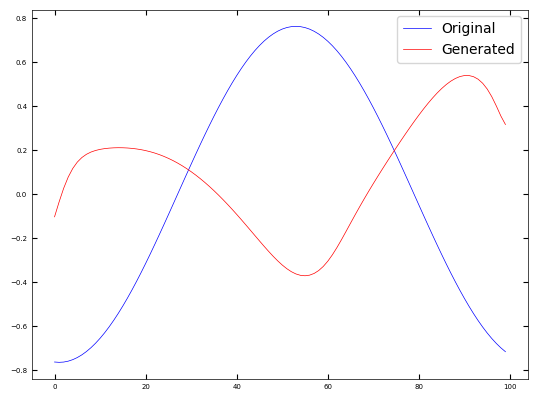

In [26]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


In [27]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


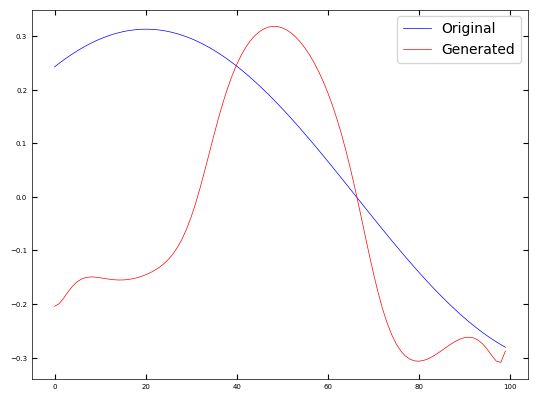

In [28]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


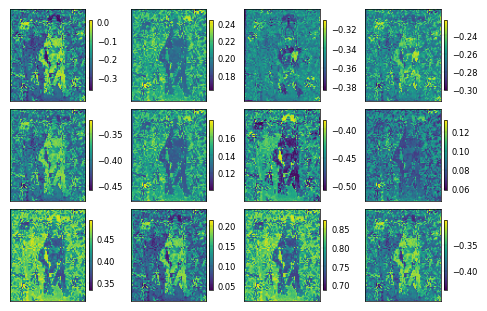

In [29]:
# Visualize the learned embeddings

embeddings(nala_encoded_, shape_=image.shape[0:2], figsize=(5, 3))


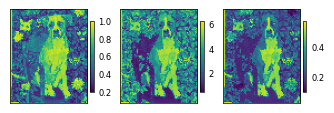

In [30]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(4, 1.25))


In [31]:
class DensePhysLarger(nn.Module):
    def __init__(
        self,
        x_vector,
        model,
        dense_params=3,
        verbose=False,
        device="cuda",
        num_channels=1,
        **kwargs
    ):
        """

        Args:
            x_vector: The vector of values for x
            model: the empirical function to fit
            dense_params: number of output parameters to the model
            verbose: sets if the model is verbose
            device: device where the model will run
            num_channels: number of channels in the input
        """

        super().__init__()
        self.dense_params = dense_params
        self.x_vector = x_vector
        self.verbose = verbose
        self.num_channels = num_channels
        self.device = device
        self.model_params = kwargs.get("model_params")
        # (self.x_vector, size=(num_channels, dense_params // self.model_params))
        self.model = model
        self.sigmoid = nn.Sigmoid()
        n = 4

        if torch.cuda.is_available():
            self.cuda()

        # Input block of 1d convolution

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.num_channels,
                      out_channels=8 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8 * n, out_channels=6 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6 * n, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        self.hidden_x1_shape = self.hidden_x1(
            torch.zeros(1, self.num_channels, self.x_vector.shape[0])
        ).shape

        # fully connected block

        self.hidden_xfc = nn.Sequential(
            nn.Linear(self.hidden_x1_shape[1] * self.hidden_x1_shape[2], 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # out of size 20

        self.hidden_xfc_shape = self.hidden_xfc(
            torch.zeros(1, self.hidden_x1_shape[1] * self.hidden_x1_shape[2])
        ).shape

        # 2nd block of 1d-conv layers

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=1, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4 * n, out_channels=2 * n, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2 * n, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        self.hidden_x2_shape = self.hidden_x2(
            torch.zeros(
                (
                    self.hidden_xfc_shape[0],
                    1,
                    self.hidden_x1_shape[1] * self.hidden_x1_shape[2],
                )
            )
        ).shape

        # Flatten layer

        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear

        self.hidden_embedding = nn.Sequential(
            nn.Linear(
                self.hidden_x2_shape[1] * self.hidden_x2_shape[2]
                + self.hidden_xfc_shape[1],
                16,
            ),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.dense_params),
        )

    def forward(self, x, n=-1):

        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (x.shape[0], -1))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(
            x, (x.shape[0], 1, self.hidden_x1_shape[1]
                * self.hidden_x1_shape[2])
        )
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.

        embedding = self.hidden_embedding(encoded)  # output is 3 parameters

        embedding = torch.reshape(embedding, (embedding.shape[0], 3, -1))

        embedding[:, 0, :] = (
            embedding[:, 0, :] * self.model.amp_sd + self.model.amp_mean
        )
        embedding[:, 1, :] = (
            embedding[:, 1, :] * self.model.phase_sd + self.model.phase_mean
        )
        embedding[:, 2, :] = (
            embedding[:, 2, :] * self.model.frequency_sd +
            self.model.frequency_mean
        )

        embedding = torch.reshape(embedding, (embedding.shape[0], -1))

        embedding = torch.abs(embedding)
        self.embed = embedding

        (out, _) = self.model.compute(embedding, device=self.device)

        out = torch.transpose(out, 1, 2)
        out = torch.atleast_3d(out)

        return (out.to(self.device), embedding.to(self.device))


In [32]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()


In [33]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)


In [34]:
random_seed(seed=42)

loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch : 0/200, recon loss = 0.34807296
--- 0.2518622875213623 seconds ---


epoch : 1/200, recon loss = 0.33283656
--- 0.21193361282348633 seconds ---


epoch : 2/200, recon loss = 0.31464642
--- 0.21874785423278809 seconds ---


epoch : 3/200, recon loss = 0.29415475
--- 0.22928881645202637 seconds ---


epoch : 4/200, recon loss = 0.27284013
--- 0.219038724899292 seconds ---


epoch : 5/200, recon loss = 0.25320231
--- 0.2211744785308838 seconds ---


epoch : 6/200, recon loss = 0.23616166
--- 0.21344876289367676 seconds ---


epoch : 7/200, recon loss = 0.22234960
--- 0.21073532104492188 seconds ---


epoch : 8/200, recon loss = 0.21207686
--- 0.2173759937286377 seconds ---


epoch : 9/200, recon loss = 0.20456120
--- 0.22291064262390137 seconds ---


epoch : 10/200, recon loss = 0.19881399
--- 0.211517333984375 seconds ---


epoch : 11/200, recon loss = 0.19401133
--- 0.2211756706237793 seconds ---


epoch : 12/200, recon loss = 0.18974638
--- 0.22035431861877441 seconds ---


epoch : 13/200, recon loss = 0.18563320
--- 0.208723783493042 seconds ---


epoch : 14/200, recon loss = 0.18159943
--- 0.20818853378295898 seconds ---


epoch : 15/200, recon loss = 0.17749995
--- 0.20724749565124512 seconds ---


epoch : 16/200, recon loss = 0.17329039
--- 0.20344972610473633 seconds ---
epoch : 17/200, recon loss = 0.16893948
--- 0.19957375526428223 seconds ---


epoch : 18/200, recon loss = 0.16456622
--- 0.21224570274353027 seconds ---


epoch : 19/200, recon loss = 0.16009087
--- 0.22219204902648926 seconds ---


epoch : 20/200, recon loss = 0.15562640
--- 0.21486973762512207 seconds ---


epoch : 21/200, recon loss = 0.15115412
--- 0.21584677696228027 seconds ---


epoch : 22/200, recon loss = 0.14688830
--- 0.21928644180297852 seconds ---


epoch : 23/200, recon loss = 0.14286465
--- 0.22116661071777344 seconds ---


epoch : 24/200, recon loss = 0.13910460
--- 0.22365570068359375 seconds ---


epoch : 25/200, recon loss = 0.13563676
--- 0.20869088172912598 seconds ---


epoch : 26/200, recon loss = 0.13238787
--- 0.22026443481445312 seconds ---


epoch : 27/200, recon loss = 0.12928148
--- 0.22233104705810547 seconds ---


epoch : 28/200, recon loss = 0.12628769
--- 0.22037768363952637 seconds ---


epoch : 29/200, recon loss = 0.12345623
--- 0.22226262092590332 seconds ---
epoch : 30/200, recon loss = 0.12076091
--- 0.19764065742492676 seconds ---


epoch : 31/200, recon loss = 0.11821551
--- 0.1987149715423584 seconds ---


epoch : 32/200, recon loss = 0.11582710
--- 0.21748065948486328 seconds ---


epoch : 33/200, recon loss = 0.11352206
--- 0.21341156959533691 seconds ---


epoch : 34/200, recon loss = 0.11130236
--- 0.21707367897033691 seconds ---


epoch : 35/200, recon loss = 0.10916066
--- 0.2047414779663086 seconds ---


epoch : 36/200, recon loss = 0.10710048
--- 0.21324539184570312 seconds ---


epoch : 37/200, recon loss = 0.10503596
--- 0.21442294120788574 seconds ---


epoch : 38/200, recon loss = 0.10304572
--- 0.20821094512939453 seconds ---


epoch : 39/200, recon loss = 0.10109164
--- 0.21730518341064453 seconds ---


epoch : 40/200, recon loss = 0.09915715
--- 0.22037410736083984 seconds ---


epoch : 41/200, recon loss = 0.09727178
--- 0.21784257888793945 seconds ---


epoch : 42/200, recon loss = 0.09544932
--- 0.2164151668548584 seconds ---


epoch : 43/200, recon loss = 0.09363639
--- 0.22016525268554688 seconds ---


epoch : 44/200, recon loss = 0.09186103
--- 0.21670818328857422 seconds ---


epoch : 45/200, recon loss = 0.09011523
--- 0.21135663986206055 seconds ---


epoch : 46/200, recon loss = 0.08838064
--- 0.20769667625427246 seconds ---
epoch : 47/200, recon loss = 0.08667434
--- 0.19631409645080566 seconds ---


epoch : 48/200, recon loss = 0.08498883
--- 0.21048879623413086 seconds ---


epoch : 49/200, recon loss = 0.08334705
--- 0.21561360359191895 seconds ---


epoch : 50/200, recon loss = 0.08170958
--- 0.20522594451904297 seconds ---


epoch : 51/200, recon loss = 0.08009629
--- 0.21834707260131836 seconds ---


epoch : 52/200, recon loss = 0.07850061
--- 0.20776915550231934 seconds ---


epoch : 53/200, recon loss = 0.07693278
--- 0.20821642875671387 seconds ---


epoch : 54/200, recon loss = 0.07539419
--- 0.21435761451721191 seconds ---


epoch : 55/200, recon loss = 0.07385597
--- 0.21203017234802246 seconds ---


epoch : 56/200, recon loss = 0.07237278
--- 0.21040773391723633 seconds ---


epoch : 57/200, recon loss = 0.07087410
--- 0.21303582191467285 seconds ---


epoch : 58/200, recon loss = 0.06941182
--- 0.20421218872070312 seconds ---


epoch : 59/200, recon loss = 0.06798151
--- 0.21742701530456543 seconds ---


epoch : 60/200, recon loss = 0.06656111
--- 0.2202591896057129 seconds ---


epoch : 61/200, recon loss = 0.06514058
--- 0.2184901237487793 seconds ---


epoch : 62/200, recon loss = 0.06373017
--- 0.21566510200500488 seconds ---


epoch : 63/200, recon loss = 0.06233013
--- 0.2196366786956787 seconds ---


epoch : 64/200, recon loss = 0.06092440
--- 0.2156686782836914 seconds ---


epoch : 65/200, recon loss = 0.05951839
--- 0.2166295051574707 seconds ---


epoch : 66/200, recon loss = 0.05811985
--- 0.21115803718566895 seconds ---


epoch : 67/200, recon loss = 0.05673243
--- 0.20764565467834473 seconds ---


epoch : 68/200, recon loss = 0.05534922
--- 0.2150735855102539 seconds ---


epoch : 69/200, recon loss = 0.05395455
--- 0.22056078910827637 seconds ---


epoch : 70/200, recon loss = 0.05260528
--- 0.2231760025024414 seconds ---


epoch : 71/200, recon loss = 0.05127650
--- 0.22583961486816406 seconds ---


epoch : 72/200, recon loss = 0.05002475
--- 0.2113640308380127 seconds ---


epoch : 73/200, recon loss = 0.04881970
--- 0.21039748191833496 seconds ---


epoch : 74/200, recon loss = 0.04764079
--- 0.2176990509033203 seconds ---


epoch : 75/200, recon loss = 0.04651984
--- 0.20910143852233887 seconds ---


epoch : 76/200, recon loss = 0.04541108
--- 0.21624016761779785 seconds ---


epoch : 77/200, recon loss = 0.04436669
--- 0.2030632495880127 seconds ---


epoch : 78/200, recon loss = 0.04332860
--- 0.21549677848815918 seconds ---


epoch : 79/200, recon loss = 0.04235048
--- 0.20971179008483887 seconds ---


epoch : 80/200, recon loss = 0.04139363
--- 0.2212822437286377 seconds ---


epoch : 81/200, recon loss = 0.04050299
--- 0.21659278869628906 seconds ---
epoch : 82/200, recon loss = 0.03966356
--- 0.18748927116394043 seconds ---


epoch : 83/200, recon loss = 0.03879384
--- 0.21125459671020508 seconds ---


epoch : 84/200, recon loss = 0.03796620
--- 0.20209503173828125 seconds ---


epoch : 85/200, recon loss = 0.03719127
--- 0.20562219619750977 seconds ---


epoch : 86/200, recon loss = 0.03645870
--- 0.20969915390014648 seconds ---


epoch : 87/200, recon loss = 0.03573075
--- 0.21105456352233887 seconds ---


epoch : 88/200, recon loss = 0.03505388
--- 0.22056126594543457 seconds ---


epoch : 89/200, recon loss = 0.03438531
--- 0.2039792537689209 seconds ---


epoch : 90/200, recon loss = 0.03375722
--- 0.21521306037902832 seconds ---


epoch : 91/200, recon loss = 0.03317588
--- 0.20907282829284668 seconds ---


epoch : 92/200, recon loss = 0.03256927
--- 0.20754313468933105 seconds ---


epoch : 93/200, recon loss = 0.03200775
--- 0.20968031883239746 seconds ---


epoch : 94/200, recon loss = 0.03146140
--- 0.21368074417114258 seconds ---


epoch : 95/200, recon loss = 0.03095600
--- 0.2175886631011963 seconds ---


epoch : 96/200, recon loss = 0.03044749
--- 0.2115464210510254 seconds ---


epoch : 97/200, recon loss = 0.02996673
--- 0.20402312278747559 seconds ---


epoch : 98/200, recon loss = 0.02951240
--- 0.21393203735351562 seconds ---
epoch : 99/200, recon loss = 0.02906531
--- 0.1972813606262207 seconds ---


epoch : 100/200, recon loss = 0.02862865
--- 0.20498275756835938 seconds ---


epoch : 101/200, recon loss = 0.02822426
--- 0.2069110870361328 seconds ---


epoch : 102/200, recon loss = 0.02783572
--- 0.212080717086792 seconds ---


epoch : 103/200, recon loss = 0.02744732
--- 0.20928025245666504 seconds ---


epoch : 104/200, recon loss = 0.02711982
--- 0.2180919647216797 seconds ---


epoch : 105/200, recon loss = 0.02675135
--- 0.2163851261138916 seconds ---


epoch : 106/200, recon loss = 0.02640016
--- 0.21300983428955078 seconds ---


epoch : 107/200, recon loss = 0.02605979
--- 0.21450042724609375 seconds ---


epoch : 108/200, recon loss = 0.02574614
--- 0.20805096626281738 seconds ---


epoch : 109/200, recon loss = 0.02540872
--- 0.2071089744567871 seconds ---


epoch : 110/200, recon loss = 0.02510939
--- 0.21114563941955566 seconds ---


epoch : 111/200, recon loss = 0.02479136
--- 0.2101294994354248 seconds ---


epoch : 112/200, recon loss = 0.02450953
--- 0.20109343528747559 seconds ---


epoch : 113/200, recon loss = 0.02422752
--- 0.21326494216918945 seconds ---


epoch : 114/200, recon loss = 0.02396948
--- 0.20473241806030273 seconds ---


epoch : 115/200, recon loss = 0.02371947
--- 0.23256754875183105 seconds ---


epoch : 116/200, recon loss = 0.02347630
--- 0.23073744773864746 seconds ---
epoch : 117/200, recon loss = 0.02320229
--- 0.18674778938293457 seconds ---


epoch : 118/200, recon loss = 0.02296800
--- 0.1957874298095703 seconds ---
epoch : 119/200, recon loss = 0.02275499
--- 0.19269824028015137 seconds ---


epoch : 120/200, recon loss = 0.02252878
--- 0.1924271583557129 seconds ---


epoch : 121/200, recon loss = 0.02228633
--- 0.2084667682647705 seconds ---


epoch : 122/200, recon loss = 0.02205339
--- 0.21935653686523438 seconds ---


epoch : 123/200, recon loss = 0.02184658
--- 0.20984911918640137 seconds ---


epoch : 124/200, recon loss = 0.02162964
--- 0.21444940567016602 seconds ---


epoch : 125/200, recon loss = 0.02142564
--- 0.2085568904876709 seconds ---


epoch : 126/200, recon loss = 0.02120564
--- 0.21390604972839355 seconds ---


epoch : 127/200, recon loss = 0.02100800
--- 0.22357511520385742 seconds ---


epoch : 128/200, recon loss = 0.02079979
--- 0.22491002082824707 seconds ---


epoch : 129/200, recon loss = 0.02058713
--- 0.2182013988494873 seconds ---


epoch : 130/200, recon loss = 0.02045890
--- 0.20754218101501465 seconds ---


epoch : 131/200, recon loss = 0.02023969
--- 0.21373653411865234 seconds ---


epoch : 132/200, recon loss = 0.02006944
--- 0.22726917266845703 seconds ---


epoch : 133/200, recon loss = 0.01989023
--- 0.2207643985748291 seconds ---


epoch : 134/200, recon loss = 0.01970654
--- 0.2088155746459961 seconds ---


epoch : 135/200, recon loss = 0.01957393
--- 0.22704672813415527 seconds ---


epoch : 136/200, recon loss = 0.01941918
--- 0.21362876892089844 seconds ---


epoch : 137/200, recon loss = 0.01921344
--- 0.22166752815246582 seconds ---


epoch : 138/200, recon loss = 0.01905151
--- 0.2247178554534912 seconds ---


epoch : 139/200, recon loss = 0.01893672
--- 0.2183544635772705 seconds ---


epoch : 140/200, recon loss = 0.01871756
--- 0.20116639137268066 seconds ---


epoch : 141/200, recon loss = 0.01857875
--- 0.2141706943511963 seconds ---


epoch : 142/200, recon loss = 0.01843608
--- 0.2193763256072998 seconds ---


epoch : 143/200, recon loss = 0.01829290
--- 0.2245190143585205 seconds ---


epoch : 144/200, recon loss = 0.01818062
--- 0.22302556037902832 seconds ---


epoch : 145/200, recon loss = 0.01806683
--- 0.20729422569274902 seconds ---
epoch : 146/200, recon loss = 0.01791286
--- 0.19576120376586914 seconds ---


epoch : 147/200, recon loss = 0.01778431
--- 0.22326970100402832 seconds ---


epoch : 148/200, recon loss = 0.01765120
--- 0.21703004837036133 seconds ---


epoch : 149/200, recon loss = 0.01752669
--- 0.21691083908081055 seconds ---


epoch : 150/200, recon loss = 0.01741620
--- 0.20905327796936035 seconds ---


epoch : 151/200, recon loss = 0.01728178
--- 0.21000957489013672 seconds ---


epoch : 152/200, recon loss = 0.01712669
--- 0.20369243621826172 seconds ---


epoch : 153/200, recon loss = 0.01695464
--- 0.21893310546875 seconds ---


epoch : 154/200, recon loss = 0.01677790
--- 0.2181234359741211 seconds ---


epoch : 155/200, recon loss = 0.01661961
--- 0.2159595489501953 seconds ---


epoch : 156/200, recon loss = 0.01645406
--- 0.2037665843963623 seconds ---
epoch : 157/200, recon loss = 0.01630049
--- 0.19999217987060547 seconds ---


epoch : 158/200, recon loss = 0.01619081
--- 0.2016749382019043 seconds ---


epoch : 159/200, recon loss = 0.01603170
--- 0.21254920959472656 seconds ---


epoch : 160/200, recon loss = 0.01592158
--- 0.21407127380371094 seconds ---


epoch : 161/200, recon loss = 0.01575149
--- 0.22227764129638672 seconds ---


epoch : 162/200, recon loss = 0.01564988
--- 0.22440743446350098 seconds ---


epoch : 163/200, recon loss = 0.01553810
--- 0.21007037162780762 seconds ---


epoch : 164/200, recon loss = 0.01542568
--- 0.21053671836853027 seconds ---


epoch : 165/200, recon loss = 0.01535788
--- 0.20733165740966797 seconds ---
epoch : 166/200, recon loss = 0.01522920
--- 0.18274283409118652 seconds ---


epoch : 167/200, recon loss = 0.01515440
--- 0.20657134056091309 seconds ---


epoch : 168/200, recon loss = 0.01507351
--- 0.20461440086364746 seconds ---
epoch : 169/200, recon loss = 0.01498624
--- 0.1992788314819336 seconds ---


epoch : 170/200, recon loss = 0.01486988
--- 0.23046445846557617 seconds ---


epoch : 171/200, recon loss = 0.01478734
--- 0.2177114486694336 seconds ---


epoch : 172/200, recon loss = 0.01469069
--- 0.2136991024017334 seconds ---


epoch : 173/200, recon loss = 0.01463413
--- 0.2127087116241455 seconds ---


epoch : 174/200, recon loss = 0.01453866
--- 0.22485017776489258 seconds ---


epoch : 175/200, recon loss = 0.01445768
--- 0.21792197227478027 seconds ---


epoch : 176/200, recon loss = 0.01438434
--- 0.22265982627868652 seconds ---


epoch : 177/200, recon loss = 0.01431682
--- 0.21697568893432617 seconds ---


epoch : 178/200, recon loss = 0.01422225
--- 0.20312762260437012 seconds ---


epoch : 179/200, recon loss = 0.01413797
--- 0.2115464210510254 seconds ---


epoch : 180/200, recon loss = 0.01408795
--- 0.21428227424621582 seconds ---
epoch : 181/200, recon loss = 0.01408533
--- 0.18857574462890625 seconds ---


epoch : 182/200, recon loss = 0.01393258
--- 0.17871761322021484 seconds ---


epoch : 183/200, recon loss = 0.01383569
--- 0.21948766708374023 seconds ---


epoch : 184/200, recon loss = 0.01376582
--- 0.21593236923217773 seconds ---
epoch : 185/200, recon loss = 0.01372063
--- 0.17635202407836914 seconds ---


epoch : 186/200, recon loss = 0.01362255
--- 0.17125558853149414 seconds ---


epoch : 187/200, recon loss = 0.01353492
--- 0.20819520950317383 seconds ---


epoch : 188/200, recon loss = 0.01352991
--- 0.2142951488494873 seconds ---


epoch : 189/200, recon loss = 0.01338114
--- 0.21678709983825684 seconds ---


epoch : 190/200, recon loss = 0.01331467
--- 0.2151494026184082 seconds ---


epoch : 191/200, recon loss = 0.01326447
--- 0.21066975593566895 seconds ---


epoch : 192/200, recon loss = 0.01319622
--- 0.20742344856262207 seconds ---


epoch : 193/200, recon loss = 0.01314173
--- 0.2077956199645996 seconds ---


epoch : 194/200, recon loss = 0.01306463
--- 0.21224141120910645 seconds ---


epoch : 195/200, recon loss = 0.01307601
--- 0.218597412109375 seconds ---


epoch : 196/200, recon loss = 0.01293757
--- 0.22980427742004395 seconds ---


epoch : 197/200, recon loss = 0.01287385
--- 0.2222883701324463 seconds ---


epoch : 198/200, recon loss = 0.01281341
--- 0.22807931900024414 seconds ---


epoch : 199/200, recon loss = 0.01277265
--- 0.22110652923583984 seconds ---


tensor([0.4883, 1.7120, 0.4055], device='cuda:0', grad_fn=<SelectBackward0>)


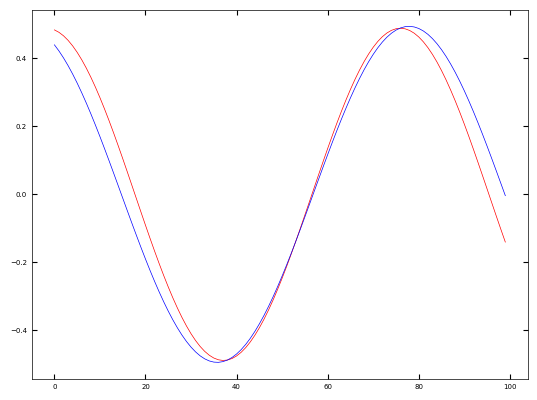

In [35]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


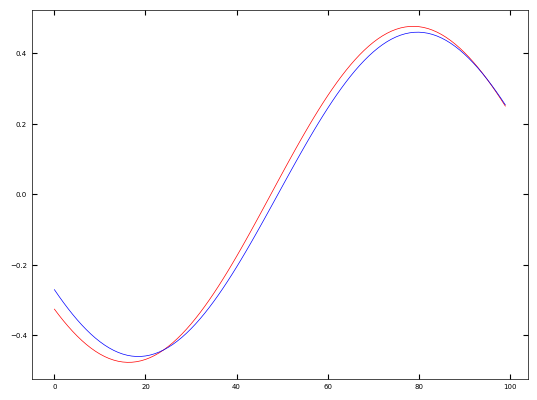

In [36]:
nala_spectra_generated, nala_params = model(
    nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [37]:
# removes 2pi shifts
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


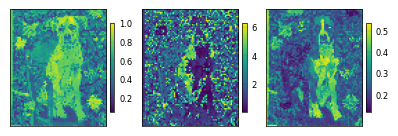

In [38]:
# Visualize the learned embeddings
embeddings(nala_params.detach().cpu().numpy(),
           shape_=image.shape[0:2], figsize=(5, 1.25))


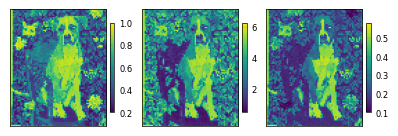

In [39]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(5, 1.25))


In [40]:
"""
Created on Sun Feb 26 16:34:00 2021
@author: Amir Gholami
@coauthor: David Samuel
"""

import numpy as np
import torch


class AdaHessian(torch.optim.Optimizer):
    """
    Implements the AdaHessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"
    Arguments:
        params (iterable) -- iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional) -- learning rate (default: 0.1)
        betas ((float, float), optional) -- coefficients used for computing running averages of gradient and the squared hessian trace (default: (0.9, 0.999))
        eps (float, optional) -- term added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay (float, optional) -- weight decay (L2 penalty) (default: 0.0)
        hessian_power (float, optional) -- exponent of the hessian trace (default: 1.0)
        update_each (int, optional) -- compute the hessian trace approximation only after *this* number of steps (to save time) (default: 1)
        n_samples (int, optional) -- how many times to sample `z` for the approximation of the hessian trace (default: 1)
    """

    def __init__(
        self,
        params,
        lr=0.1,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0.0,
        hessian_power=1.0,
        update_each=1,
        n_samples=1,
        average_conv_kernel=False,
    ):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError(f"Invalid Hessian power value: {hessian_power}")

        self.n_samples = n_samples
        self.update_each = update_each
        self.average_conv_kernel = average_conv_kernel

        # use a separate generator that deterministically generates the same `z`s across all GPUs in case of distributed training
        self.generator = torch.Generator().manual_seed(2147483647)

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            hessian_power=hessian_power,
        )
        super(AdaHessian, self).__init__(params, defaults)

        for p in self.get_params():
            p.hess = 0.0
            self.state[p]["hessian step"] = 0

    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """

        return (
            p for group in self.param_groups for p in group["params"] if p.requires_grad
        )

    def zero_hessian(self):
        """
        Zeros out the accumulated hessian traces.
        """

        for p in self.get_params():
            if (
                not isinstance(p.hess, float)
                and self.state[p]["hessian step"] % self.update_each == 0
            ):
                p.hess.zero_()

    @torch.no_grad()
    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """

        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if (
                self.state[p]["hessian step"] % self.update_each == 0
            ):  # compute the trace only for each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if (
            self.generator.device != params[0].device
        ):  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(
                params[0].device).manual_seed(2147483647)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            zs = [
                torch.randint(0, 2, p.size(),
                              generator=self.generator, device=p.device)
                * 2.0
                - 1.0
                for p in params
            ]  # Rademacher distribution {-1.0, 1.0}
            h_zs = torch.autograd.grad(
                grads,
                params,
                grad_outputs=zs,
                only_inputs=True,
                retain_graph=i < self.n_samples - 1,
            )
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += (
                    h_z * z / self.n_samples
                )  # approximate the expected values of z*(H@z)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional) -- a closure that reevaluates the model and returns the loss (default: None)
        """

        loss = None
        if closure is not None:
            loss = closure()

        self.zero_hessian()
        self.set_hessian()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or p.hess is None:
                    continue

                if self.average_conv_kernel and p.dim() == 4:
                    p.hess = (
                        torch.abs(p.hess)
                        .mean(dim=[2, 3], keepdim=True)
                        .expand_as(p.hess)
                        .clone()
                    )

                # Perform correct stepweight decay as in AdamW
                p.mul_(1 - group["lr"] * group["weight_decay"])

                state = self.state[p]

                # State initialization
                if len(state) == 1:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of gradient values
                    state["exp_hessian_diag_sq"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of Hessian diagonal square values

                exp_avg, exp_hessian_diag_sq = (
                    state["exp_avg"],
                    state["exp_hessian_diag_sq"],
                )
                beta1, beta2 = group["betas"]
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(
                    p.hess, p.hess, value=1 - beta2
                )

                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                k = group["hessian_power"]
                denom = (
                    (exp_hessian_diag_sq / bias_correction2)
                    .pow_(k / 2)
                    .add_(group["eps"])
                )

                # make update
                step_size = group["lr"] / bias_correction1
                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss


In [41]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()


In [42]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)


In [43]:
random_seed(seed=42)

loss_func = torch.nn.MSELoss()

# Use AdaHessian

optimizer = AdaHessian(model.parameters(), lr=0.1)

epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


epoch : 0/200, recon loss = 1.16170070
--- 0.6310837268829346 seconds ---


epoch : 1/200, recon loss = 0.29540655
--- 0.6091735363006592 seconds ---


epoch : 2/200, recon loss = 0.24439488
--- 0.5974318981170654 seconds ---


epoch : 3/200, recon loss = 0.23279669
--- 0.5764749050140381 seconds ---


epoch : 4/200, recon loss = 0.22531185
--- 0.5684020519256592 seconds ---


epoch : 5/200, recon loss = 0.21848569
--- 0.5945780277252197 seconds ---


epoch : 6/200, recon loss = 0.21339893
--- 0.5702254772186279 seconds ---


epoch : 7/200, recon loss = 0.20906202
--- 0.6004979610443115 seconds ---


epoch : 8/200, recon loss = 0.20480367
--- 0.602635383605957 seconds ---


epoch : 9/200, recon loss = 0.20036091
--- 0.584251880645752 seconds ---


epoch : 10/200, recon loss = 0.19502591
--- 0.5959391593933105 seconds ---


epoch : 11/200, recon loss = 0.18864675
--- 0.5968320369720459 seconds ---


epoch : 12/200, recon loss = 0.18391181
--- 0.5821759700775146 seconds ---


epoch : 13/200, recon loss = 0.18011030
--- 0.5798449516296387 seconds ---


epoch : 14/200, recon loss = 0.17707178
--- 0.5834305286407471 seconds ---


epoch : 15/200, recon loss = 0.17470671
--- 0.5963056087493896 seconds ---


epoch : 16/200, recon loss = 0.17278318
--- 0.5829155445098877 seconds ---


epoch : 17/200, recon loss = 0.17111075
--- 0.5940427780151367 seconds ---


epoch : 18/200, recon loss = 0.16965689
--- 0.5951747894287109 seconds ---


epoch : 19/200, recon loss = 0.16840878
--- 0.5971851348876953 seconds ---


epoch : 20/200, recon loss = 0.16721787
--- 0.5971040725708008 seconds ---


epoch : 21/200, recon loss = 0.16616790
--- 0.5759634971618652 seconds ---


epoch : 22/200, recon loss = 0.16516449
--- 0.6198859214782715 seconds ---


epoch : 23/200, recon loss = 0.16420799
--- 0.6044695377349854 seconds ---


epoch : 24/200, recon loss = 0.16339718
--- 0.5776345729827881 seconds ---


epoch : 25/200, recon loss = 0.16256776
--- 0.575385570526123 seconds ---


epoch : 26/200, recon loss = 0.16176785
--- 0.595538854598999 seconds ---


epoch : 27/200, recon loss = 0.16101409
--- 0.5835609436035156 seconds ---


epoch : 28/200, recon loss = 0.16033160
--- 0.5880210399627686 seconds ---


epoch : 29/200, recon loss = 0.15967655
--- 0.6047649383544922 seconds ---


epoch : 30/200, recon loss = 0.15900817
--- 0.604360818862915 seconds ---


epoch : 31/200, recon loss = 0.15833629
--- 0.5805022716522217 seconds ---


epoch : 32/200, recon loss = 0.15765952
--- 0.557607889175415 seconds ---


epoch : 33/200, recon loss = 0.15701423
--- 0.5640575885772705 seconds ---


epoch : 34/200, recon loss = 0.15634833
--- 0.5851848125457764 seconds ---


epoch : 35/200, recon loss = 0.15570689
--- 0.5755388736724854 seconds ---


epoch : 36/200, recon loss = 0.15501604
--- 0.5826056003570557 seconds ---


epoch : 37/200, recon loss = 0.15438231
--- 0.5899453163146973 seconds ---


epoch : 38/200, recon loss = 0.15366176
--- 0.6180226802825928 seconds ---


epoch : 39/200, recon loss = 0.15294022
--- 0.5743098258972168 seconds ---


epoch : 40/200, recon loss = 0.15207277
--- 0.5859940052032471 seconds ---


epoch : 41/200, recon loss = 0.15109842
--- 0.6019940376281738 seconds ---


epoch : 42/200, recon loss = 0.15000852
--- 0.5806872844696045 seconds ---


epoch : 43/200, recon loss = 0.14867276
--- 0.5838785171508789 seconds ---


epoch : 44/200, recon loss = 0.14718617
--- 0.6085531711578369 seconds ---


epoch : 45/200, recon loss = 0.14531436
--- 0.5951330661773682 seconds ---


epoch : 46/200, recon loss = 0.14310713
--- 0.5626192092895508 seconds ---


epoch : 47/200, recon loss = 0.14086094
--- 0.5787529945373535 seconds ---


epoch : 48/200, recon loss = 0.13814310
--- 0.6228687763214111 seconds ---


epoch : 49/200, recon loss = 0.13531287
--- 0.5720310211181641 seconds ---


epoch : 50/200, recon loss = 0.13158357
--- 0.5984275341033936 seconds ---


epoch : 51/200, recon loss = 0.12594423
--- 0.5820815563201904 seconds ---


epoch : 52/200, recon loss = 0.11607365
--- 0.567591667175293 seconds ---


epoch : 53/200, recon loss = 0.10498937
--- 0.5612452030181885 seconds ---


epoch : 54/200, recon loss = 0.09765081
--- 0.6182236671447754 seconds ---


epoch : 55/200, recon loss = 0.09259138
--- 0.6221878528594971 seconds ---


epoch : 56/200, recon loss = 0.08838022
--- 0.5555505752563477 seconds ---


epoch : 57/200, recon loss = 0.08480213
--- 0.5873231887817383 seconds ---


epoch : 58/200, recon loss = 0.08157423
--- 0.5921952724456787 seconds ---


epoch : 59/200, recon loss = 0.07871120
--- 0.599379301071167 seconds ---


epoch : 60/200, recon loss = 0.07617125
--- 0.5722923278808594 seconds ---


epoch : 61/200, recon loss = 0.07349952
--- 0.5849635601043701 seconds ---


epoch : 62/200, recon loss = 0.07094009
--- 0.6086776256561279 seconds ---


epoch : 63/200, recon loss = 0.06847222
--- 0.6036131381988525 seconds ---


epoch : 64/200, recon loss = 0.06608373
--- 0.5925354957580566 seconds ---


epoch : 65/200, recon loss = 0.06378353
--- 0.582655668258667 seconds ---


epoch : 66/200, recon loss = 0.06169929
--- 0.5747618675231934 seconds ---


epoch : 67/200, recon loss = 0.05968532
--- 0.5960164070129395 seconds ---


epoch : 68/200, recon loss = 0.05798553
--- 0.5832715034484863 seconds ---


epoch : 69/200, recon loss = 0.05639969
--- 0.5574939250946045 seconds ---


epoch : 70/200, recon loss = 0.05492720
--- 0.576850414276123 seconds ---


epoch : 71/200, recon loss = 0.05348797
--- 0.5743410587310791 seconds ---


epoch : 72/200, recon loss = 0.05231909
--- 0.600050687789917 seconds ---


epoch : 73/200, recon loss = 0.05123130
--- 0.5765888690948486 seconds ---


epoch : 74/200, recon loss = 0.05023101
--- 0.6003499031066895 seconds ---


epoch : 75/200, recon loss = 0.04936066
--- 0.6049680709838867 seconds ---


epoch : 76/200, recon loss = 0.04852965
--- 0.6013362407684326 seconds ---


epoch : 77/200, recon loss = 0.04779741
--- 0.5959420204162598 seconds ---


epoch : 78/200, recon loss = 0.04710154
--- 0.6237750053405762 seconds ---


epoch : 79/200, recon loss = 0.04642132
--- 0.6066536903381348 seconds ---


epoch : 80/200, recon loss = 0.04583318
--- 0.5714311599731445 seconds ---


epoch : 81/200, recon loss = 0.04525982
--- 0.5726370811462402 seconds ---


epoch : 82/200, recon loss = 0.04468798
--- 0.6011788845062256 seconds ---


epoch : 83/200, recon loss = 0.04419874
--- 0.5875911712646484 seconds ---


epoch : 84/200, recon loss = 0.04370431
--- 0.5698328018188477 seconds ---


epoch : 85/200, recon loss = 0.04322364
--- 0.5862276554107666 seconds ---


epoch : 86/200, recon loss = 0.04283373
--- 0.5729146003723145 seconds ---


epoch : 87/200, recon loss = 0.04239599
--- 0.5955228805541992 seconds ---


epoch : 88/200, recon loss = 0.04200819
--- 0.5718014240264893 seconds ---


epoch : 89/200, recon loss = 0.04159995
--- 0.5697028636932373 seconds ---


epoch : 90/200, recon loss = 0.04122732
--- 0.5677464008331299 seconds ---


epoch : 91/200, recon loss = 0.04086541
--- 0.5911762714385986 seconds ---


epoch : 92/200, recon loss = 0.04055555
--- 0.5871601104736328 seconds ---


epoch : 93/200, recon loss = 0.04020739
--- 0.5952754020690918 seconds ---


epoch : 94/200, recon loss = 0.03989142
--- 0.5975253582000732 seconds ---


epoch : 95/200, recon loss = 0.03953697
--- 0.603398323059082 seconds ---


epoch : 96/200, recon loss = 0.03923387
--- 0.5727121829986572 seconds ---


epoch : 97/200, recon loss = 0.03893140
--- 0.5702359676361084 seconds ---


epoch : 98/200, recon loss = 0.03866032
--- 0.5824375152587891 seconds ---


epoch : 99/200, recon loss = 0.03838178
--- 0.5941729545593262 seconds ---


epoch : 100/200, recon loss = 0.03812337
--- 0.5786278247833252 seconds ---


epoch : 101/200, recon loss = 0.03785505
--- 0.6010298728942871 seconds ---


epoch : 102/200, recon loss = 0.03763952
--- 0.5982184410095215 seconds ---


epoch : 103/200, recon loss = 0.03734931
--- 0.6008636951446533 seconds ---


epoch : 104/200, recon loss = 0.03713600
--- 0.585975170135498 seconds ---


epoch : 105/200, recon loss = 0.03688282
--- 0.5994007587432861 seconds ---


epoch : 106/200, recon loss = 0.03667372
--- 0.5918469429016113 seconds ---


epoch : 107/200, recon loss = 0.03640900
--- 0.5758833885192871 seconds ---


epoch : 108/200, recon loss = 0.03619438
--- 0.591442346572876 seconds ---


epoch : 109/200, recon loss = 0.03600518
--- 0.5653929710388184 seconds ---


epoch : 110/200, recon loss = 0.03577069
--- 0.601954460144043 seconds ---


epoch : 111/200, recon loss = 0.03555703
--- 0.5620105266571045 seconds ---


epoch : 112/200, recon loss = 0.03536226
--- 0.5606834888458252 seconds ---


epoch : 113/200, recon loss = 0.03518173
--- 0.562675952911377 seconds ---


epoch : 114/200, recon loss = 0.03498472
--- 0.561901330947876 seconds ---


epoch : 115/200, recon loss = 0.03477362
--- 0.5725581645965576 seconds ---


epoch : 116/200, recon loss = 0.03458268
--- 0.5735781192779541 seconds ---


epoch : 117/200, recon loss = 0.03439164
--- 0.6031601428985596 seconds ---


epoch : 118/200, recon loss = 0.03422609
--- 0.5940682888031006 seconds ---


epoch : 119/200, recon loss = 0.03405280
--- 0.5833401679992676 seconds ---


epoch : 120/200, recon loss = 0.03384584
--- 0.5662293434143066 seconds ---


epoch : 121/200, recon loss = 0.03368742
--- 0.5789885520935059 seconds ---


epoch : 122/200, recon loss = 0.03350273
--- 0.5698540210723877 seconds ---


epoch : 123/200, recon loss = 0.03332524
--- 0.5846481323242188 seconds ---


epoch : 124/200, recon loss = 0.03319408
--- 0.5732886791229248 seconds ---


epoch : 125/200, recon loss = 0.03304932
--- 0.5852508544921875 seconds ---


epoch : 126/200, recon loss = 0.03284826
--- 0.5740554332733154 seconds ---


epoch : 127/200, recon loss = 0.03270171
--- 0.6050102710723877 seconds ---


epoch : 128/200, recon loss = 0.03253253
--- 0.5846836566925049 seconds ---


epoch : 129/200, recon loss = 0.03234768
--- 0.5633974075317383 seconds ---


epoch : 130/200, recon loss = 0.03219019
--- 0.5680012702941895 seconds ---


epoch : 131/200, recon loss = 0.03202055
--- 0.5632936954498291 seconds ---


epoch : 132/200, recon loss = 0.03186840
--- 0.5744471549987793 seconds ---


epoch : 133/200, recon loss = 0.03173603
--- 0.5914688110351562 seconds ---


epoch : 134/200, recon loss = 0.03157719
--- 0.5698432922363281 seconds ---


epoch : 135/200, recon loss = 0.03146704
--- 0.5884511470794678 seconds ---


epoch : 136/200, recon loss = 0.03135074
--- 0.5853707790374756 seconds ---


epoch : 137/200, recon loss = 0.03120479
--- 0.5654332637786865 seconds ---


epoch : 138/200, recon loss = 0.03108194
--- 0.5721883773803711 seconds ---


epoch : 139/200, recon loss = 0.03098859
--- 0.5943272113800049 seconds ---


epoch : 140/200, recon loss = 0.03084032
--- 0.5872583389282227 seconds ---


epoch : 141/200, recon loss = 0.03070912
--- 0.5847814083099365 seconds ---


epoch : 142/200, recon loss = 0.03061015
--- 0.5791079998016357 seconds ---


epoch : 143/200, recon loss = 0.03051306
--- 0.5762557983398438 seconds ---


epoch : 144/200, recon loss = 0.03040779
--- 0.585852861404419 seconds ---


epoch : 145/200, recon loss = 0.03031108
--- 0.5980825424194336 seconds ---


epoch : 146/200, recon loss = 0.03020282
--- 0.5756947994232178 seconds ---


epoch : 147/200, recon loss = 0.03011087
--- 0.5787143707275391 seconds ---


epoch : 148/200, recon loss = 0.02999715
--- 0.6016836166381836 seconds ---


epoch : 149/200, recon loss = 0.02989949
--- 0.5928776264190674 seconds ---


epoch : 150/200, recon loss = 0.02980124
--- 0.5660400390625 seconds ---


epoch : 151/200, recon loss = 0.02972129
--- 0.5718600749969482 seconds ---


epoch : 152/200, recon loss = 0.02963771
--- 0.5622560977935791 seconds ---


epoch : 153/200, recon loss = 0.02955602
--- 0.5776686668395996 seconds ---


epoch : 154/200, recon loss = 0.02947728
--- 0.5880053043365479 seconds ---


epoch : 155/200, recon loss = 0.02938726
--- 0.5966708660125732 seconds ---


epoch : 156/200, recon loss = 0.02929739
--- 0.5657033920288086 seconds ---


epoch : 157/200, recon loss = 0.02921282
--- 0.5996685028076172 seconds ---


epoch : 158/200, recon loss = 0.02912490
--- 0.603374719619751 seconds ---


epoch : 159/200, recon loss = 0.02905541
--- 0.6138980388641357 seconds ---


epoch : 160/200, recon loss = 0.02898280
--- 0.6154754161834717 seconds ---


epoch : 161/200, recon loss = 0.02888731
--- 0.5608015060424805 seconds ---


epoch : 162/200, recon loss = 0.02883634
--- 0.5720748901367188 seconds ---


epoch : 163/200, recon loss = 0.02874600
--- 0.6183698177337646 seconds ---


epoch : 164/200, recon loss = 0.02866875
--- 0.5897345542907715 seconds ---


epoch : 165/200, recon loss = 0.02859483
--- 0.5690178871154785 seconds ---


epoch : 166/200, recon loss = 0.02853468
--- 0.5870211124420166 seconds ---


epoch : 167/200, recon loss = 0.02845525
--- 0.5834243297576904 seconds ---


epoch : 168/200, recon loss = 0.02837583
--- 0.6053540706634521 seconds ---


epoch : 169/200, recon loss = 0.02832274
--- 0.5835907459259033 seconds ---


epoch : 170/200, recon loss = 0.02824329
--- 0.60044264793396 seconds ---


epoch : 171/200, recon loss = 0.02818033
--- 0.5887460708618164 seconds ---


epoch : 172/200, recon loss = 0.02811080
--- 0.5731155872344971 seconds ---


epoch : 173/200, recon loss = 0.02803605
--- 0.5861222743988037 seconds ---


epoch : 174/200, recon loss = 0.02798760
--- 0.5932056903839111 seconds ---


epoch : 175/200, recon loss = 0.02791159
--- 0.6068799495697021 seconds ---


epoch : 176/200, recon loss = 0.02787140
--- 0.5797257423400879 seconds ---


epoch : 177/200, recon loss = 0.02780613
--- 0.5719609260559082 seconds ---


epoch : 178/200, recon loss = 0.02773555
--- 0.5819873809814453 seconds ---


epoch : 179/200, recon loss = 0.02768797
--- 0.5834448337554932 seconds ---


epoch : 180/200, recon loss = 0.02762948
--- 0.5725927352905273 seconds ---


epoch : 181/200, recon loss = 0.02756292
--- 0.5861413478851318 seconds ---


epoch : 182/200, recon loss = 0.02749705
--- 0.5657486915588379 seconds ---


epoch : 183/200, recon loss = 0.02744229
--- 0.5689511299133301 seconds ---


epoch : 184/200, recon loss = 0.02738181
--- 0.584667444229126 seconds ---


epoch : 185/200, recon loss = 0.02734607
--- 0.5759603977203369 seconds ---


epoch : 186/200, recon loss = 0.02730314
--- 0.5744273662567139 seconds ---


epoch : 187/200, recon loss = 0.02724808
--- 0.5997395515441895 seconds ---


epoch : 188/200, recon loss = 0.02719458
--- 0.5969820022583008 seconds ---


epoch : 189/200, recon loss = 0.02713416
--- 0.5951967239379883 seconds ---


epoch : 190/200, recon loss = 0.02707438
--- 0.6021630764007568 seconds ---


epoch : 191/200, recon loss = 0.02701914
--- 0.6179409027099609 seconds ---


epoch : 192/200, recon loss = 0.02696202
--- 0.6015009880065918 seconds ---


epoch : 193/200, recon loss = 0.02691300
--- 0.5950503349304199 seconds ---


epoch : 194/200, recon loss = 0.02686955
--- 0.5783994197845459 seconds ---


epoch : 195/200, recon loss = 0.02683569
--- 0.5787327289581299 seconds ---


epoch : 196/200, recon loss = 0.02676935
--- 0.5650713443756104 seconds ---


epoch : 197/200, recon loss = 0.02672497
--- 0.561894416809082 seconds ---


epoch : 198/200, recon loss = 0.02667455
--- 0.5722863674163818 seconds ---


epoch : 199/200, recon loss = 0.02661606
--- 0.5963590145111084 seconds ---


tensor([0.4620, 2.0111, 0.3710], device='cuda:0', grad_fn=<SelectBackward0>)


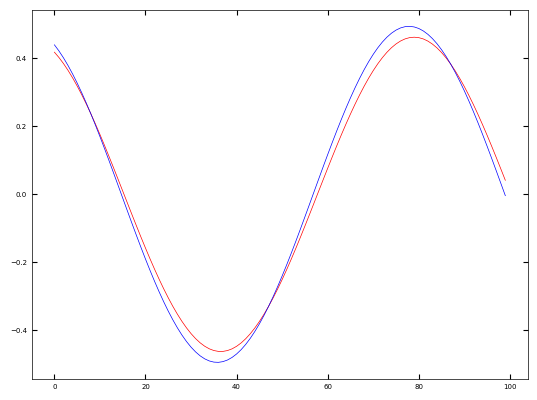

In [44]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


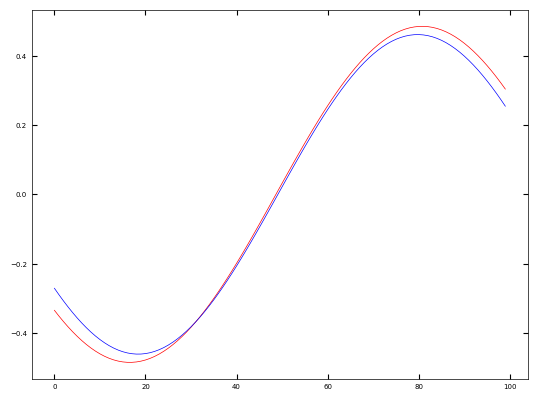

In [45]:
nala_spectra_generated, nala_params = model(
    nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [46]:
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


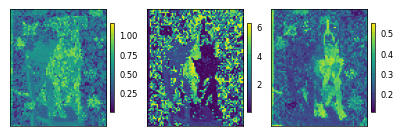

In [47]:
# Visualize the learned embeddings
embeddings(nala_params.detach().cpu().numpy(),
           shape_=image.shape[0:2], figsize=(5, 1.25))


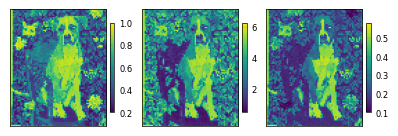

In [48]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(5, 1.25))
